In [2]:
import numpy as np
import seaborn as sb
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [3]:
%matplotlib inline

In [4]:
pip install openpyxl

In [5]:
os.environ["OMP_NUM_THREADS"] = "1"

In [6]:
# Load the Excel file into a pandas DataFrame
file_path = r"C:\Users\User\FYP(DESKTOP)\Waterquality.xlsx"
excel_data = pd.ExcelFile(file_path)

In [7]:
# Define the list of stations from which to extract data as per user request
stations = {
    'Zone1': ['TM3', 'TM4', 'TM6', 'TM8'],
    'Zone2': ['SM3', 'SM6', 'SM17', 'SM19'],
    'Zone3': ['PM3', 'PM7'],
    'Zone5': ['DM3', 'DM5'],
    'Zone6': ['MM2', 'MM4', 'MM14', 'MM16', 'MM17'],
    'Zone7': ['NM1', 'NM3'],
    'Zone8': ['WM2', 'WM3'],
    'Zone9': ['EM2'],
    'Zone10': ['VM1', 'VM4', 'VM7']
}

# Initialize an empty list to store dataframes
filtered_data = []

# Loop through the stations and extract the relevant columns for 'surr' data
for zone, station_list in stations.items():
    # Load the relevant sheet
    df = pd.read_excel(file_path, sheet_name=f'{zone}_All_Stations')
    
    # Find columns that match the 'surr' for the relevant stations
    matching_columns = [col for col in df.columns if any(f'{zone}_{station}_' in col for station in station_list)]
    
    # Extract the matching columns and the Date column
    extracted_data = df[['Date'] + matching_columns]
    
    
    # Append the extracted data to the list
    filtered_data.append(extracted_data)

# Combine all the filtered data from different zones into one dataframe
combined_filtered_data = pd.concat(filtered_data, axis=1)

# Save the result to a new CSV file
combined_filtered_data.to_csv('25station_data.csv', index=False)


In [9]:
stations_data = pd.read_csv('25stations_data_sur.csv')
rt_data = pd.read_csv('red_tide_data.csv')

In [8]:
# List of columns to drop
columns_to_drop = [
    'Group 1', 'Co-dominant Species 1', 'Cell Count (cells/ml)*.1', 
    'Group 2', 'Co-dominant Species 2', 'Cell Count (cells/ml)*.2'
]

# Drop the specified columns
rt_cleandata = rt_data.drop(columns=columns_to_drop)

# Save the cleaned data to a new CSV file
rt_cleandata.to_csv('rt_clean.csv', index=False)

In [9]:
unique_locations_count = rt_cleandata['Location'].nunique()

print("Number of unique locations:", unique_locations_count)

Number of unique locations: 386


In [3]:
stations_data = pd.read_csv('25stations_data_sur.csv')
rt_data = pd.read_csv('rt_clean.csv')
climate_data = pd.read_csv('climate.csv')
rawstations_data = pd.read_csv('25station_data.csv')

In [11]:
climate_data['SeaTemperature'] = climate_data['SeaTemperature'].fillna(climate_data['SeaTemperature'].mean())
climate_data['PrevailingWindDirection'] = climate_data['PrevailingWindDirection'].fillna(climate_data['PrevailingWindDirection'].mean())

In [12]:
print(stations_data.isnull().sum())
print(climate_data.isnull().sum())
print(rt_data.isnull().sum())
print(rawstations_data.isnull().sum())

Date                       0
Zone1_TM3_Sur_VSSolids     0
Zone1_TM3_Sur_UI_NH3       0
Zone1_TM3_Sur_Turbidit     0
Zone1_TM3_Sur_P            0
                          ..
Zone10_VM7_Sur_D_oxy       0
Zone10_VM7_Sur_D_oxy_pe    0
Zone10_VM7_Sur_Chlo_a      0
Zone10_VM7_Sur_N2H3        0
Zone10_VM7_Sur_Oxy_dema    0
Length: 601, dtype: int64
Date                       0
MeanTemp                   0
MaxTemp                    0
MinTemp                    0
Pressure                   0
DewPointTemp               0
WebBulbTemp                0
MeanRelativeHumidity       0
MeanAmountCloud            0
Rainfall                   0
GrassMinimunTemperature    0
BrightSunshine             0
GlobalSolarRadiation       0
Evaporation                0
PrevailingWindDirection    0
WindSpeed                  0
SeaTemperature             0
ReducedVisibility          0
dtype: int64
Incident No.              0
Red Tide Sighting No.     0
Date of Report            0
Date of Dissipation       0
Location

In [13]:
print(climate_data.columns)

Index(['Date', 'MeanTemp', 'MaxTemp', 'MinTemp', 'Pressure', 'DewPointTemp',
       'WebBulbTemp', 'MeanRelativeHumidity', 'MeanAmountCloud', 'Rainfall',
       'GrassMinimunTemperature', 'BrightSunshine', 'GlobalSolarRadiation',
       'Evaporation', 'PrevailingWindDirection', 'WindSpeed', 'SeaTemperature',
       'ReducedVisibility'],
      dtype='object')


In [14]:
# Step 1: Convert date columns to datetime format and extract year, month, and season

# Convert 'Date' in stations_data to datetime and extract year, month, season
stations_data['Date'] = pd.to_datetime(stations_data['Date'], format='%Y-%m-%d')
stations_data['Year'] = stations_data['Date'].dt.year
stations_data['Month'] = stations_data['Date'].dt.month
stations_data['Season'] = stations_data['Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall

# Convert 'Date of Report' and 'Date of Dissipation' in rt_clean_data to datetime and extract year, month, season
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], format='%d/%m/%Y')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], format='%d/%m/%Y')
rt_data['Year'] = rt_data['Date of Report'].dt.year
rt_data['Month'] = rt_data['Date of Report'].dt.month
rt_data['Season'] = rt_data['Date of Report'].dt.month % 12 // 3 + 1

# Step 2: Aggregate environmental data by year and month and calculate summary statistics
# (mean, min, max for each metric by year and month)
numeric_columns = stations_data.select_dtypes(include='number').columns
aggregated_stations_data = stations_data.groupby(['Year', 'Month'])[numeric_columns].agg(['mean', 'min', 'max']).reset_index()


# Display the head of the transformed data
stations_data[['Date', 'Year', 'Month', 'Season']].head(), rt_data[['Date of Report', 'Date of Dissipation', 'Year', 'Month', 'Season']].head(), aggregated_stations_data.head()


(        Date  Year  Month  Season
 0 1997-01-01  1997      1       1
 1 1997-02-01  1997      2       1
 2 1997-03-01  1997      3       2
 3 1997-04-01  1997      4       2
 4 1997-05-01  1997      5       2,
   Date of Report Date of Dissipation  Year  Month  Season
 0     1996-01-25          1996-03-02  1996      1       1
 1     1996-03-15          1996-03-24  1996      3       2
 2     1996-03-17          1996-03-19  1996      3       2
 3     1996-04-16          1996-04-17  1996      4       2
 4     1996-04-17          1996-04-18  1996      4       2,
    Year Month Zone1_TM3_Sur_VSSolids                     Zone1_TM3_Sur_UI_NH3  \
                                 mean       min       max                 mean   
 0  1997     1               2.314286  2.314286  2.314286             0.012857   
 1  1997     2               1.542857  1.542857  1.542857             0.024571   
 2  1997     3               3.925000  3.925000  3.925000             0.005750   
 3  1997     4          

#RFT MODEL

In [15]:
# Convert dates to datetime format
stations_data['Date'] = pd.to_datetime(stations_data['Date'], errors='coerce')
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], dayfirst=True, errors='coerce')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], dayfirst=True, errors='coerce')

# Select only the columns for Zone1 and the specific parameters
zone_params = ['Date'] + [
    col for col in stations_data.columns
    if 'Zone1_' in col and any(param in col for param in ['Sur_N$', 'Sur_Chlo_a', 'Sur_P$', 'Sur_Temp', 'Sur_Salinity'])
]

zone_data = stations_data[zone_params]

# Rename columns to include both the station and parameter in a readable format
zone_data.columns = [
    'Date' if col == 'Date' else f"{col.split('_')[1]} {col.split('_')[3]}"
    for col in zone_data.columns
]
zone_data = zone_data.copy()  # Make sure it's a copy of the original data

# Create target variable based on the duration of Red Tide (from 'Date of Report' to 'Date of Dissipation')
def is_red_tide_occurrence(row, rt_data):
    """Check if the date is between the Date of Report and Date of Dissipation."""
    for _, report in rt_data.iterrows():
        if report['Date of Report'] <= row['Date'] <= report['Date of Dissipation']:
            return 1
    return 0

print(zone_data.columns)

Index(['Date', 'TM3 Temp', 'TM3 Salinity', 'TM3 Chlo', 'TM4 Temp',
       'TM4 Salinity', 'TM4 Chlo', 'TM6 Temp', 'TM6 Salinity', 'TM6 Chlo',
       'TM8 Temp', 'TM8 Salinity', 'TM8 Chlo'],
      dtype='object')


In [16]:
# Apply the function to each row to create 'Red Tide Occurrence'
zone_data['Red Tide Occurrence'] = zone_data.apply(is_red_tide_occurrence, axis=1, rt_data=rt_data)

# Drop rows with missing values
zone_data = zone_data.dropna()

# Define features (X) and target (y)
X = zone_data[['TM3 Temp', 'TM3 Salinity', 'TM3 Chlo', 'TM4 Temp',
       'TM4 Salinity', 'TM4 Chlo', 'TM6 Temp', 'TM6 Salinity', 'TM6 Chlo',
       'TM8 Temp', 'TM8 Salinity', 'TM8 Chlo']]
y = zone_data['Red Tide Occurrence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data (fit on training data, transform on both train and test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Initialize and train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf.predict(X_test_scaled)

# Print the results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.6944444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        56
           1       0.31      0.31      0.31        16

    accuracy                           0.69        72
   macro avg       0.56      0.56      0.56        72
weighted avg       0.69      0.69      0.69        72



         Feature  Importance
5       TM4 Chlo    0.097896
11      TM8 Chlo    0.096000
1   TM3 Salinity    0.093913
0       TM3 Temp    0.089284
10  TM8 Salinity    0.083487
8       TM6 Chlo    0.082316
9       TM8 Temp    0.082153
2       TM3 Chlo    0.078796
7   TM6 Salinity    0.077088
4   TM4 Salinity    0.075001


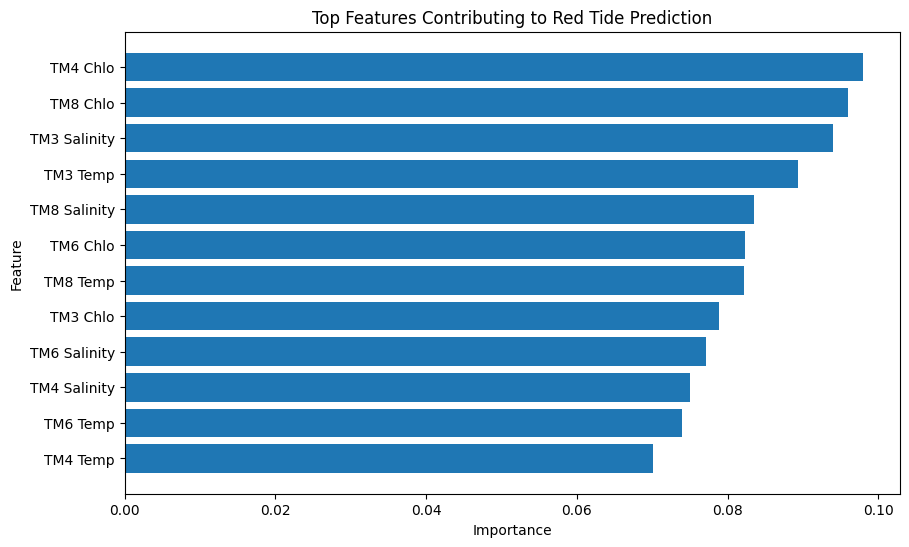

In [18]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_importances.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top Features Contributing to Red Tide Prediction")
plt.gca().invert_yaxis()
plt.show()

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define features (X) and target (y)
X = zone_data[['TM3 Temp', 'TM3 Salinity', 'TM3 Chlo', 'TM4 Temp',
       'TM4 Salinity', 'TM4 Chlo', 'TM6 Temp', 'TM6 Salinity', 'TM6 Chlo',
       'TM8 Temp', 'TM8 Salinity', 'TM8 Chlo']]
y = zone_data['Red Tide Occurrence']

# Parameters
num_iterations = 10
test_size = 0.2
random_state = 42

# Store results
accuracies = []


# Iterative process
for i in range(num_iterations):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state + i
    )
    
    # Define and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state + i)
    rf_model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Summarize results
print(f"Accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")

Accuracies: [0.7291666666666666, 0.5416666666666666, 0.6875, 0.6666666666666666, 0.6666666666666666, 0.6458333333333334, 0.6041666666666666, 0.7083333333333334, 0.6875, 0.6458333333333334]
Mean Accuracy: 0.6583
Standard Deviation: 0.0512


In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define features (X) and target (y)
X = zone_data[['TM3 Temp', 'TM3 Salinity', 'TM3 Chlo', 'TM4 Temp',
               'TM4 Salinity', 'TM4 Chlo', 'TM6 Temp', 'TM6 Salinity', 'TM6 Chlo',
               'TM8 Temp', 'TM8 Salinity', 'TM8 Chlo']]
y = zone_data['Red Tide Occurrence']

# Parameters
num_iterations = 10
test_size = 0.2
random_state = 42

# Store results
accuracies = []

# Iterative process
for i in range(num_iterations):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state + i
    )
    
    # Define and train base model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=random_state + i)
    rf_model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Feature importance analysis
    if i == 0:  # Perform this once
        feature_importances = rf_model.feature_importances_
        print("Feature Importances:")
        for feature, importance in zip(X.columns, feature_importances):
            print(f"{feature}: {importance:.4f}")

# Summarize results
print(f"\nAccuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")

# GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Best parameters and evaluation
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)

# Re-evaluate model with the best parameters
best_rf_model = grid_search.best_estimator_

# Train-test split for final evaluation
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)
best_rf_model.fit(X_train_final, y_train_final)
y_pred_final = best_rf_model.predict(X_test_final)

# Final accuracy and classification report
print("\nFinal Model Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred_final))


Feature Importances:
TM3 Temp: 0.0727
TM3 Salinity: 0.0883
TM3 Chlo: 0.0808
TM4 Temp: 0.0799
TM4 Salinity: 0.0773
TM4 Chlo: 0.0915
TM6 Temp: 0.0786
TM6 Salinity: 0.0763
TM6 Chlo: 0.0753
TM8 Temp: 0.0900
TM8 Salinity: 0.0858
TM8 Chlo: 0.1035

Accuracies: [0.7291666666666666, 0.5416666666666666, 0.6875, 0.6666666666666666, 0.6666666666666666, 0.6458333333333334, 0.6041666666666666, 0.7083333333333334, 0.6875, 0.6458333333333334]
Mean Accuracy: 0.6583
Standard Deviation: 0.0512

Best Parameters from GridSearchCV:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Final Model Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.67      0.15      0.25        13

    accuracy                           0.75        48
   macro avg       0.71      0.56      0.55        48
weighted avg       0.73      0.75      0.69        48



In [21]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


Cross-Validation Accuracy: 0.6417 ± 0.0677


In [22]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [168, 192]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

# Step 1: Prepare the Data
# Extract features (X) and target (y)
features = [
    'TM3 Temp', 'TM3 Salinity', 'TM3 Chlo', 
    'TM4 Temp', 'TM4 Salinity', 'TM4 Chlo', 
    'TM6 Temp', 'TM6 Salinity', 'TM6 Chlo', 
    'TM8 Temp', 'TM8 Salinity', 'TM8 Chlo'
]
target = 'Red Tide Occurrence'

X = zone_data[features].values
y = zone_data[target].values

# Step 2: Create Time-Series Sequences
def create_sequences(data, labels, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = labels[i + sequence_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

sequence_length = 30  # Use 30 time steps to predict the next red tide occurrence
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42, stratify=y_seq)

# Step 4: Normalize Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# Build the LSTM Model
model = Sequential([
    Input(shape=(sequence_length, X_train.shape[2])),  # Explicit input layer
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Step 6: Train the Model


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    
)

# Step 7: Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 8: Predict and Visualize Results
predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)



In [ ]:
# Visualization of Predictions vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='True Values')
plt.plot(predictions_binary[:100], label='Predictions', linestyle='dashed')
plt.title("Red Tide Predictions vs True Values")
plt.legend()
plt.show()

In [23]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)  # X is the features

# Reshape data to 3D: (samples, timesteps, features)
# Assuming your data is time-ordered, we will create lag features (e.g., 3-time steps as input)
timesteps = 3

def create_lstm_data(data, target, timesteps):
    X_lstm, y_lstm = [], []
    for i in range(len(data) - timesteps):
        X_lstm.append(data[i:i+timesteps])
        y_lstm.append(target[i+timesteps])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_data(scaled_data, y, timesteps)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Define LSTM model
model = Sequential()

# Add Input layer (define input shape here)
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.2))

# Add Dense layer for output
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification (Red Tide: Yes or No)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 50)               │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.6249 - loss: 0.6737 - val_accuracy: 0.7708 - val_loss: 0.6197
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6886 - loss: 0.6462 - val_accuracy: 0.7708 - val_loss: 0.5861
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5707 - loss: 0.6856 - val_accuracy: 0.7708 - val_loss: 0.5772
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6567 - loss: 0.6435 - val_accuracy: 0.7708 - val_loss: 0.5641
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6506 - loss: 0.6485 - val_accuracy: 0.7708 - val_loss: 0.5584
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6096 - loss: 0.6687 - val_accuracy: 0.7708 - val_loss: 0.5611
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6553 - loss: 0.6328 - val_accuracy: 0.7708 - val_loss: 0.5603
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6389 - loss: 0.6489 - val_accuracy: 0.7708 - val_loss: 0.5642
Epoch 

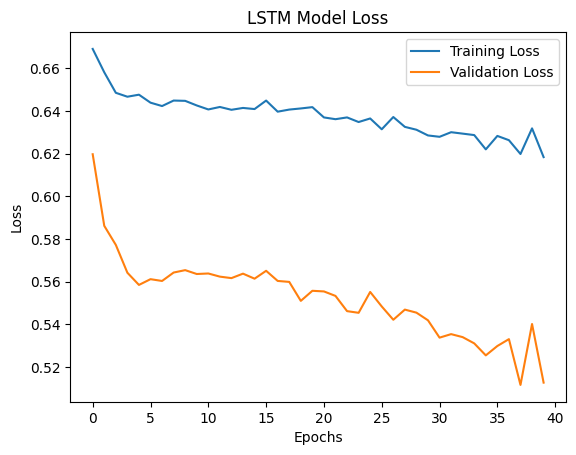

In [25]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss to see the performance
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7986 - loss: 0.5083
Test Accuracy: 0.7917


In [27]:
# Predict red tide occurrence for the test set
y_pred = model.predict(X_test)

# Since it's a binary classification, we can convert probabilities to labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

# Evaluate accuracy
from sklearn.metrics import accuracy_score, classification_report
print(f"Accuracy: {accuracy_score(y_test, y_pred_labels):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Accuracy: 0.7917
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        37
           1       0.67      0.18      0.29        11

    accuracy                           0.79        48
   macro avg       0.73      0.58      0.58        48
weighted avg       0.77      0.79      0.74        48



In [28]:
# Ensure that both 'Date of Report' and 'Date of Dissipation' are in datetime format
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], errors='coerce', dayfirst=True)
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], errors='coerce', dayfirst=True)

# Convert 'Date' in stations_data to datetime
stations_data['Date'] = pd.to_datetime(stations_data['Date'], errors='coerce')

# Define a function to check if the environmental date falls within the red tide period
def is_red_tide_occurrence(date, report_date, dissipation_date):
    if pd.isna(date) or pd.isna(report_date) or pd.isna(dissipation_date):
        return 0  # No red tide occurrence if any date is missing
    return 1 if report_date <= date <= dissipation_date else 0

# Add a column to mark the red tide occurrences for each observation in environmental data
stations_data['red_tide_occurred'] = stations_data['Date'].apply(
    lambda x: is_red_tide_occurrence(x, rt_data['Date of Report'].iloc[0], rt_data['Date of Dissipation'].iloc[0])
)

In [29]:
# Extract columns for Zone1
zone1_columns = [col for col in stations_data.columns if col.startswith('Zone1')]

# Select only relevant columns from the environmental dataset for Zone1
zone1_data = stations_data[['Date'] + zone1_columns].copy()

# Merge with the red tide data, aligning based on the 'Date'
merged_data = pd.merge(zone1_data, rt_data[['Date of Report', 'Date of Dissipation']], 
                       left_on='Date', right_on='Date of Report', how='left')

# Create the red_tide_occurred binary column by checking if 'Date' falls between 'Date of Report' and 'Date of Dissipation'
merged_data['red_tide_occurred'] = merged_data.apply(
    lambda row: is_red_tide_occurrence(row['Date'], row['Date of Report'], row['Date of Dissipation']),
    axis=1
)

In [30]:
# Calculate the correlation of water quality parameters with the red tide occurrence
correlations = merged_data[zone1_columns + ['red_tide_occurred']].corr()

# Display correlation of parameters with red_tide_occurred
print(correlations['red_tide_occurred'])

Zone1_TM3_Sur_VSSolids     0.203305
Zone1_TM3_Sur_UI_NH3       0.074020
Zone1_TM3_Sur_Turbidit    -0.113063
Zone1_TM3_Sur_P            0.160590
Zone1_TM3_Sur_N            0.201497
                             ...   
Zone10_VM7_Sur_D_oxy_pe    0.127555
Zone10_VM7_Sur_Chlo_a     -0.049397
Zone10_VM7_Sur_N2H3        0.102032
Zone10_VM7_Sur_Oxy_dema    0.048317
red_tide_occurred          1.000000
Name: red_tide_occurred, Length: 169, dtype: float64


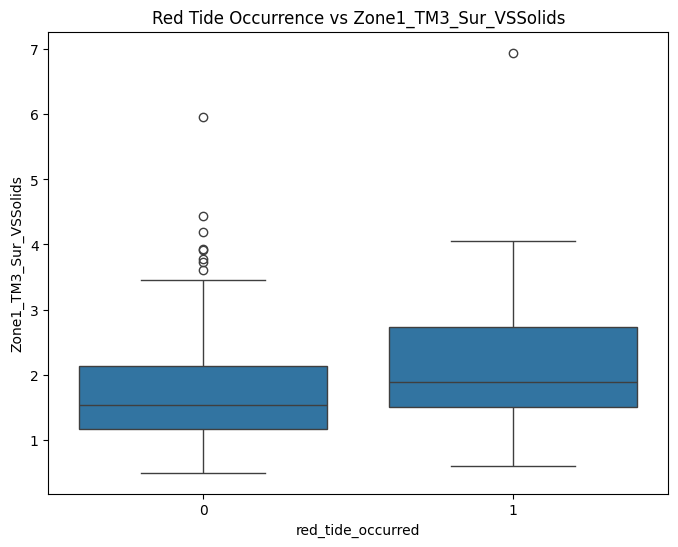

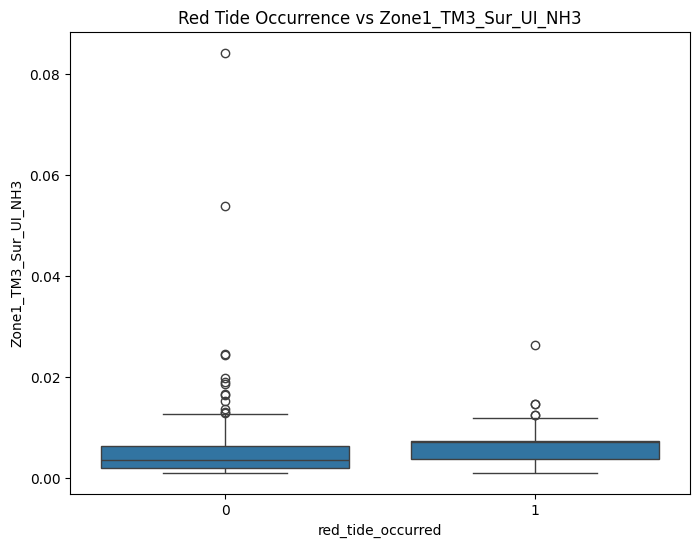

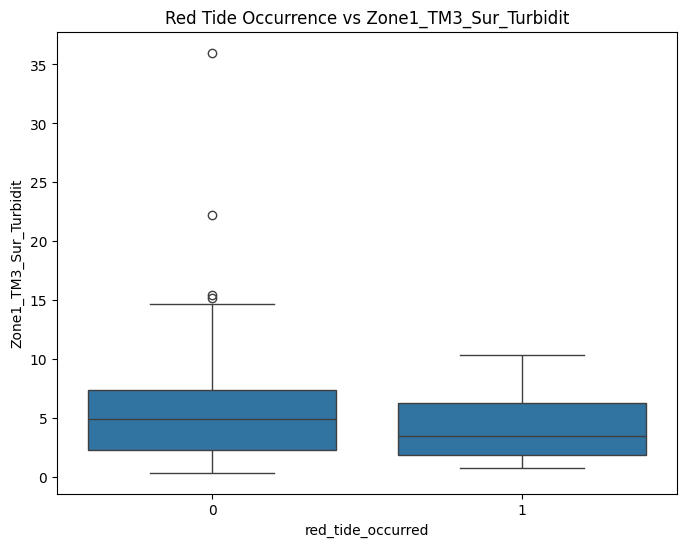

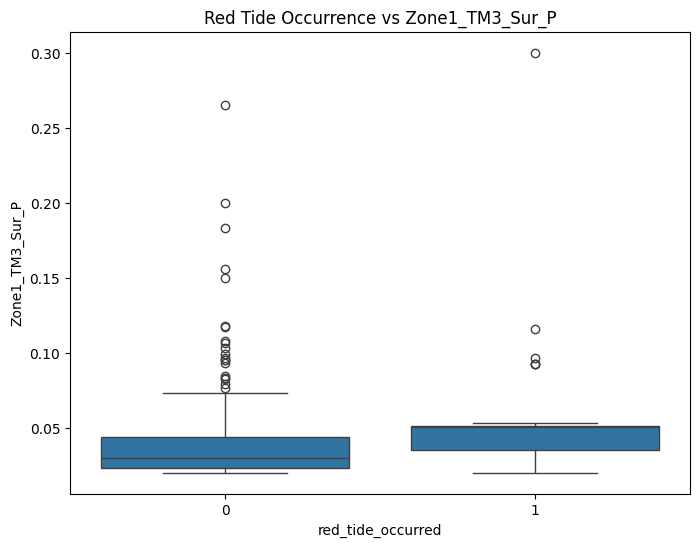

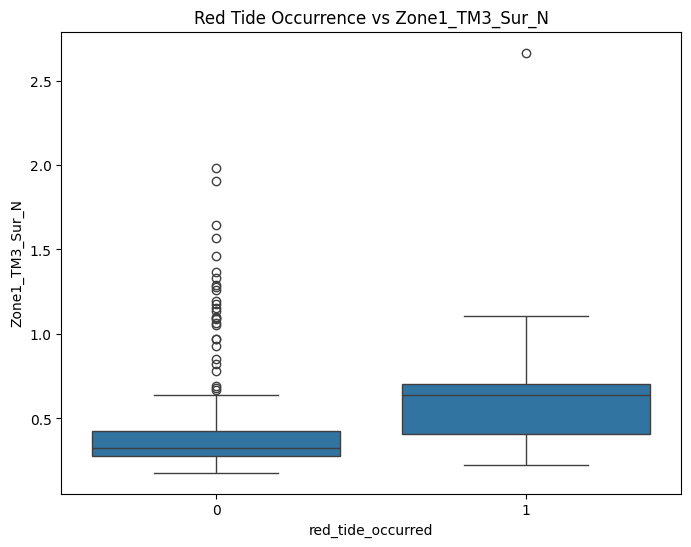

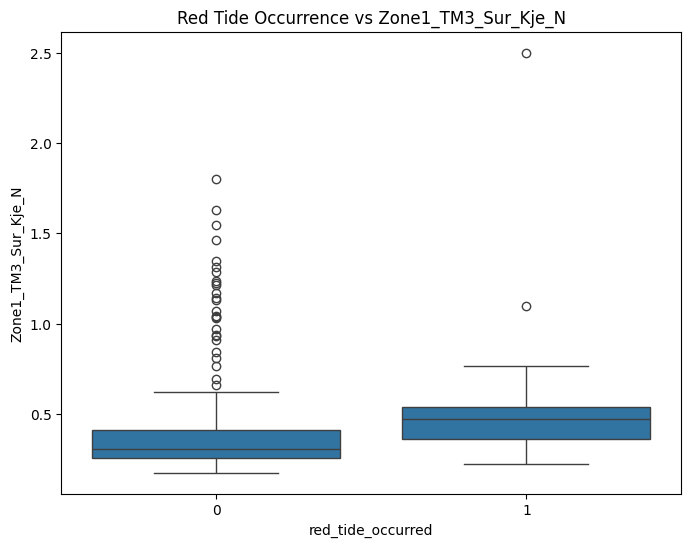

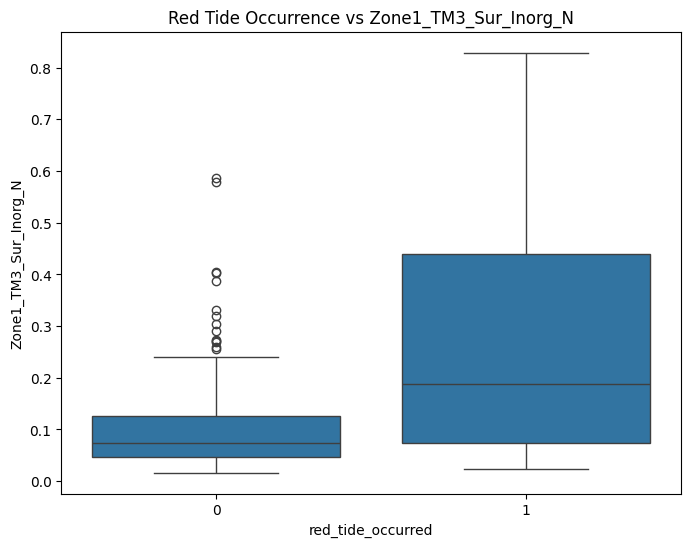

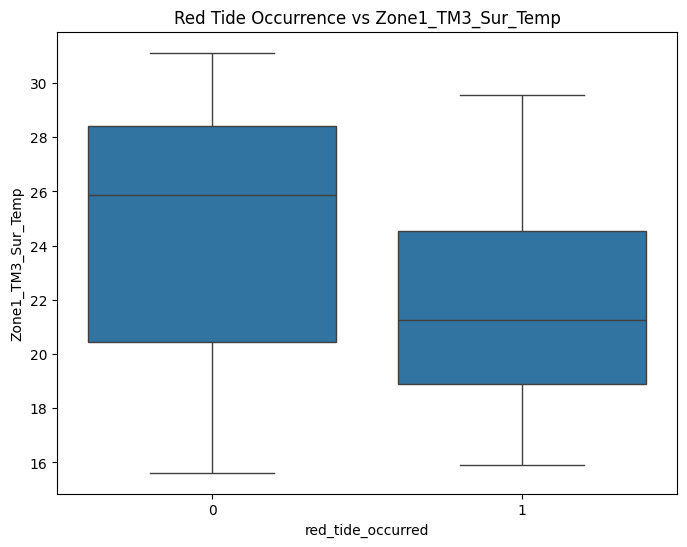

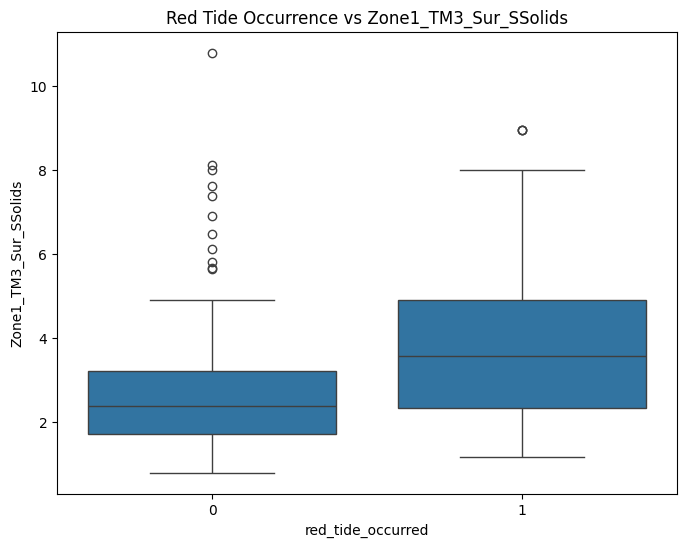

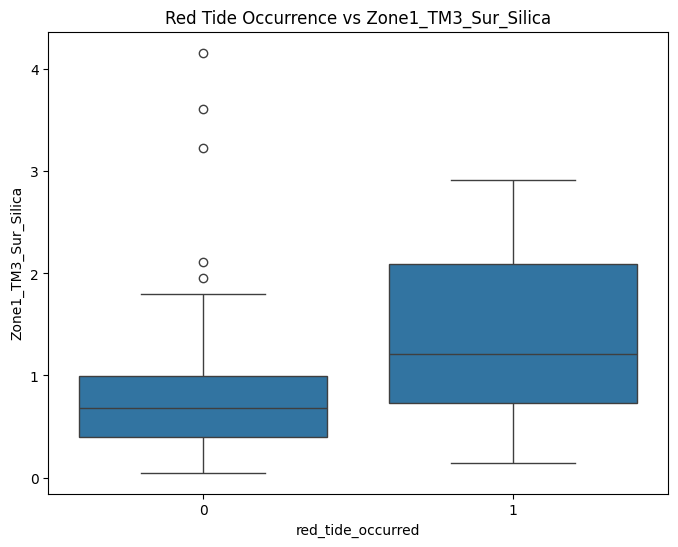

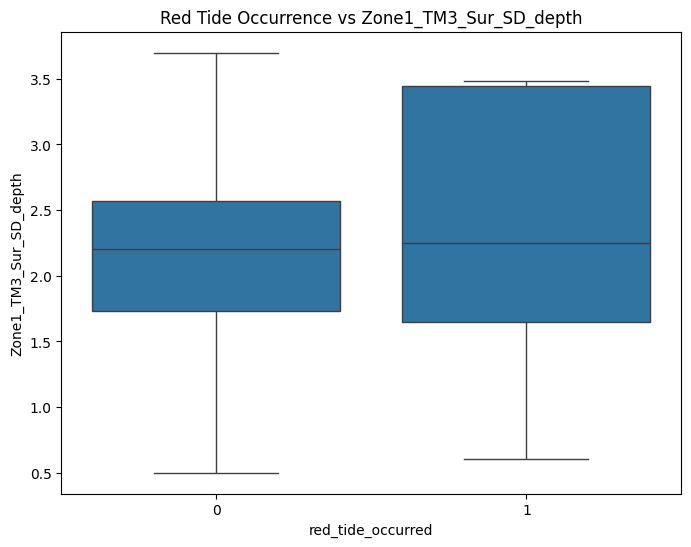

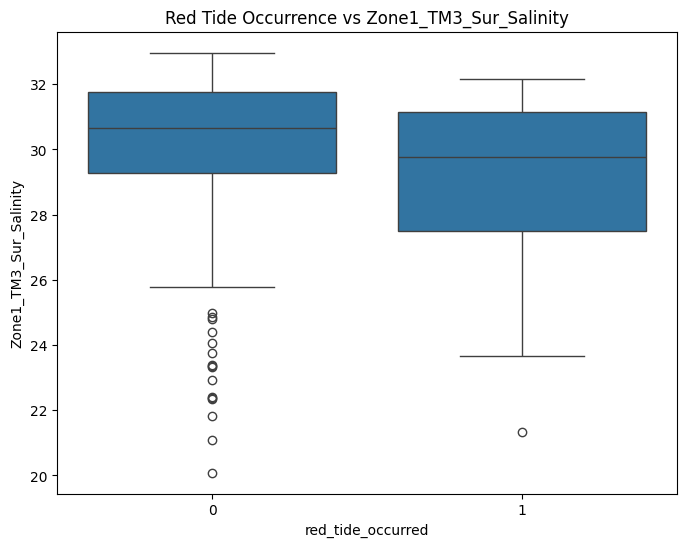

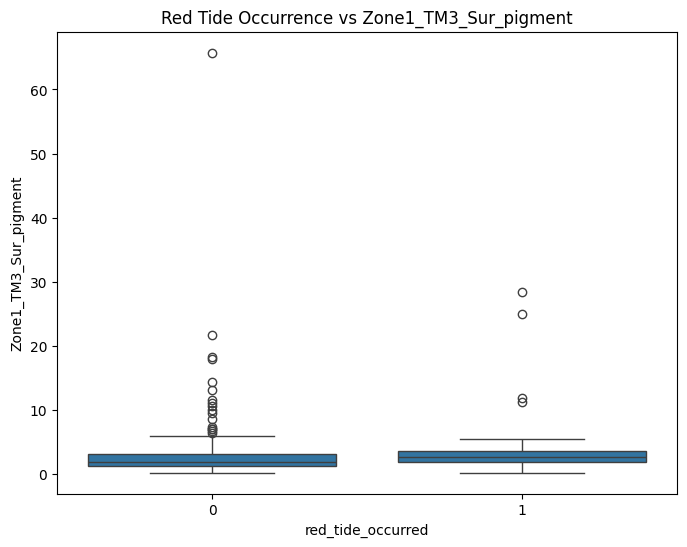

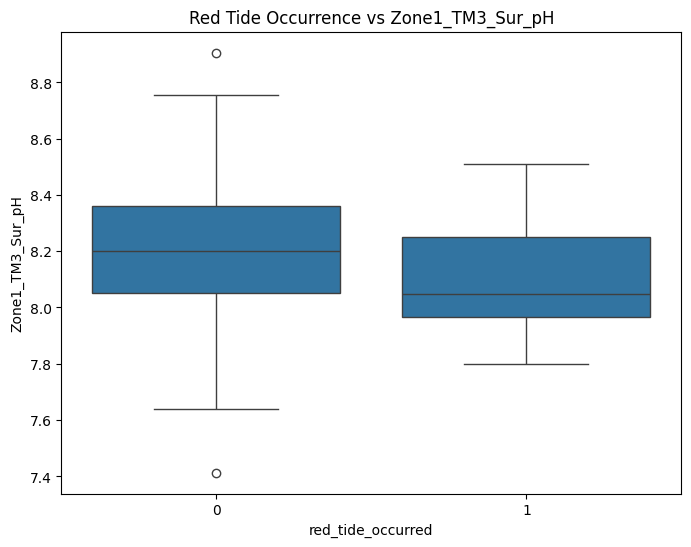

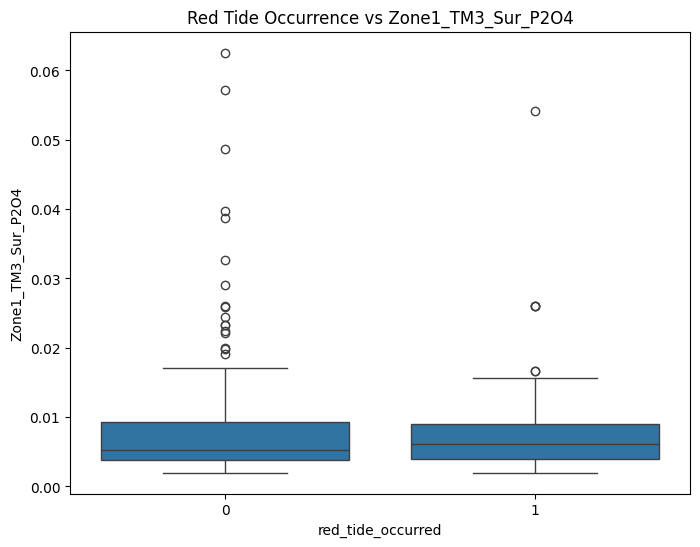

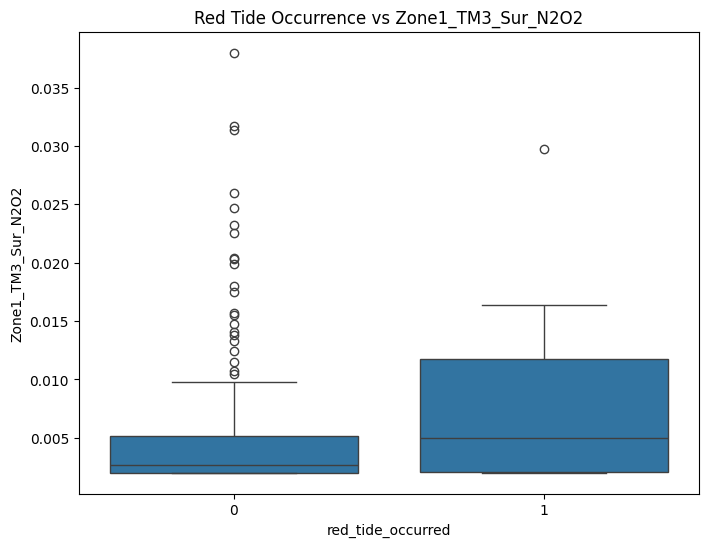

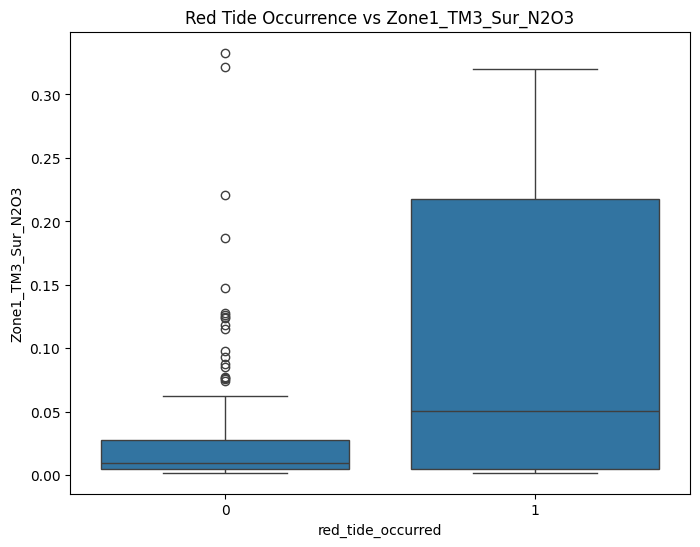

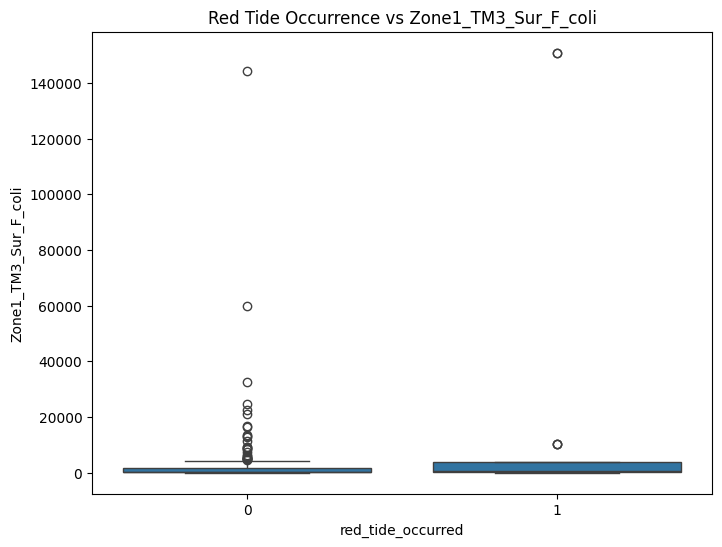

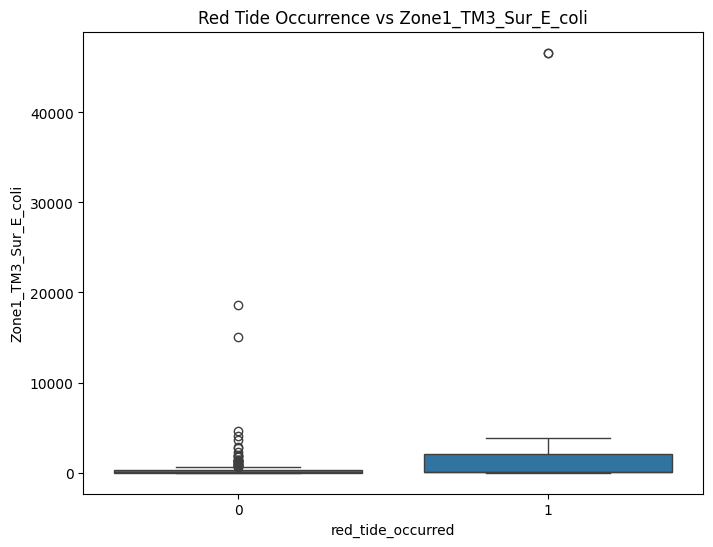

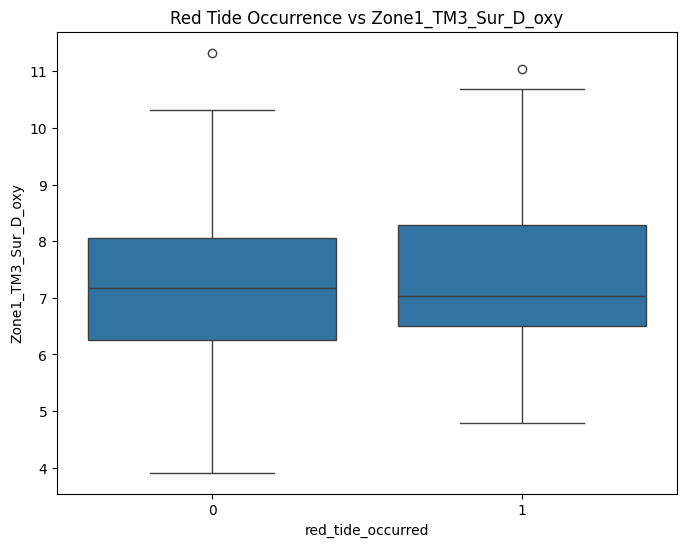

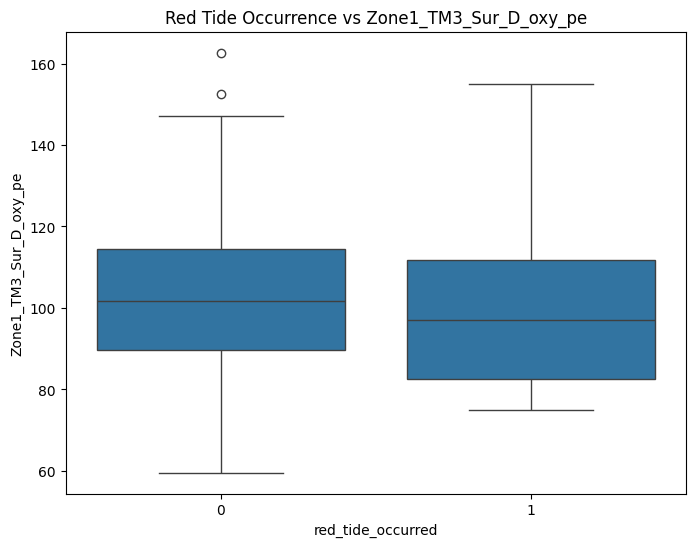

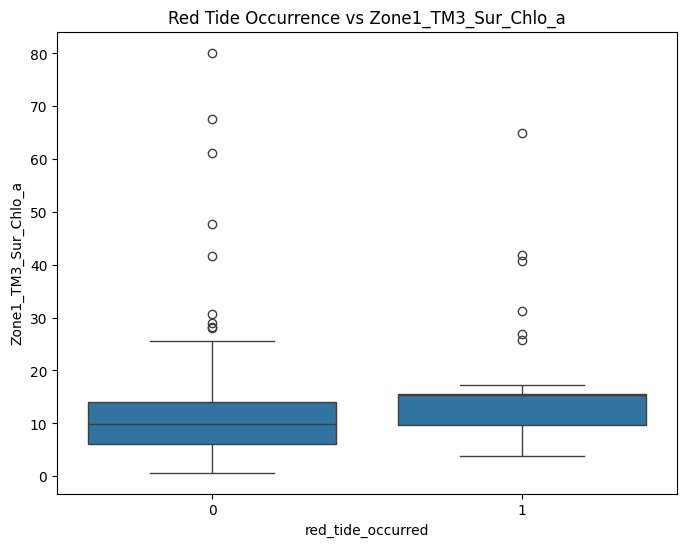

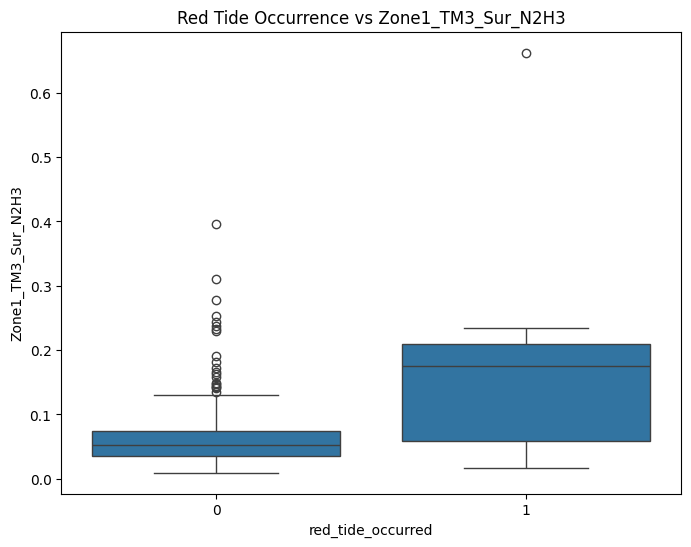

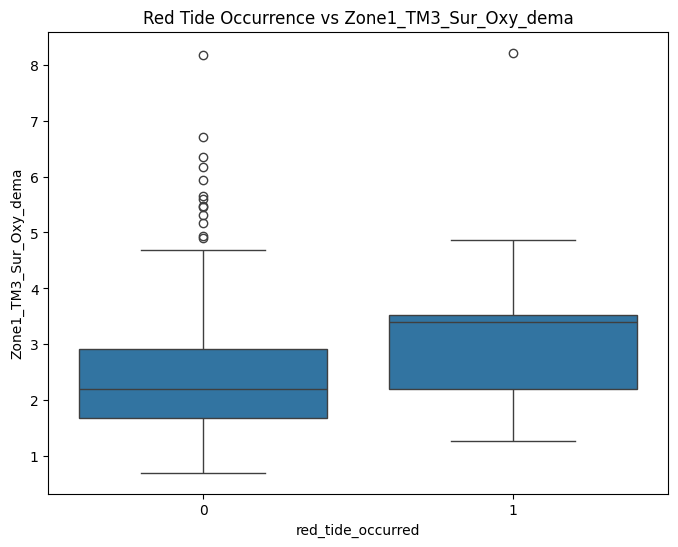

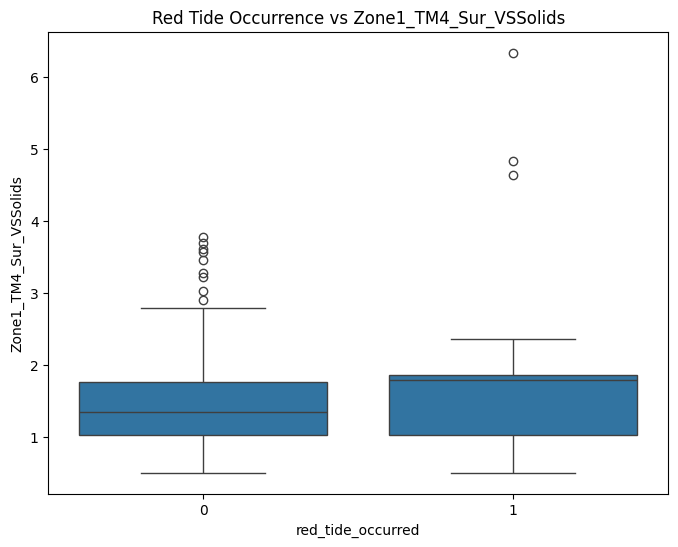

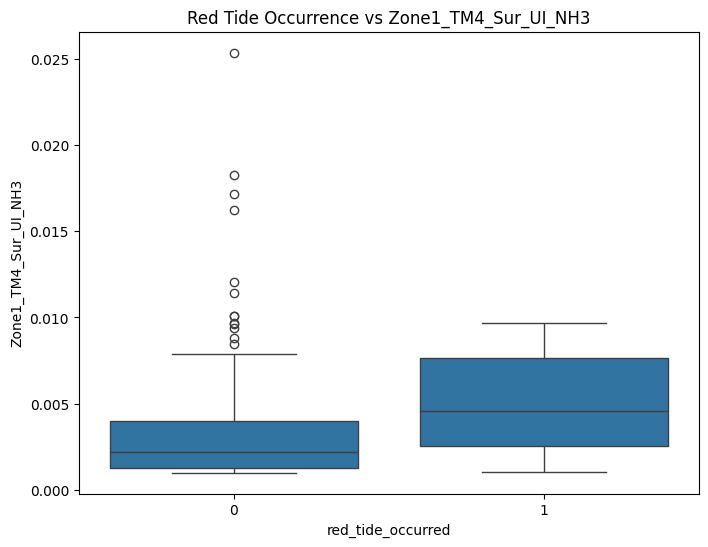

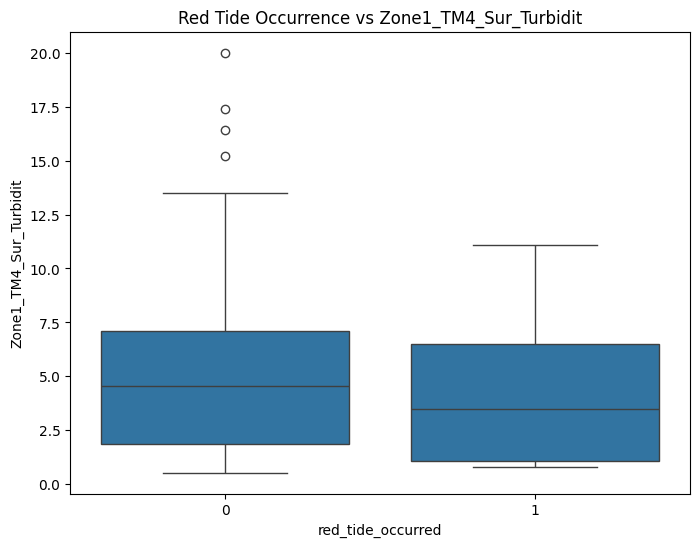

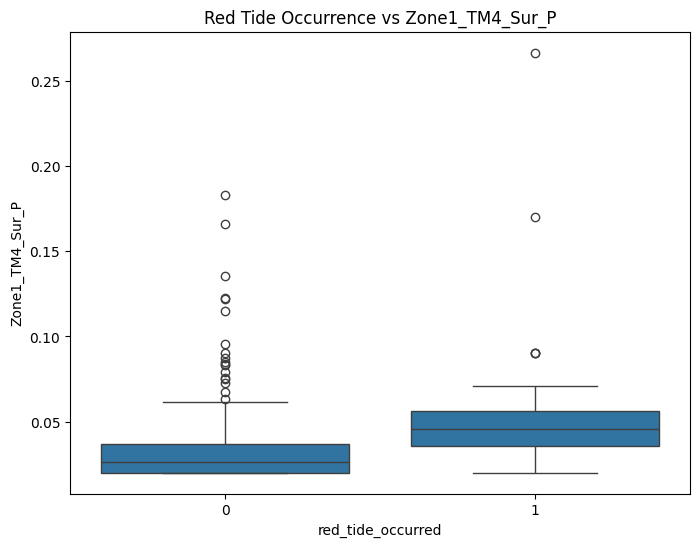

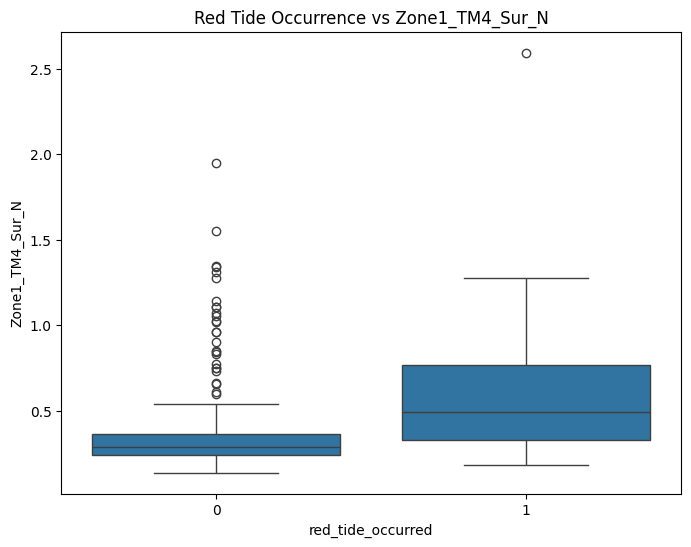

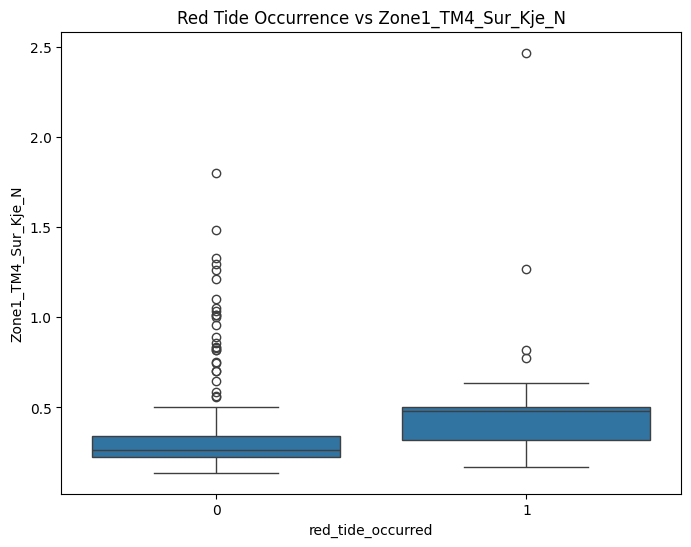

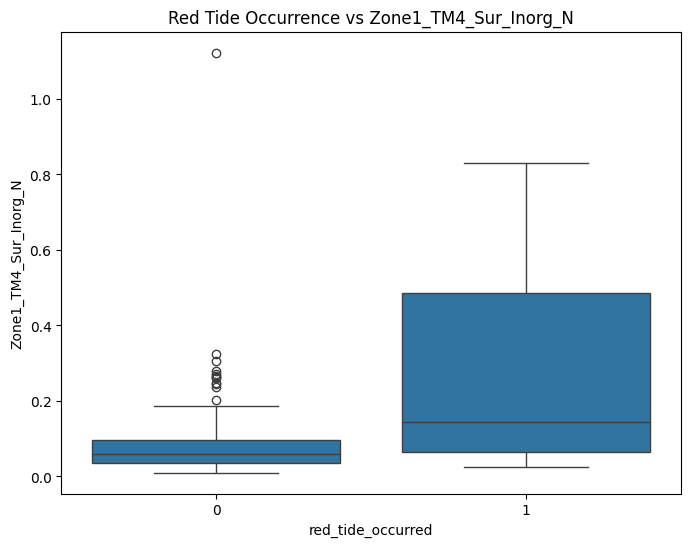

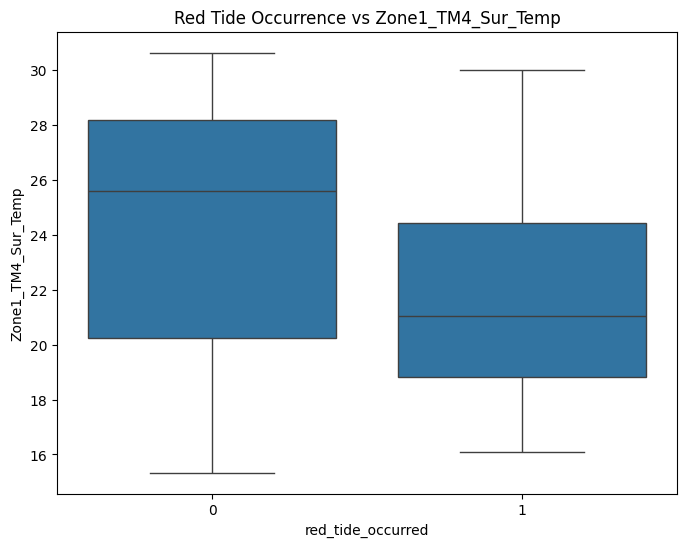

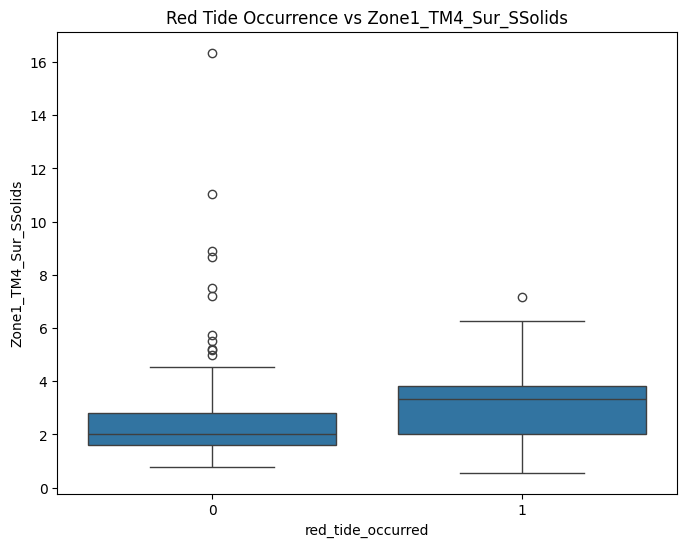

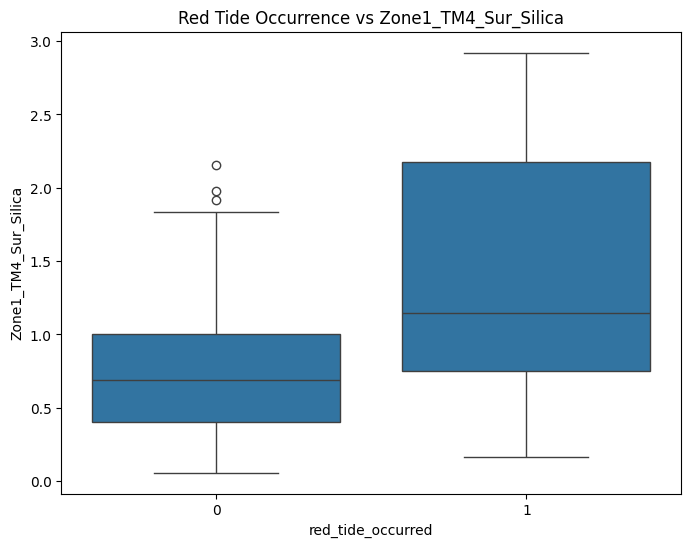

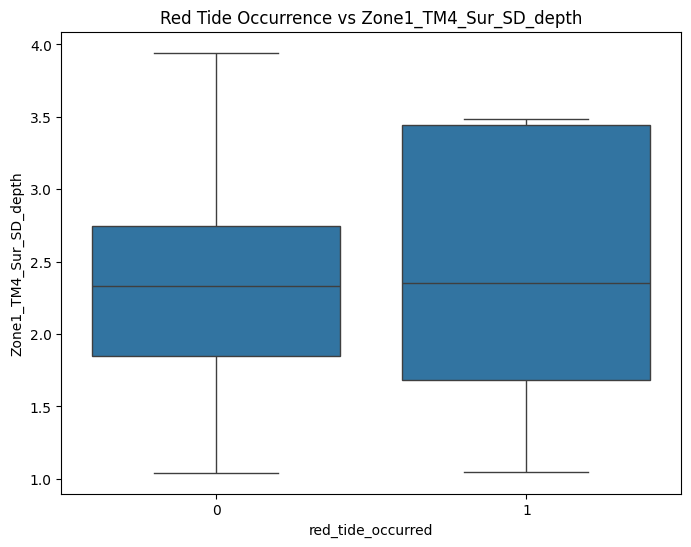

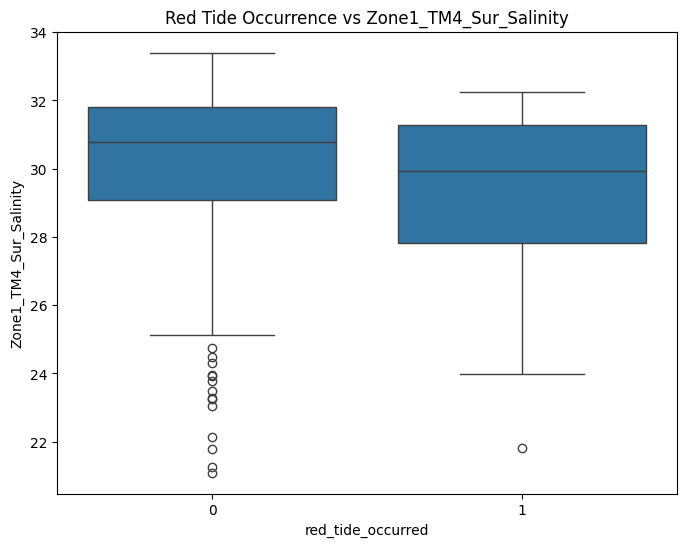

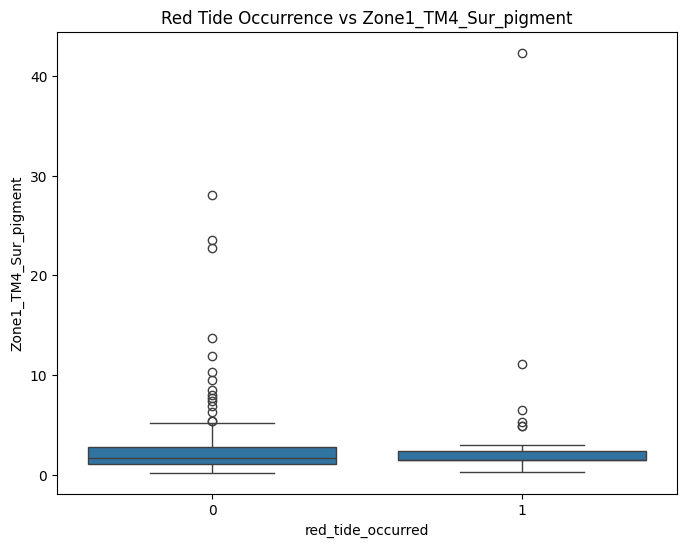

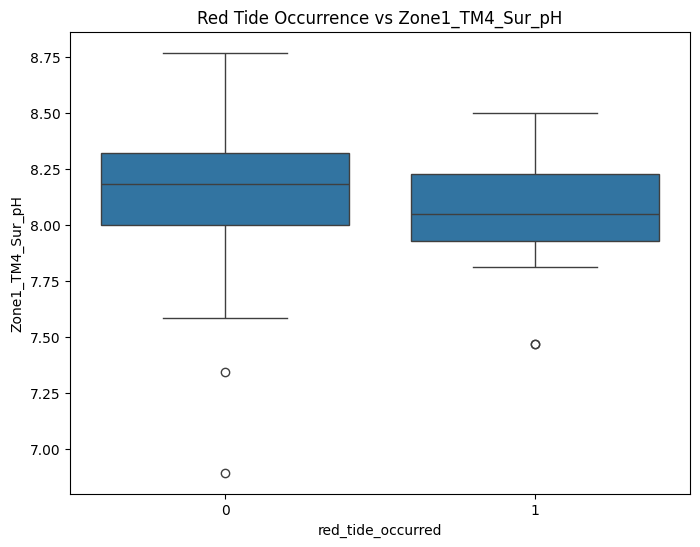

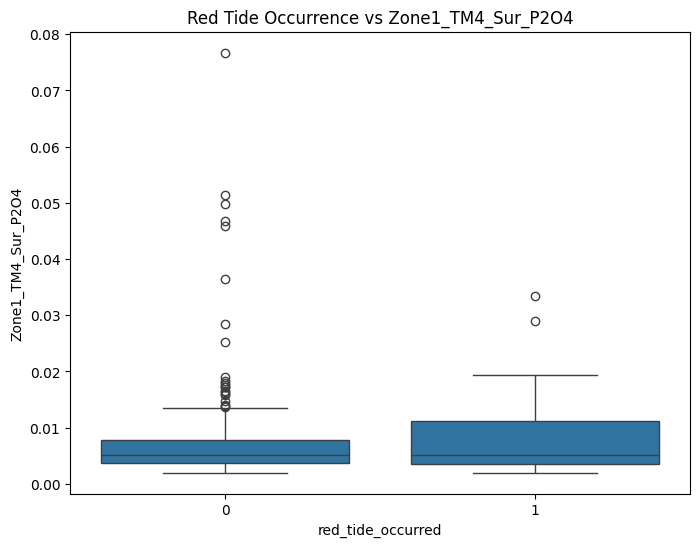

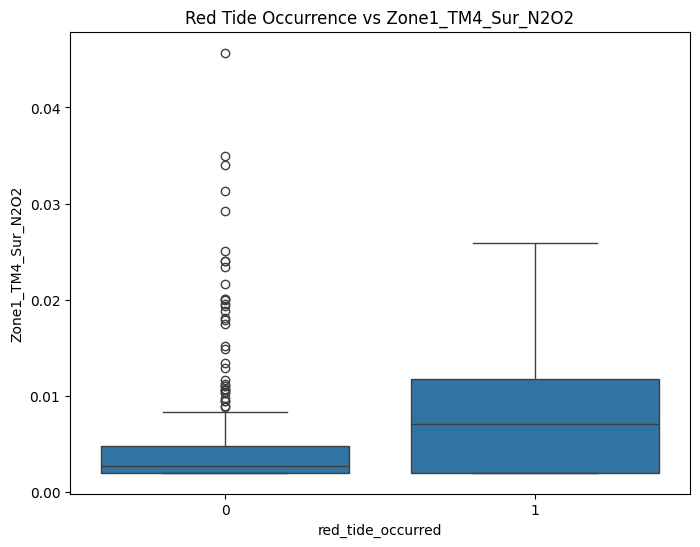

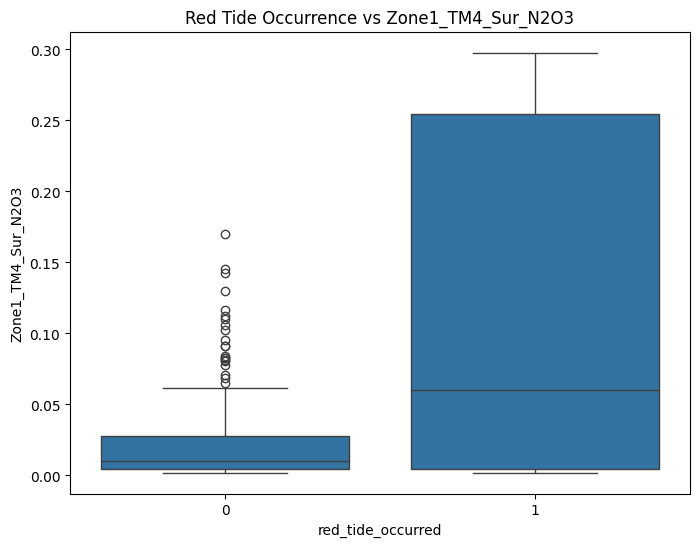

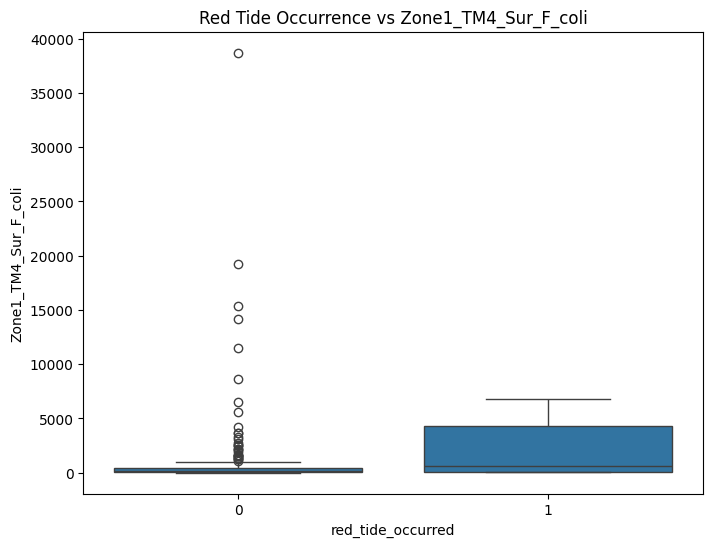

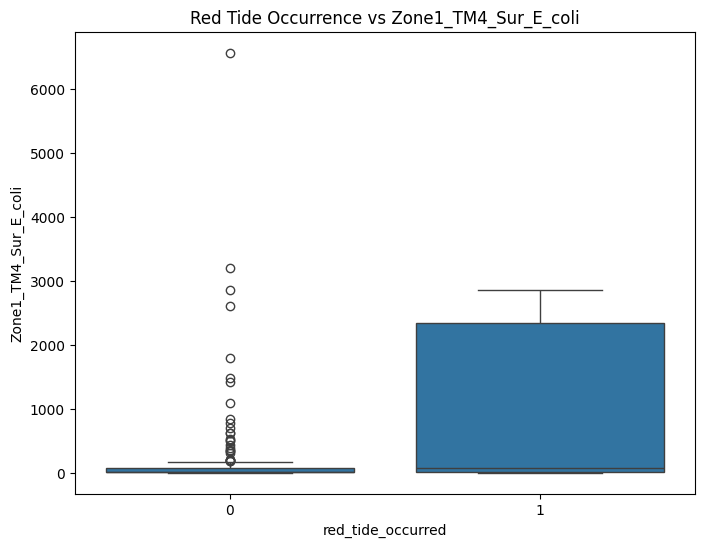

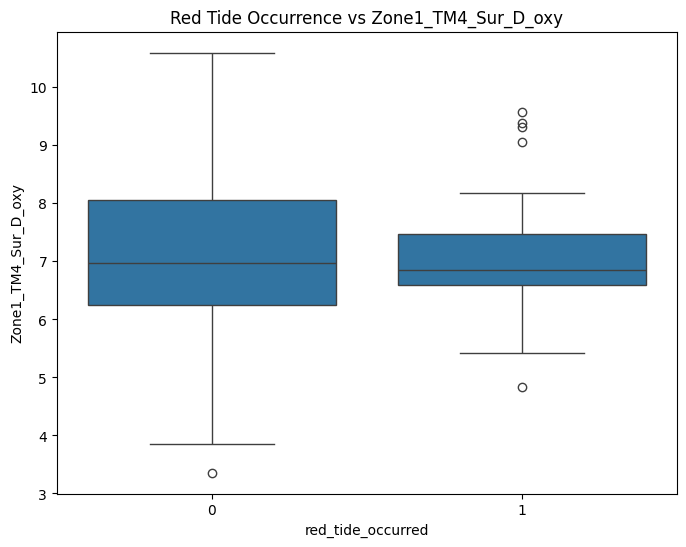

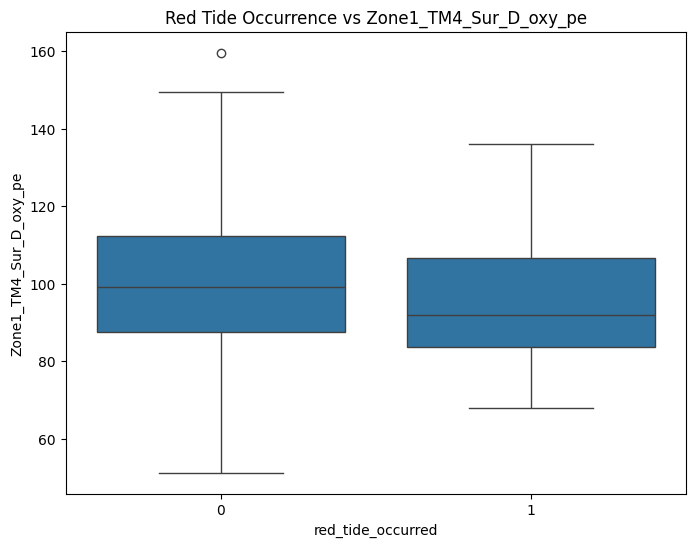

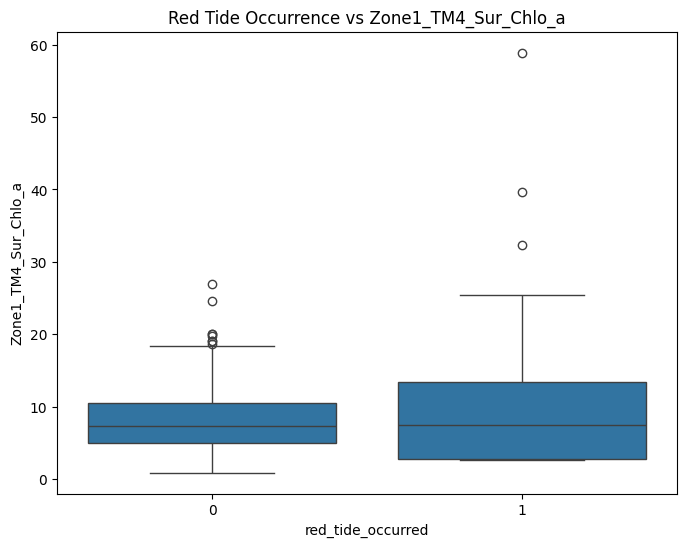

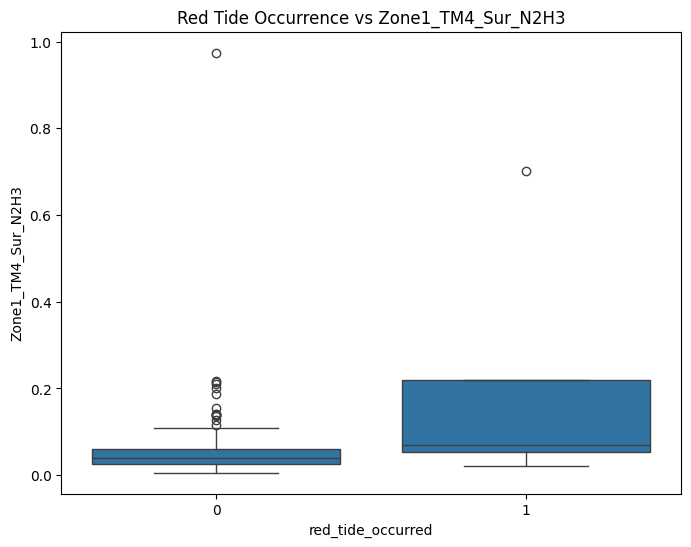

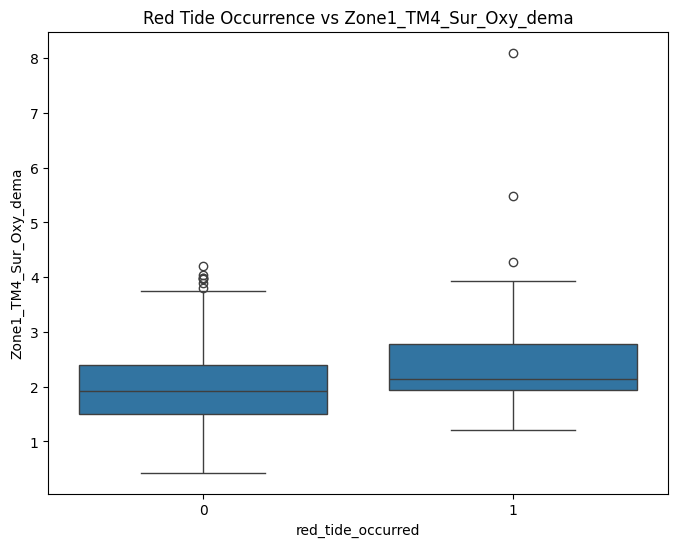

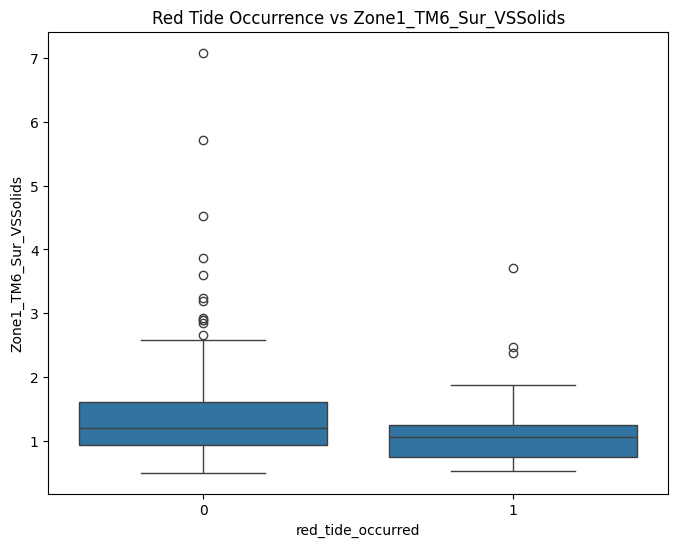

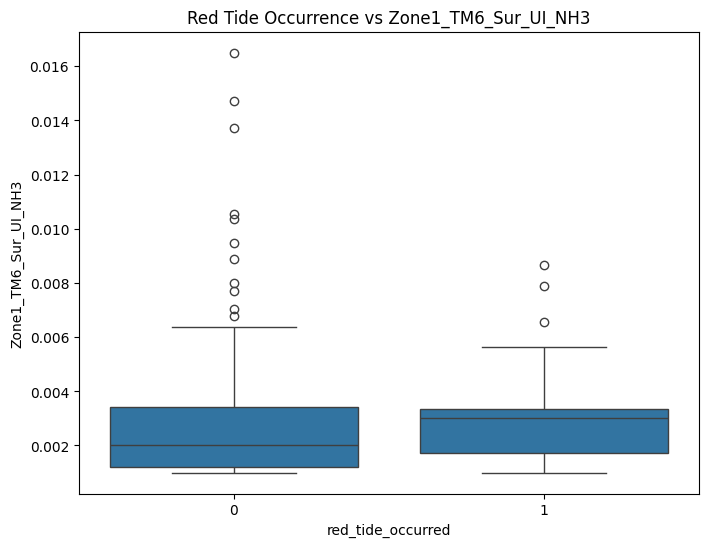

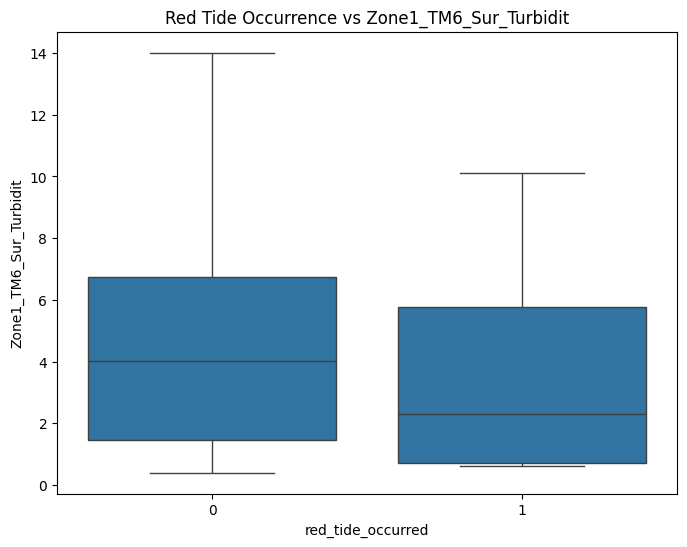

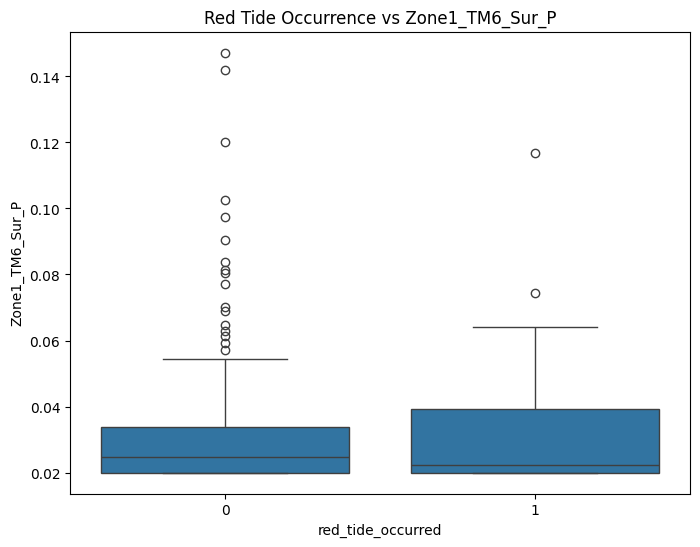

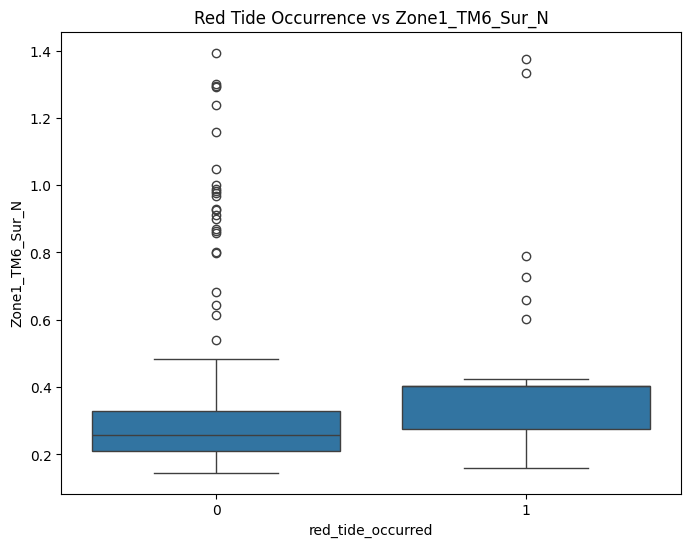

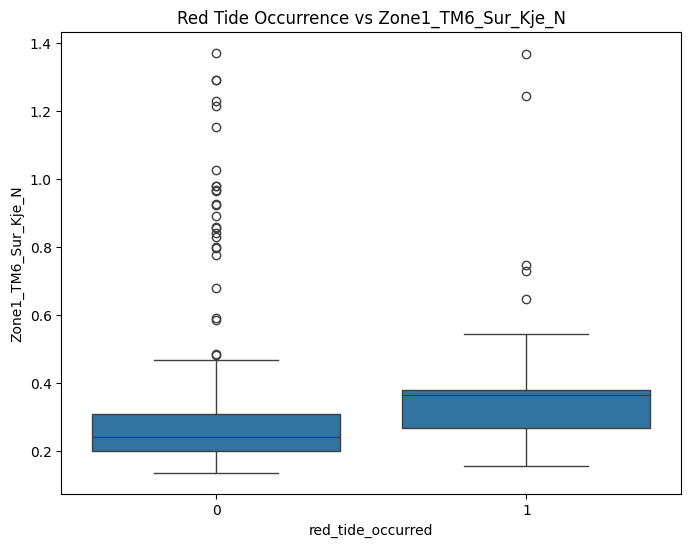

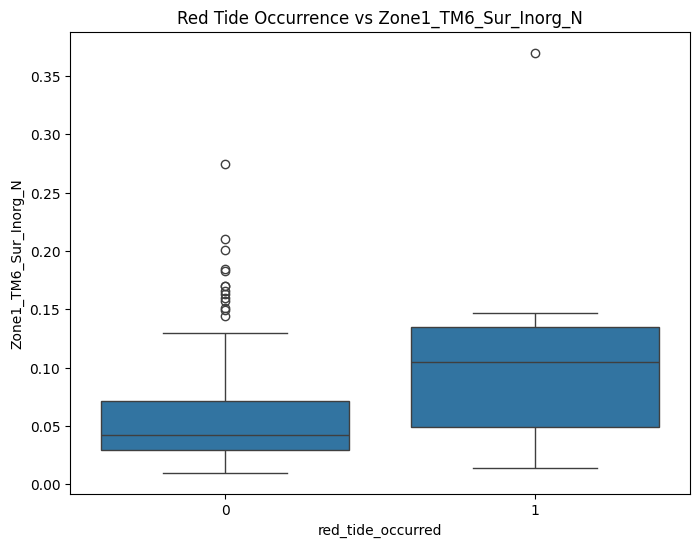

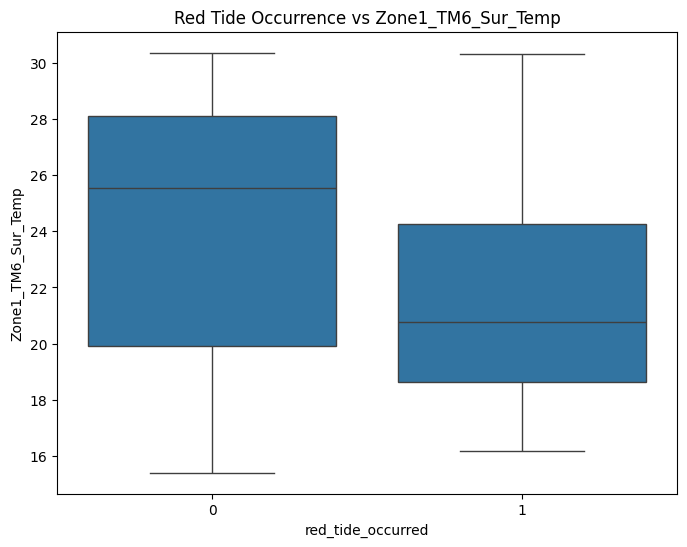

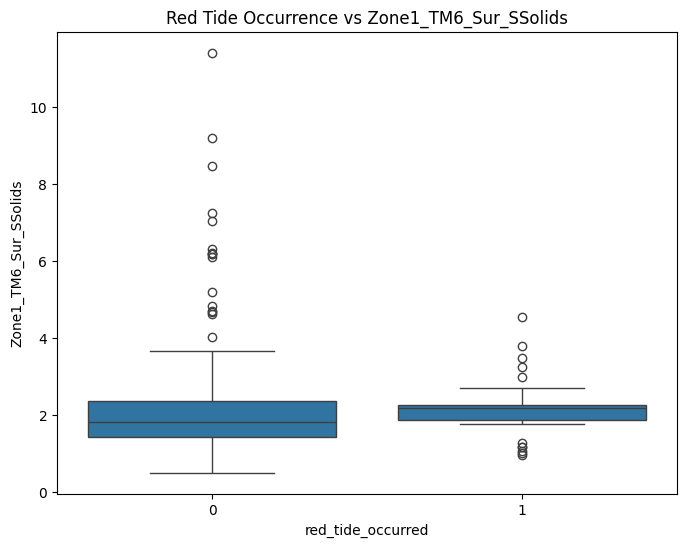

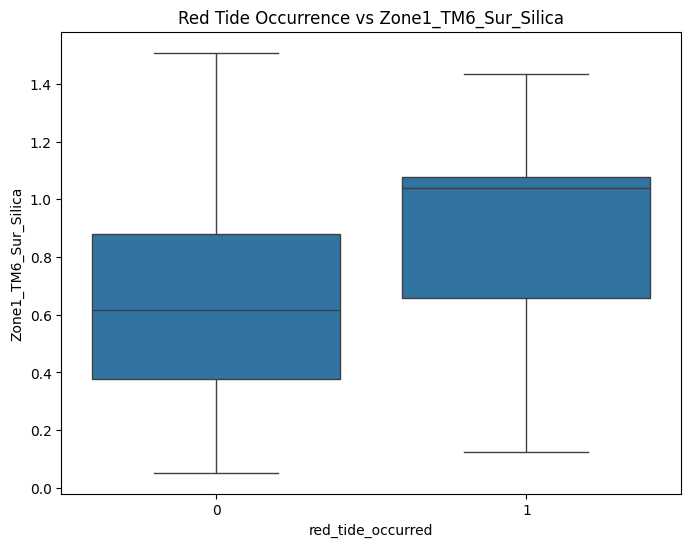

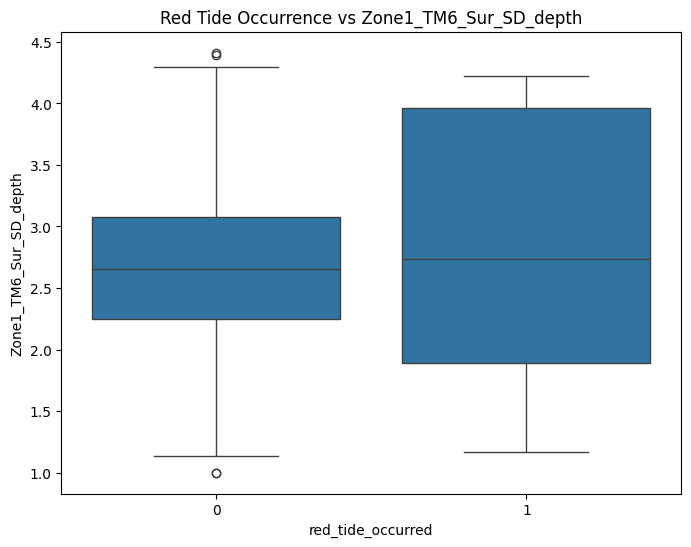

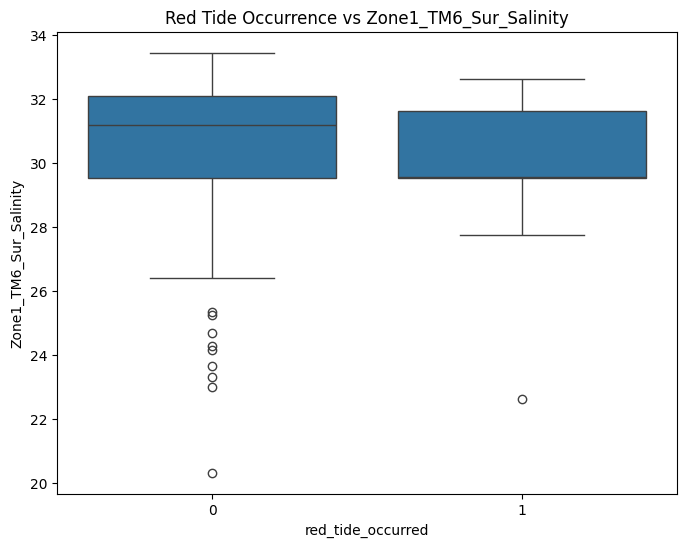

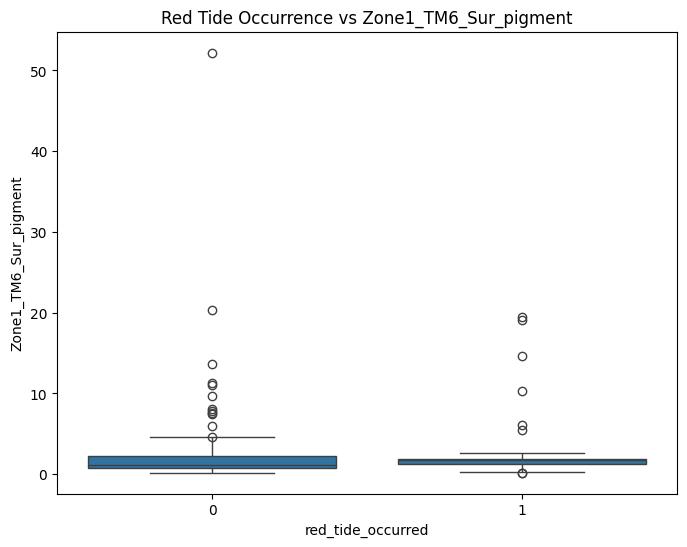

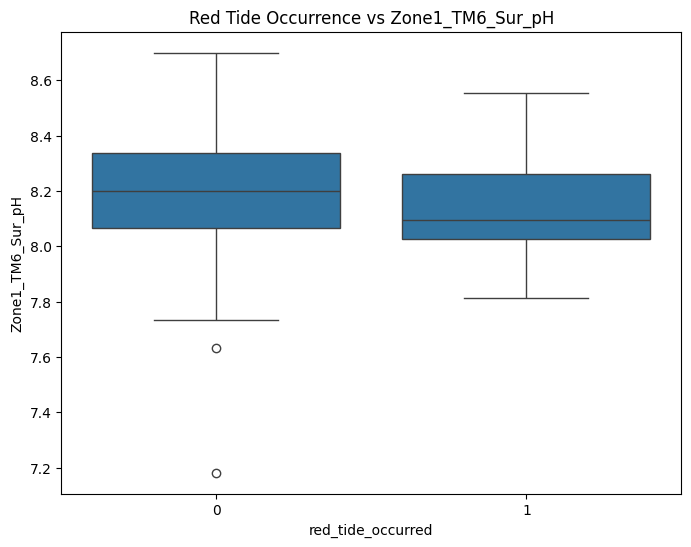

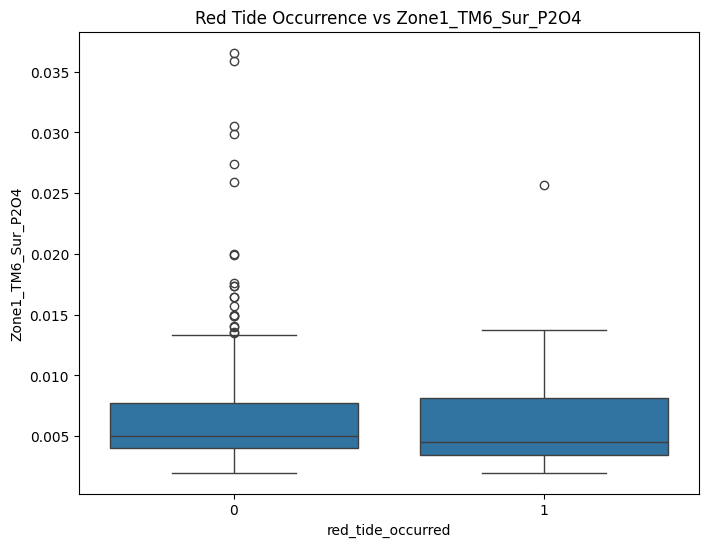

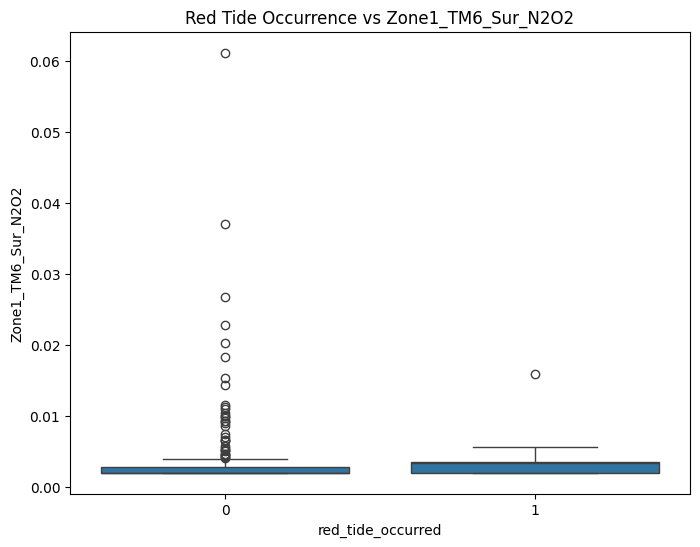

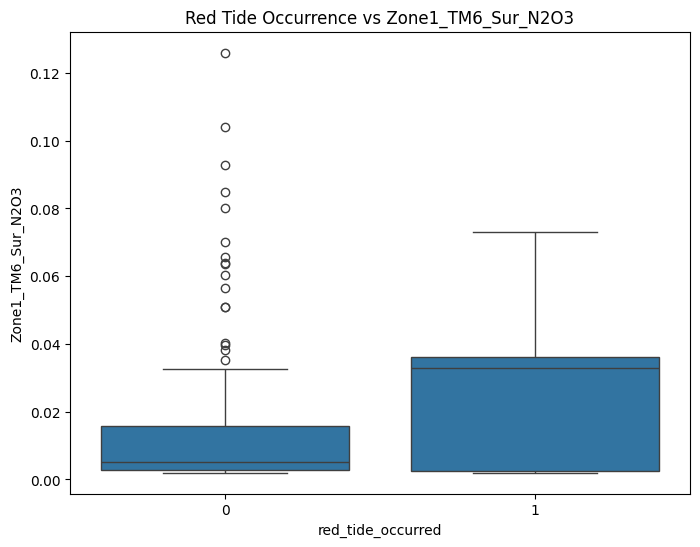

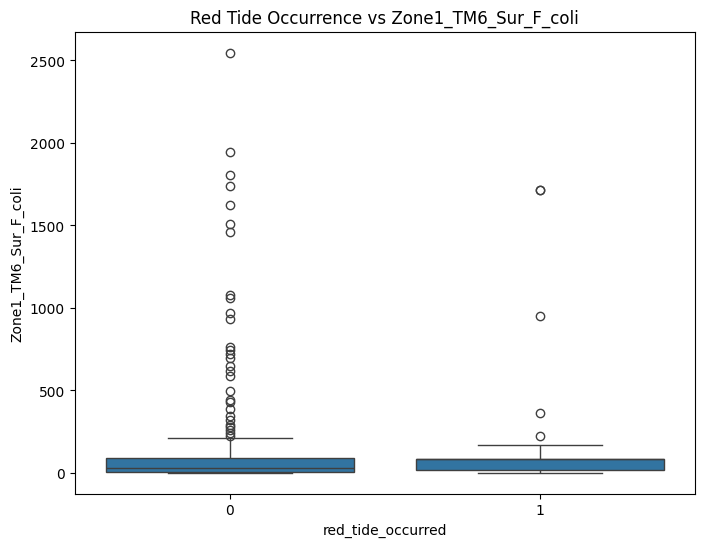

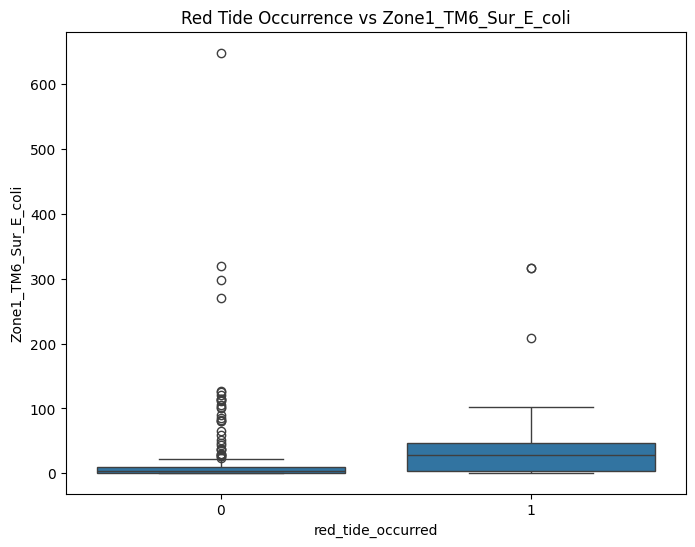

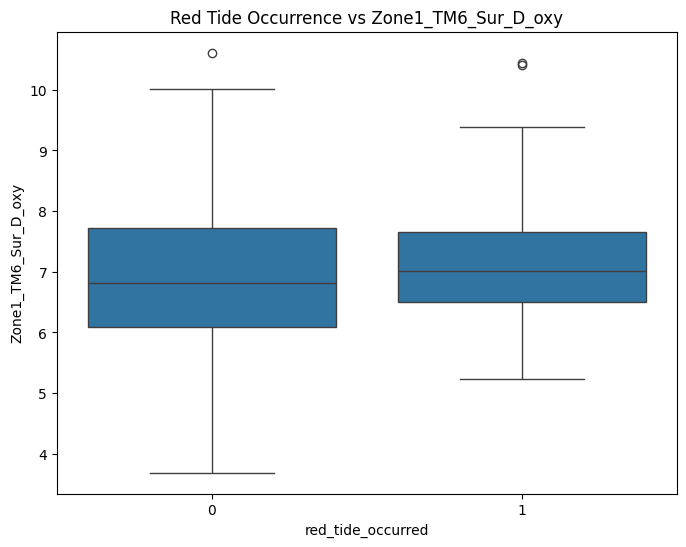

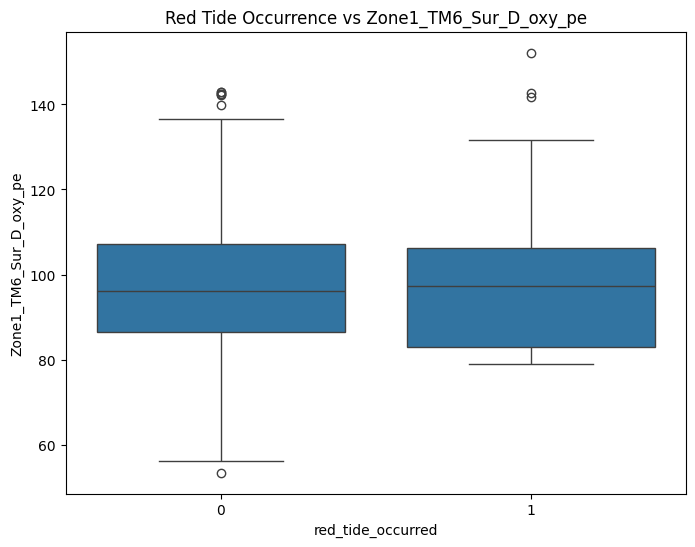

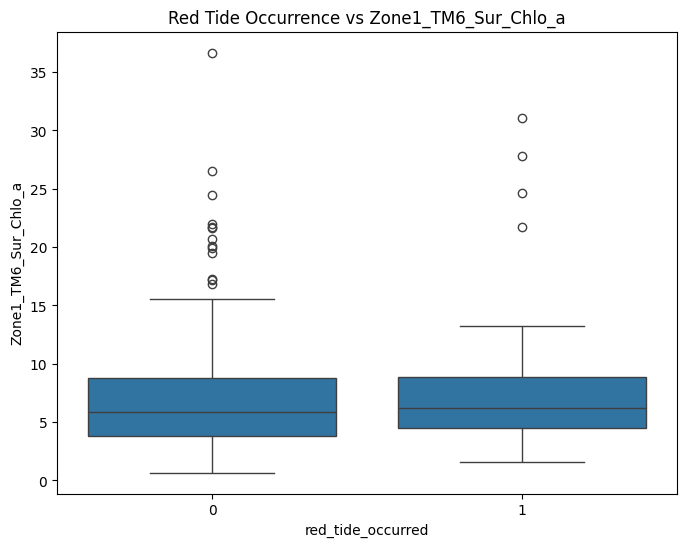

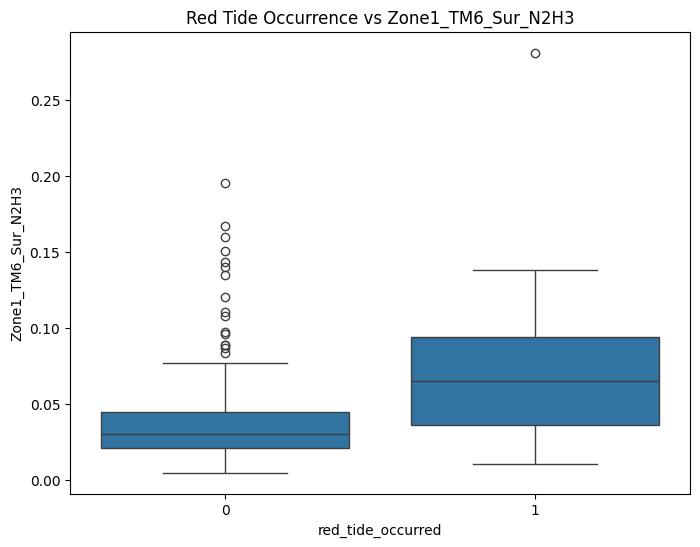

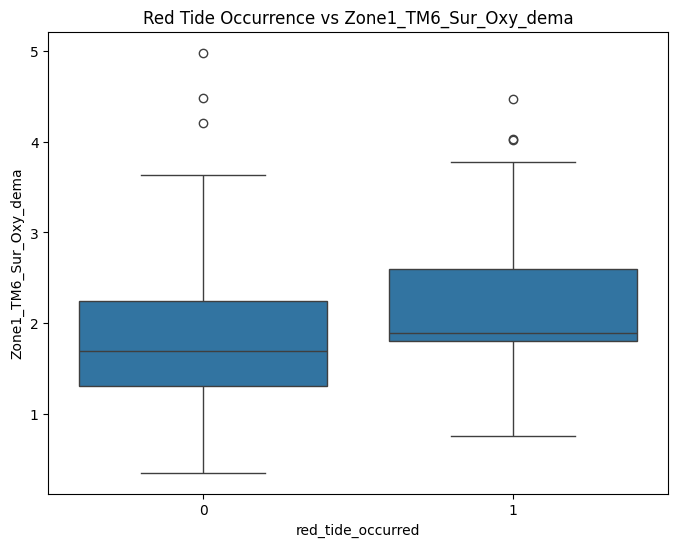

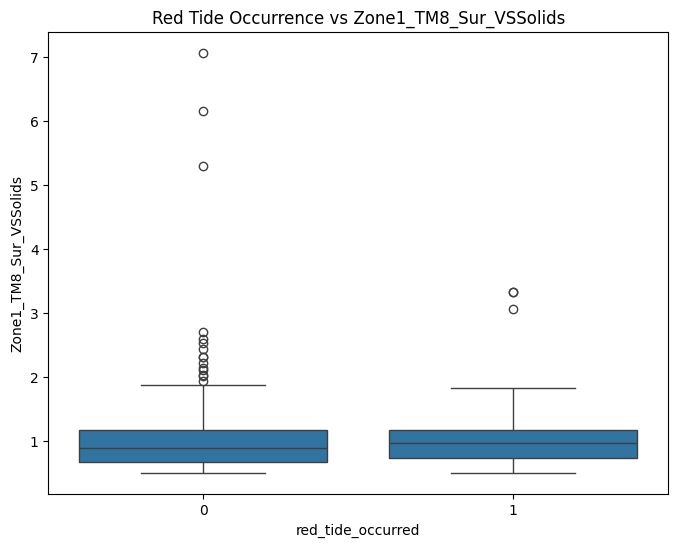

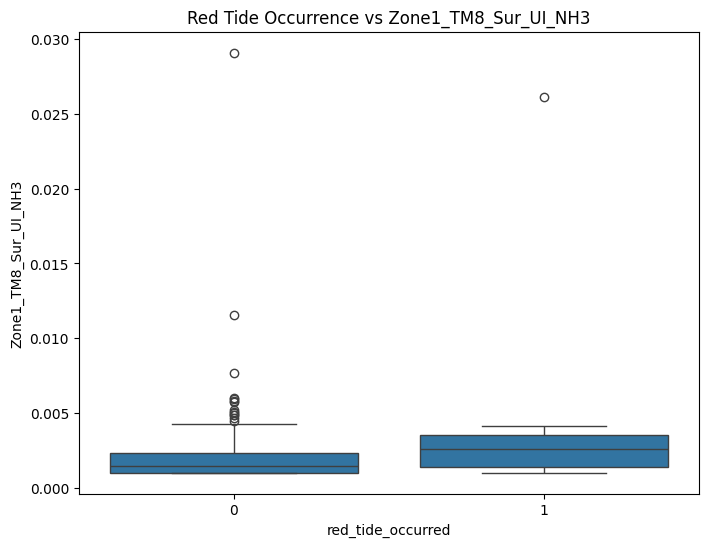

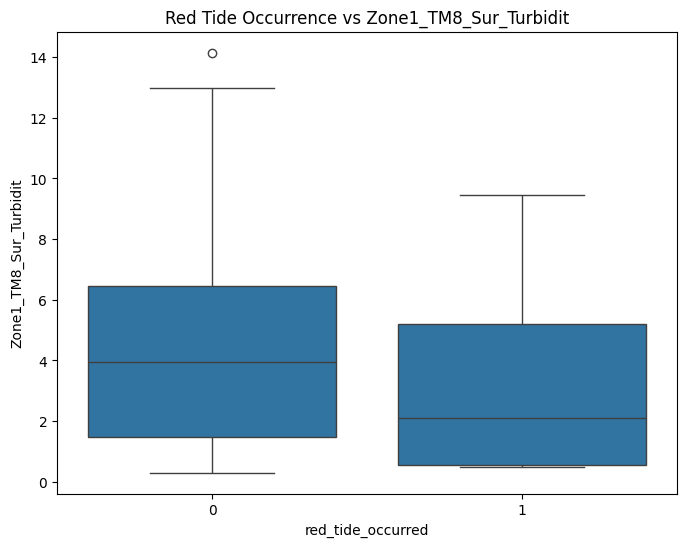

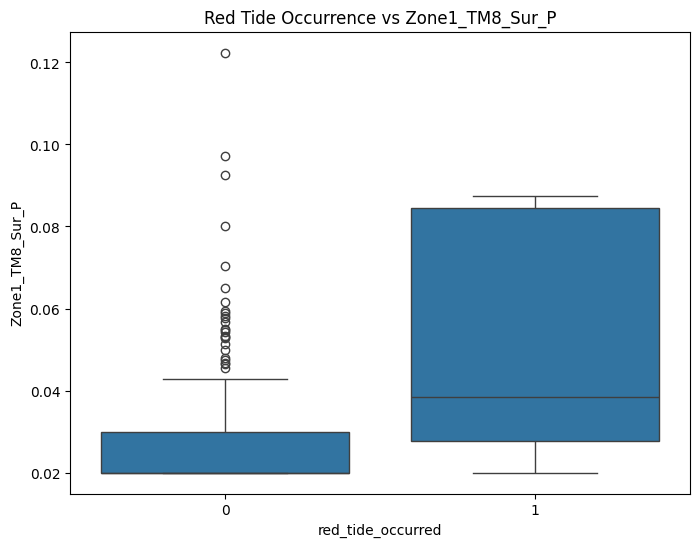

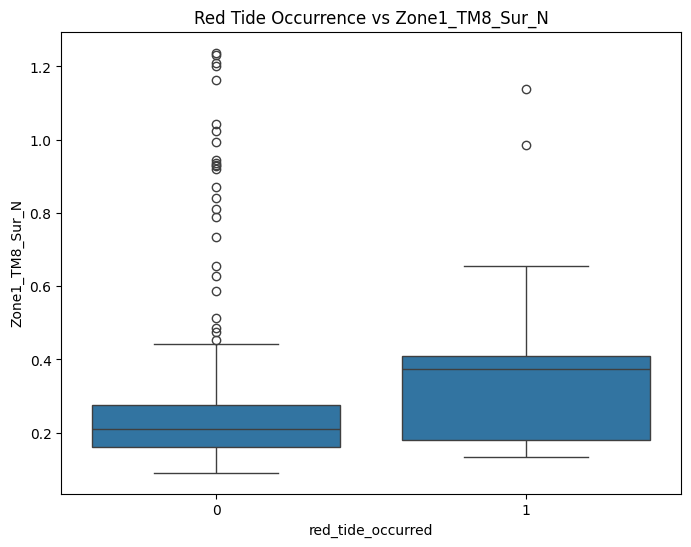

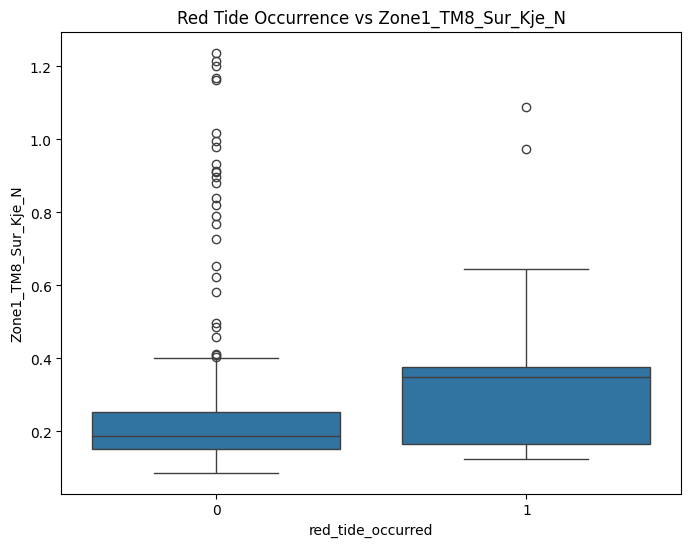

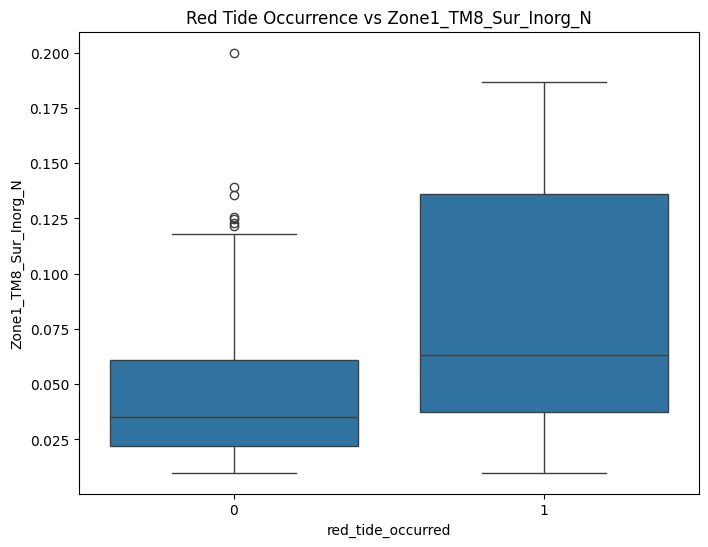

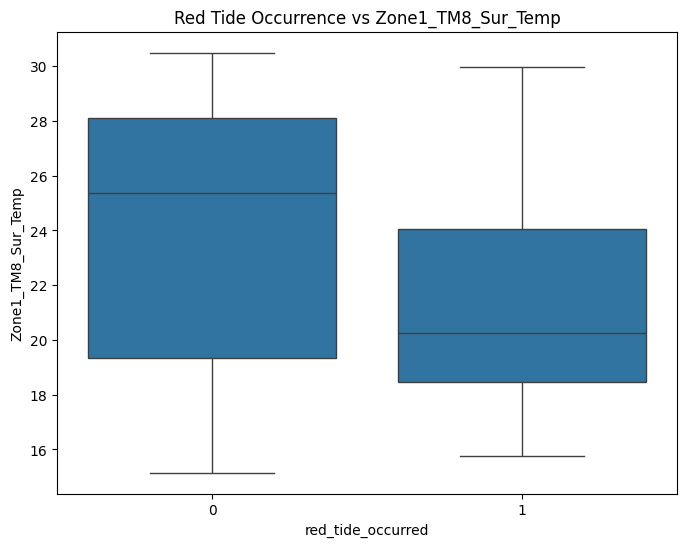

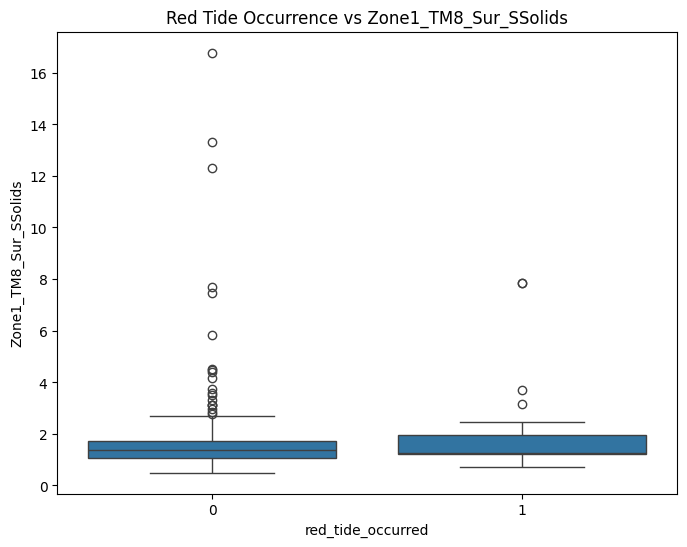

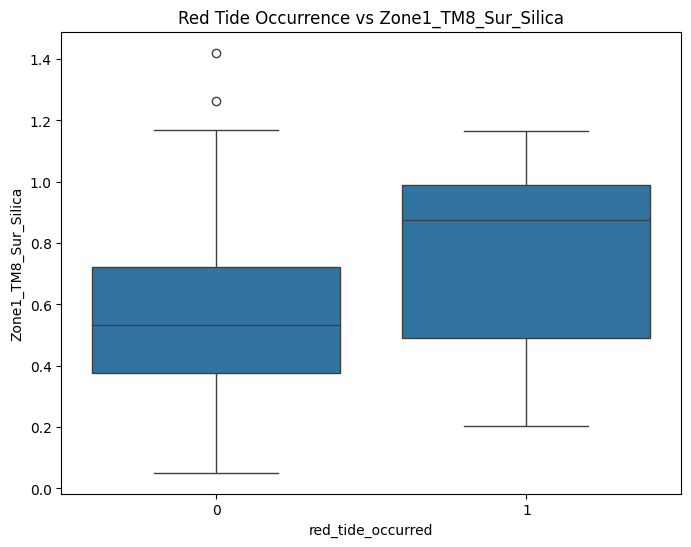

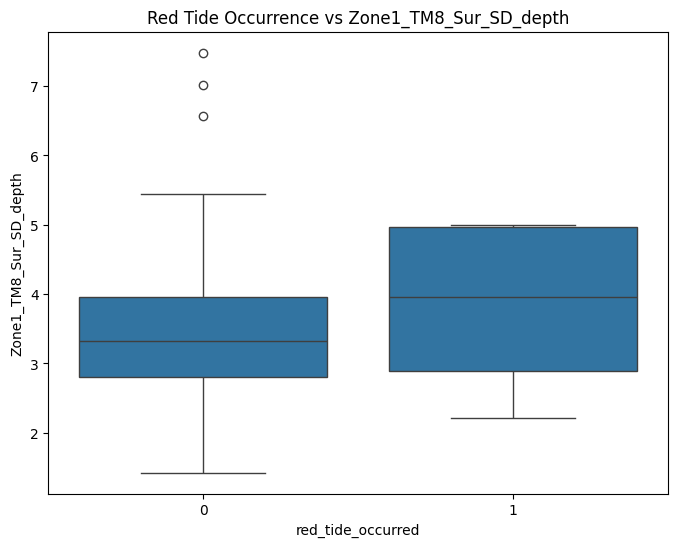

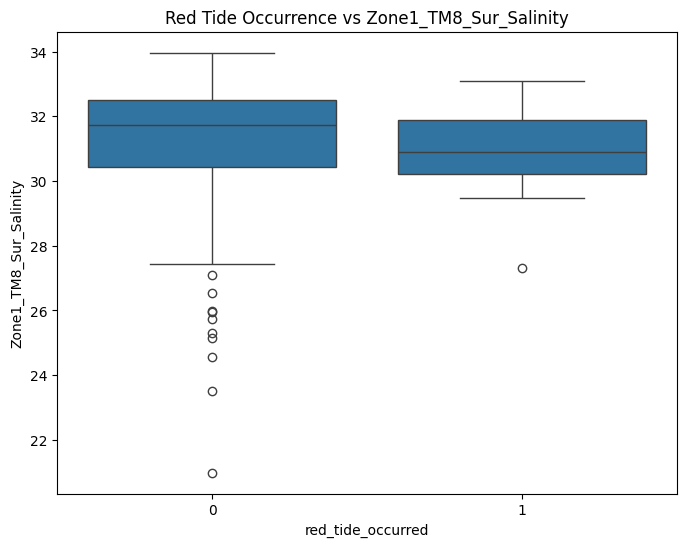

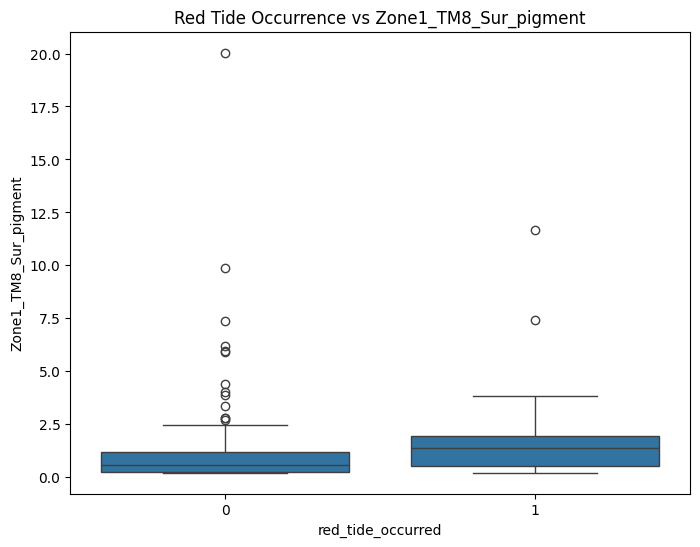

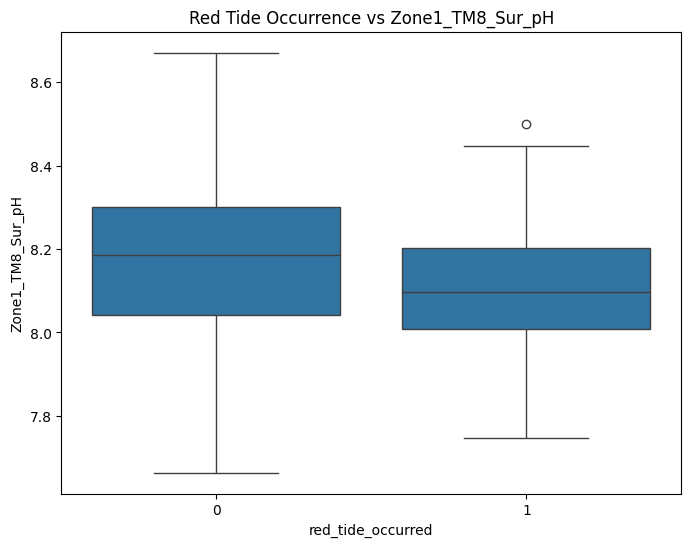

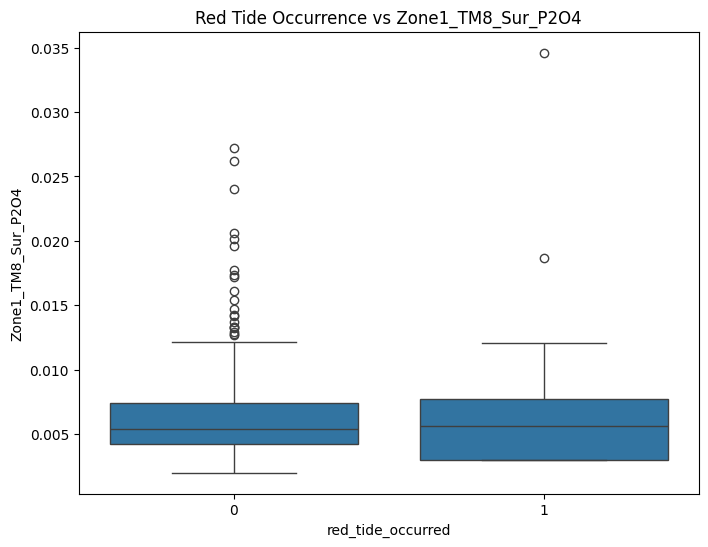

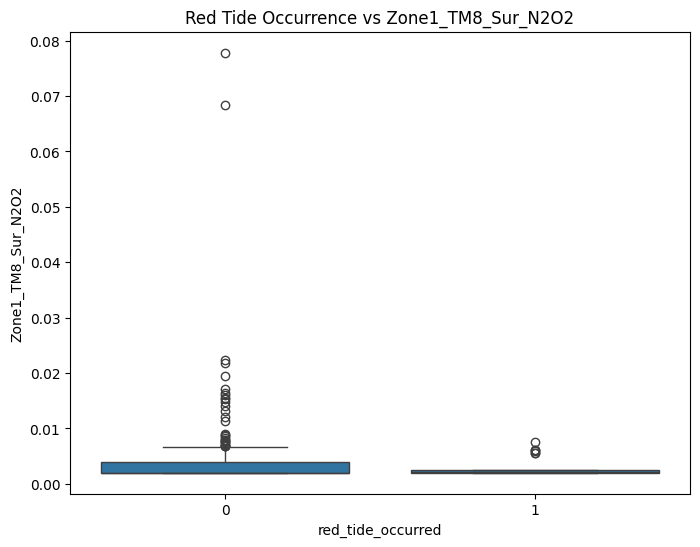

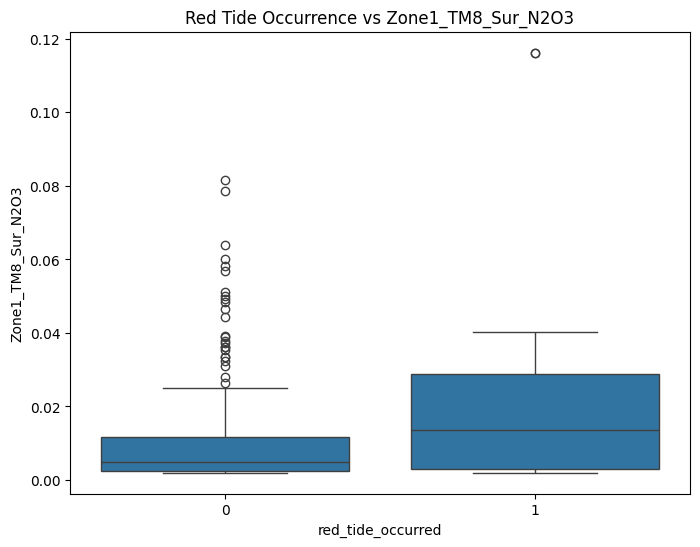

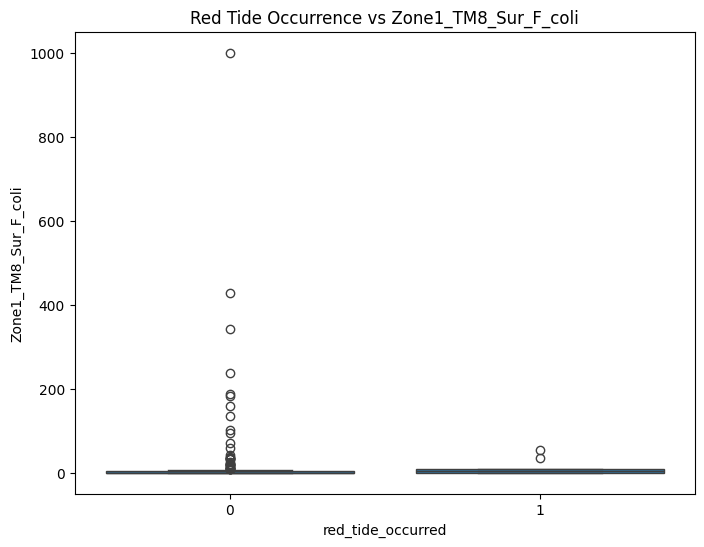

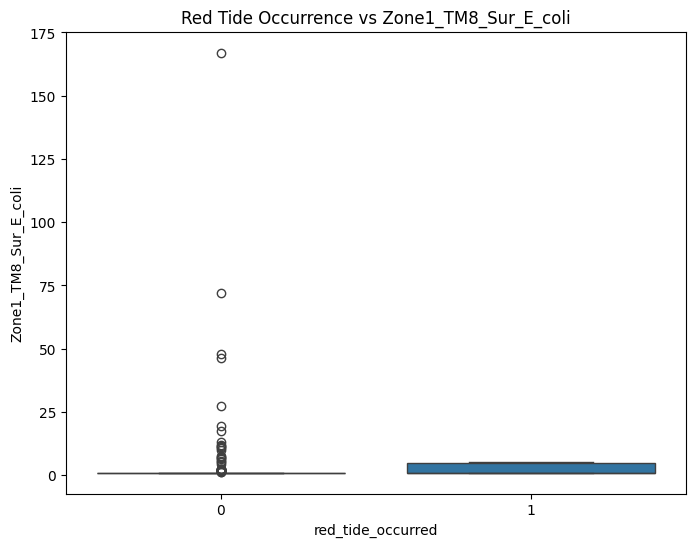

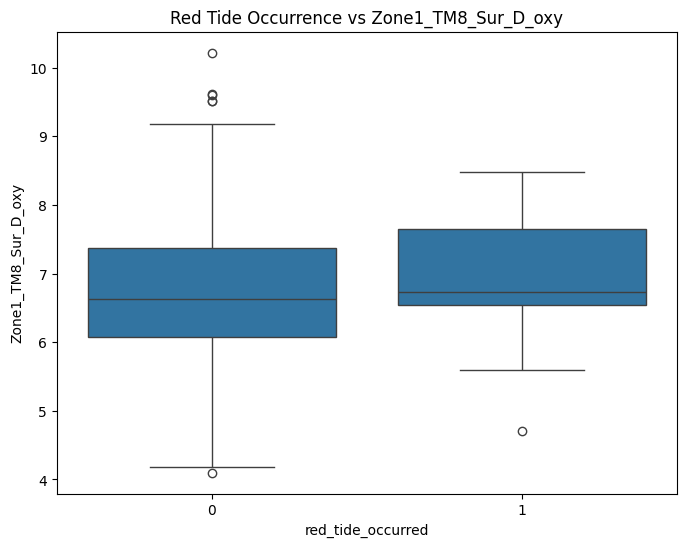

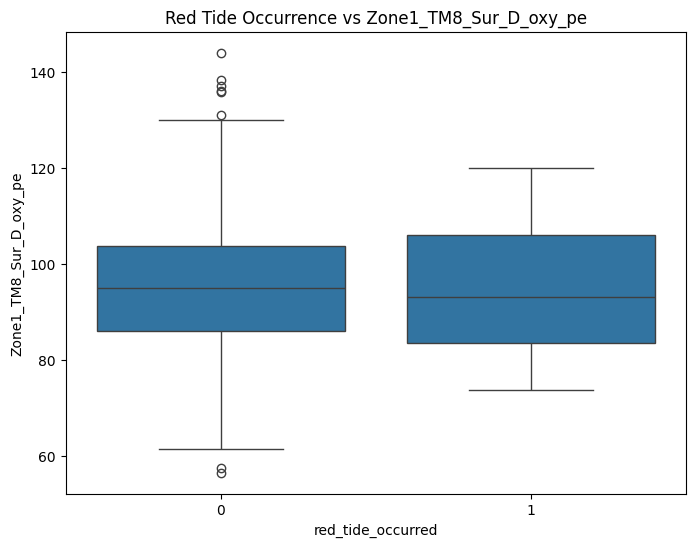

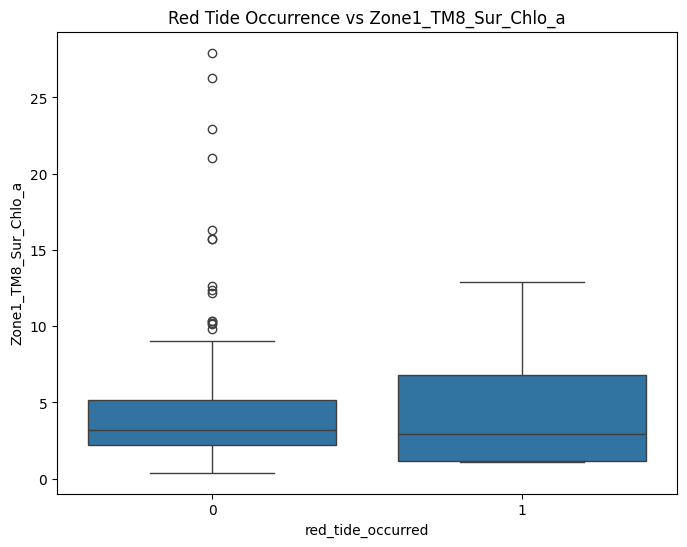

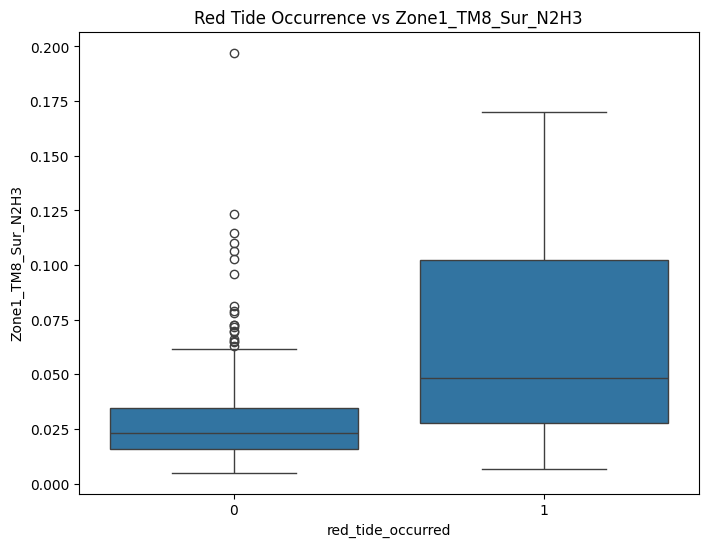

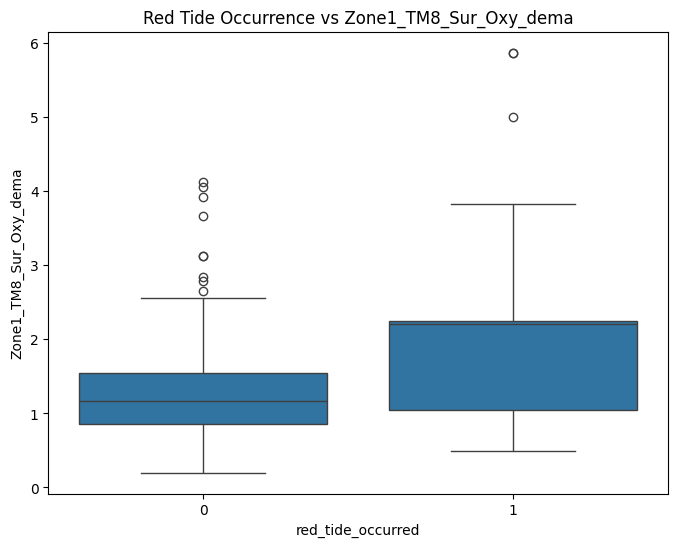

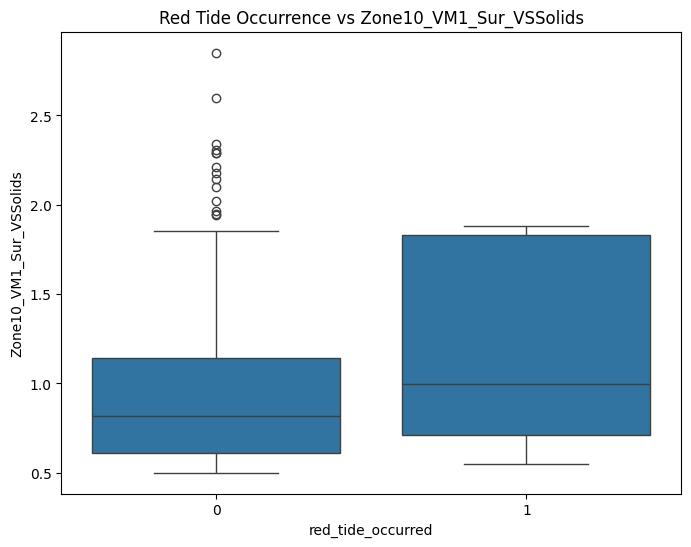

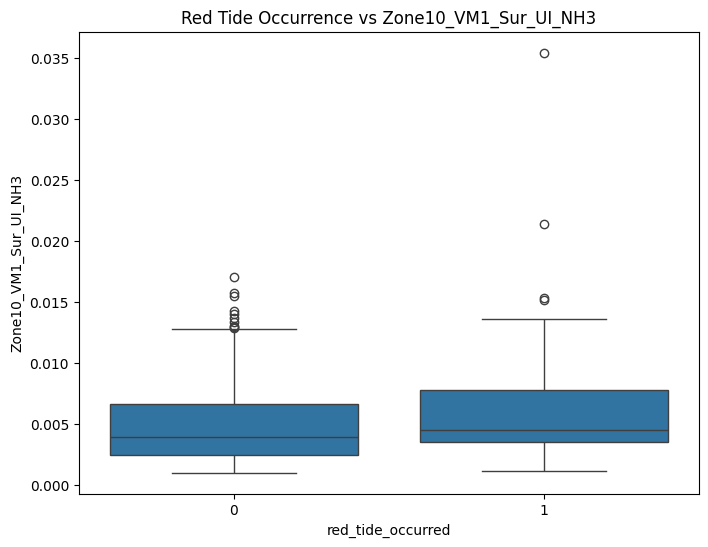

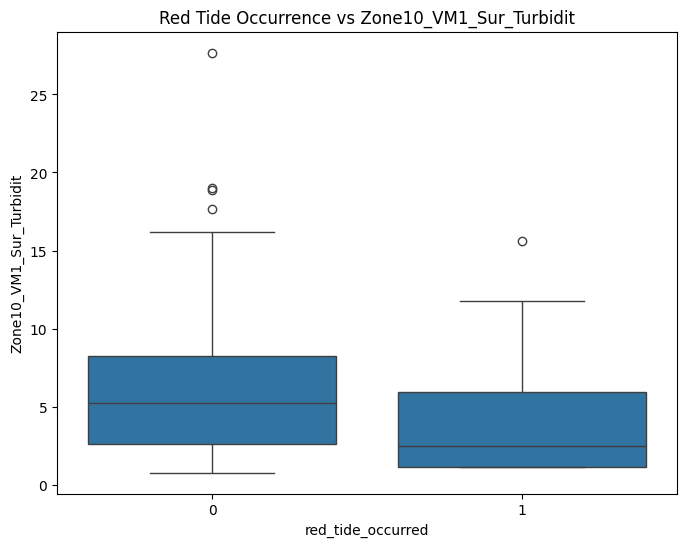

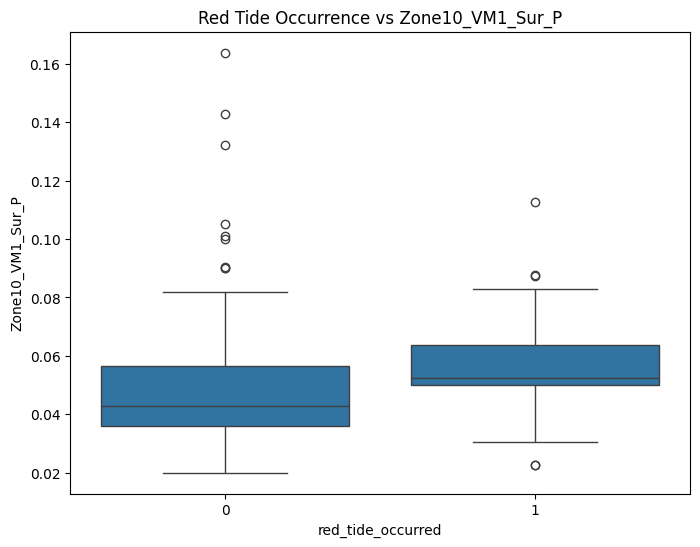

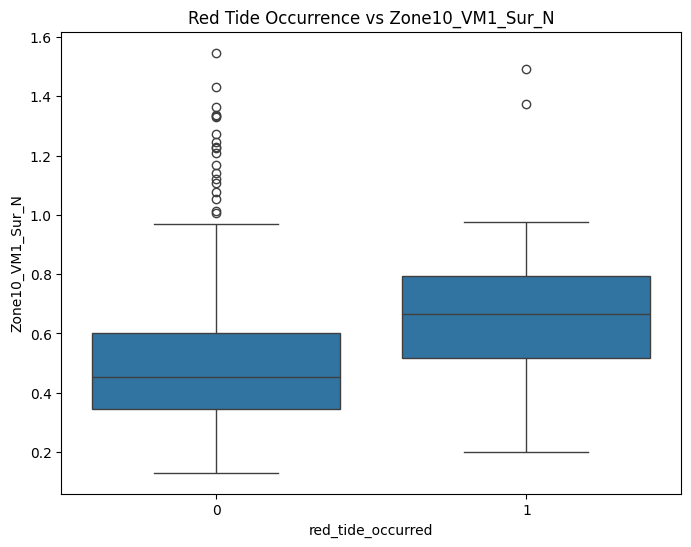

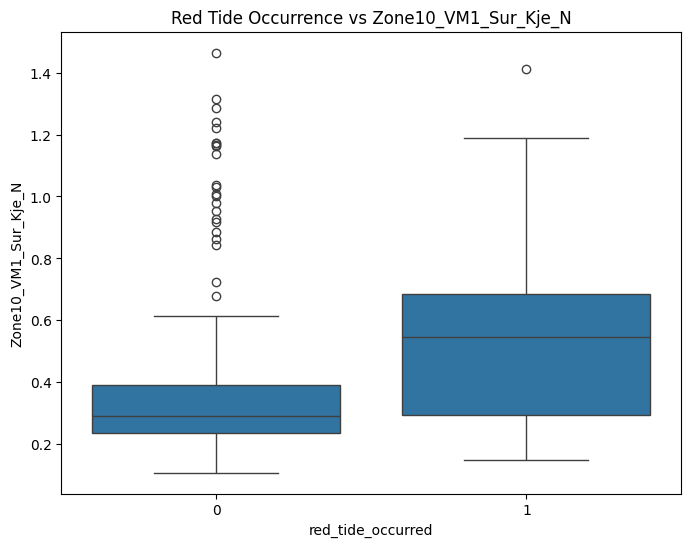

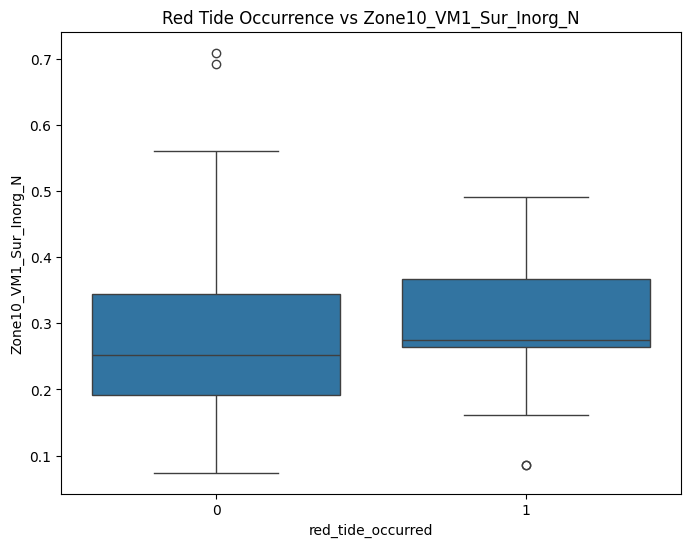

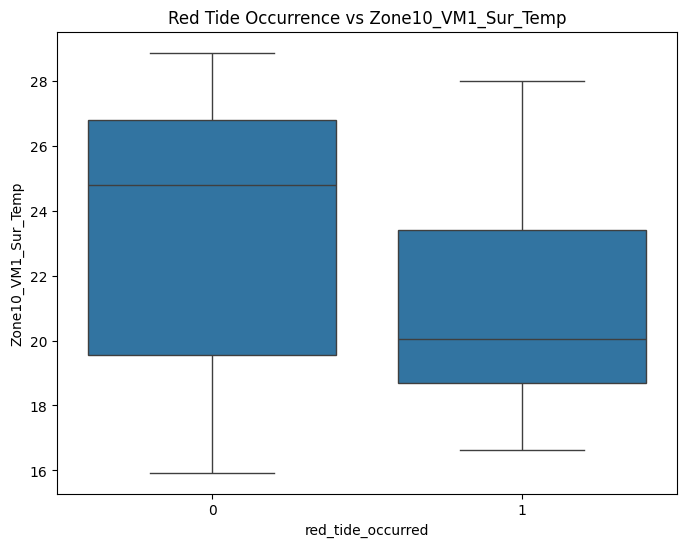

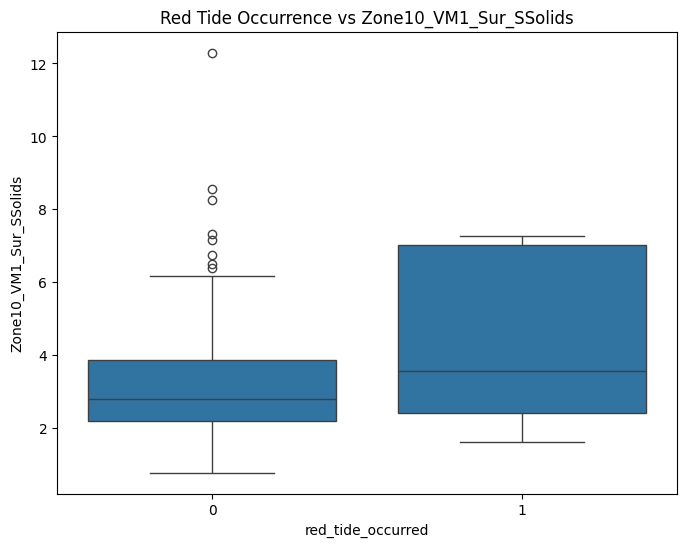

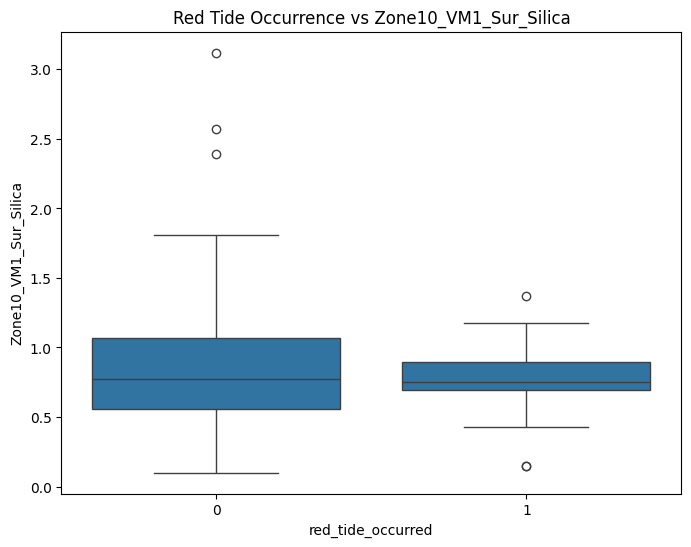

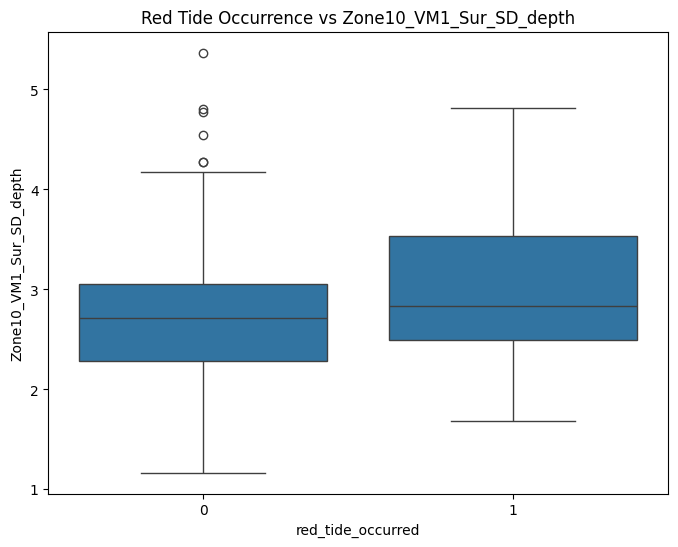

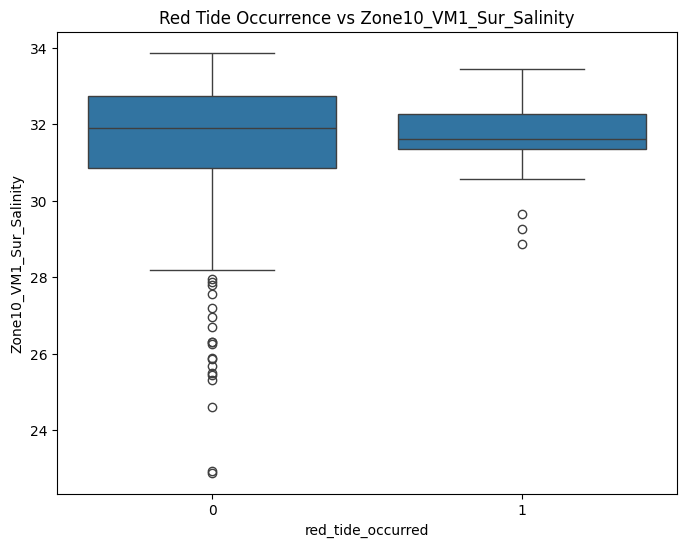

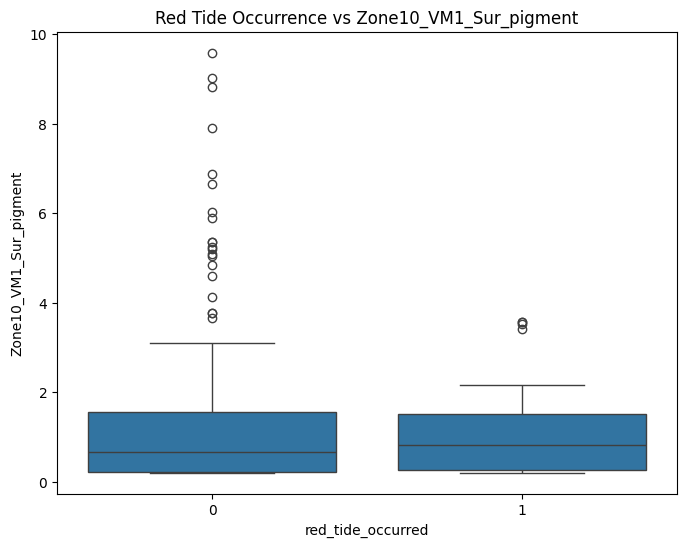

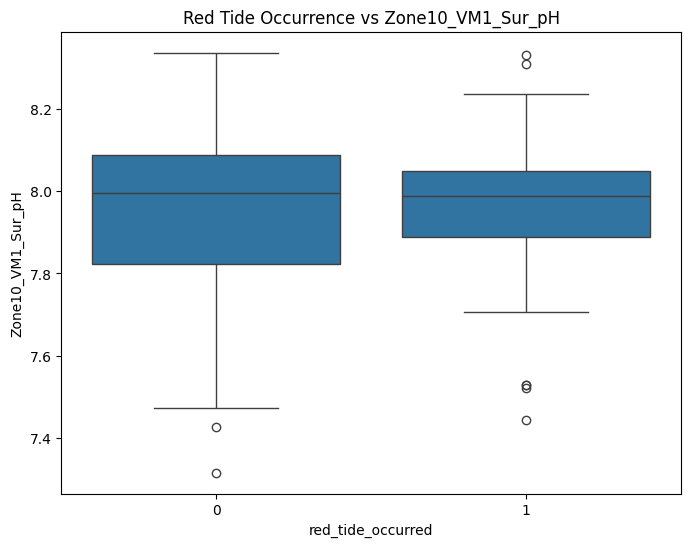

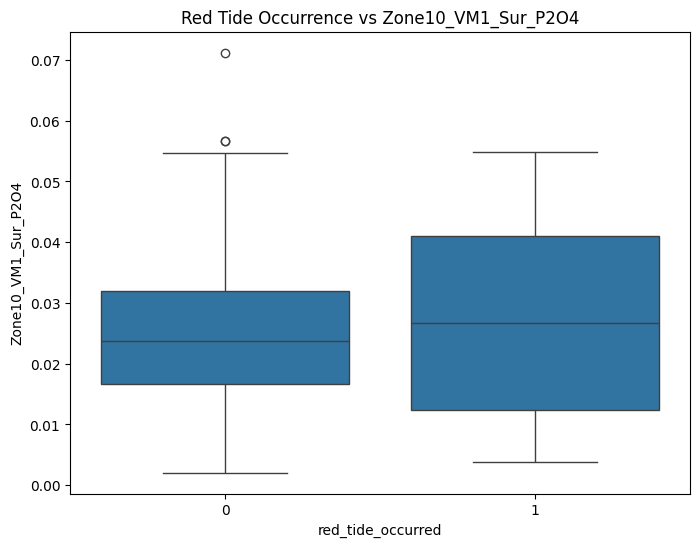

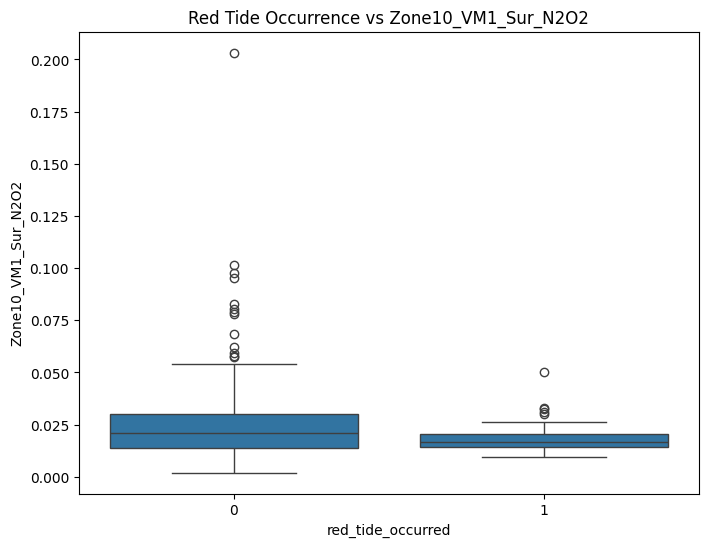

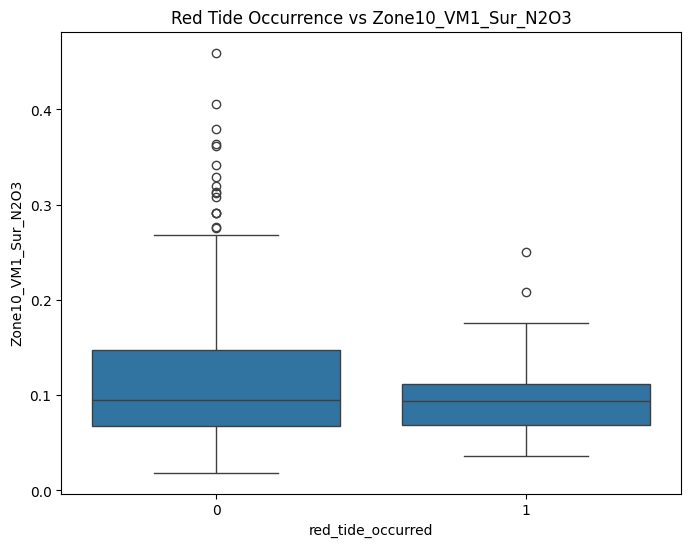

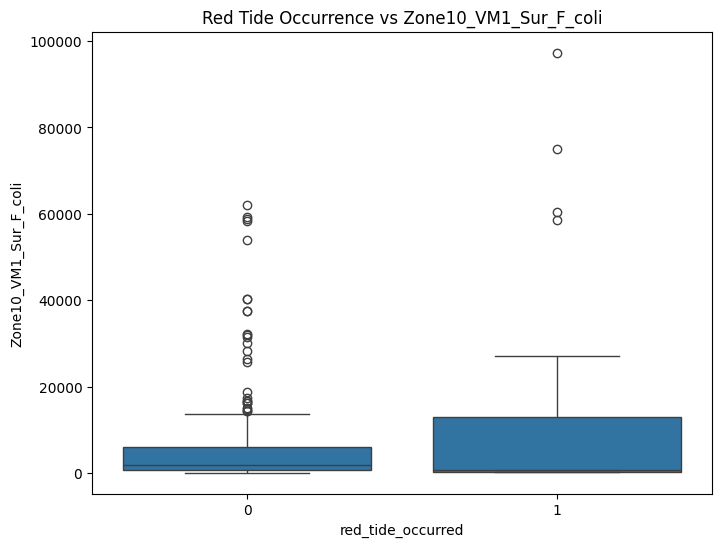

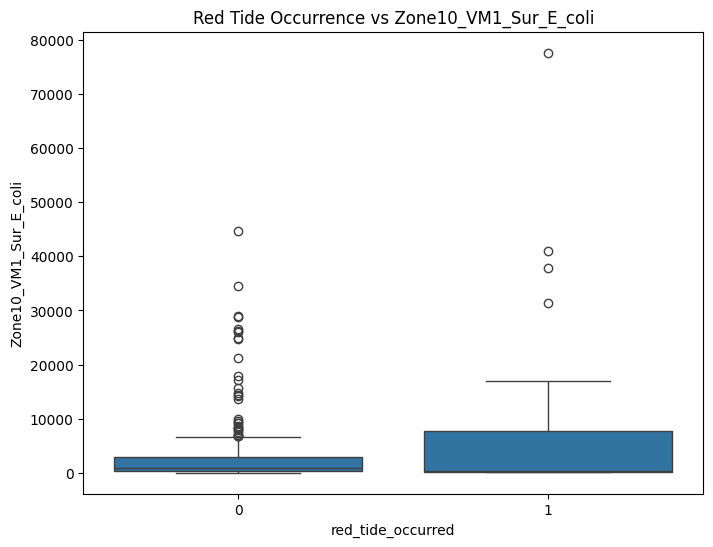

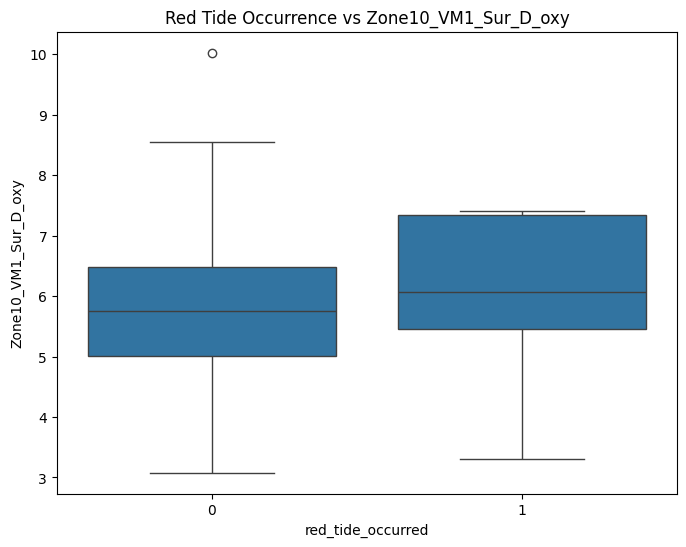

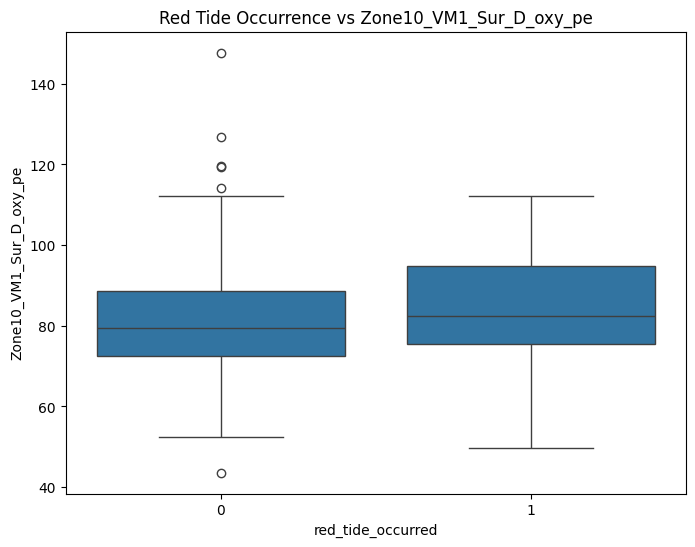

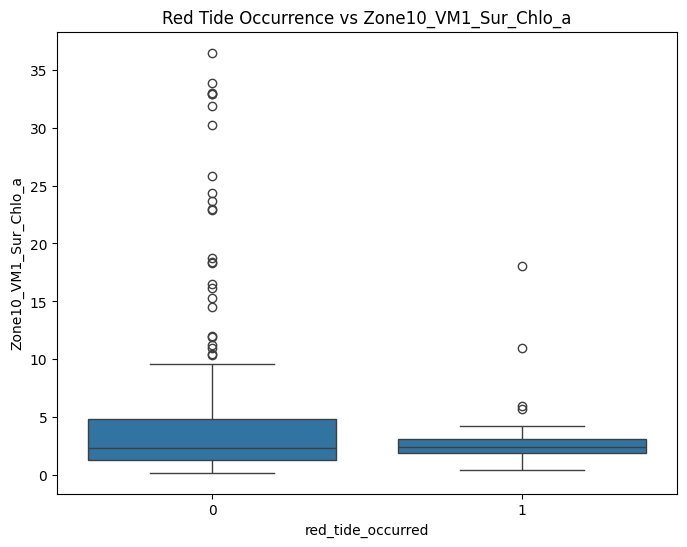

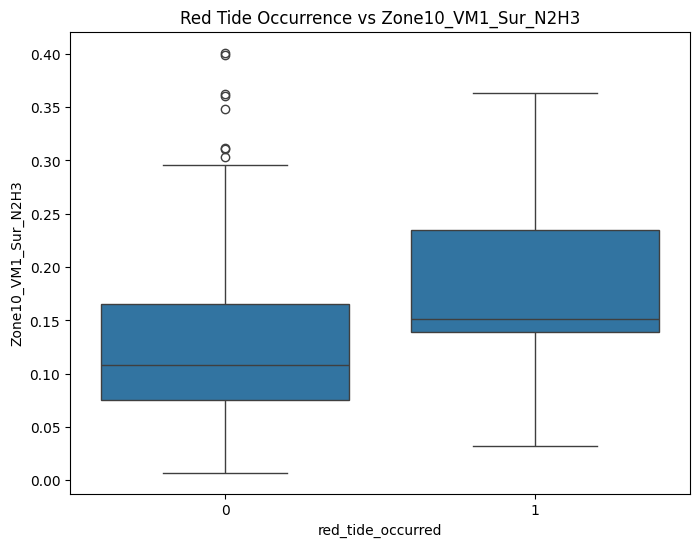

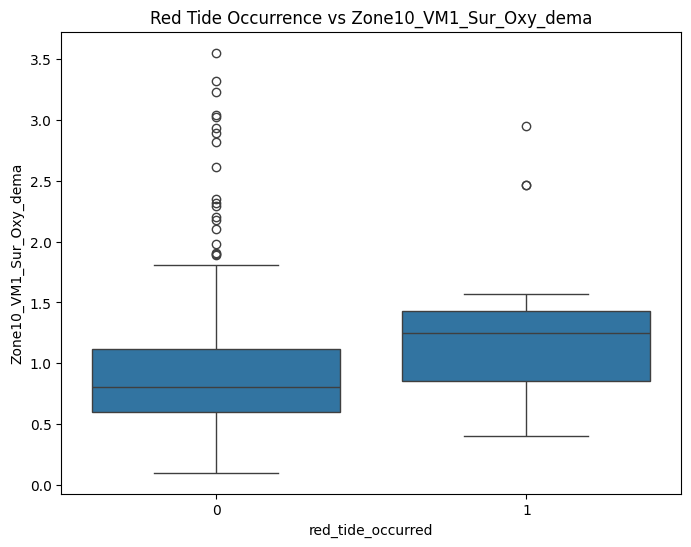

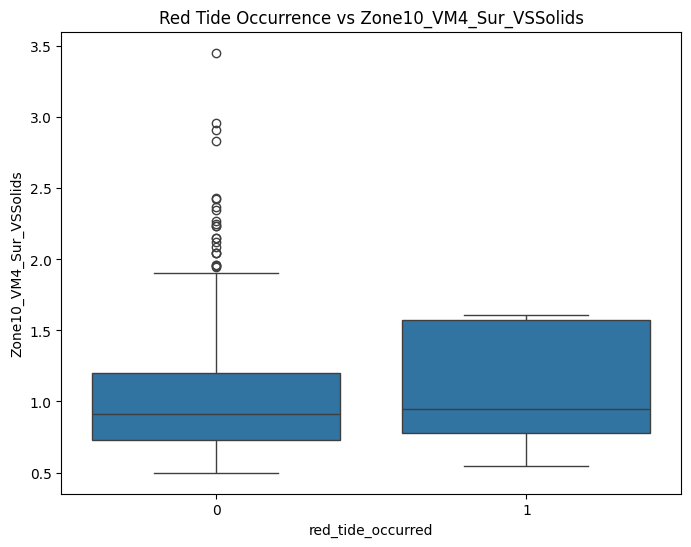

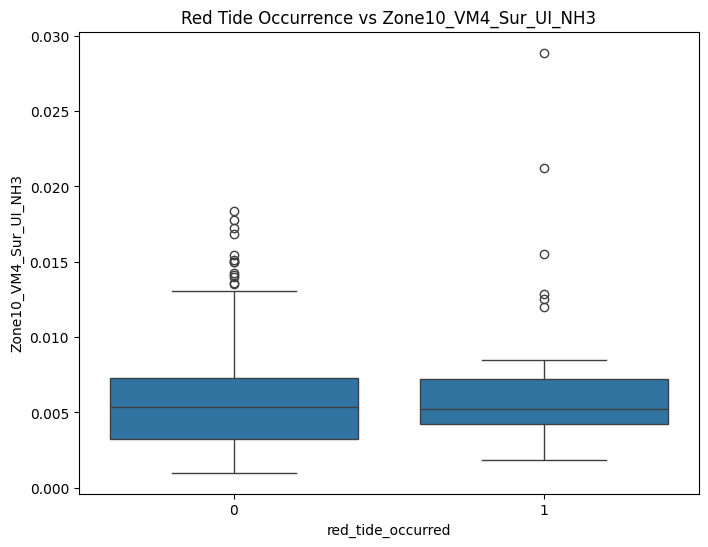

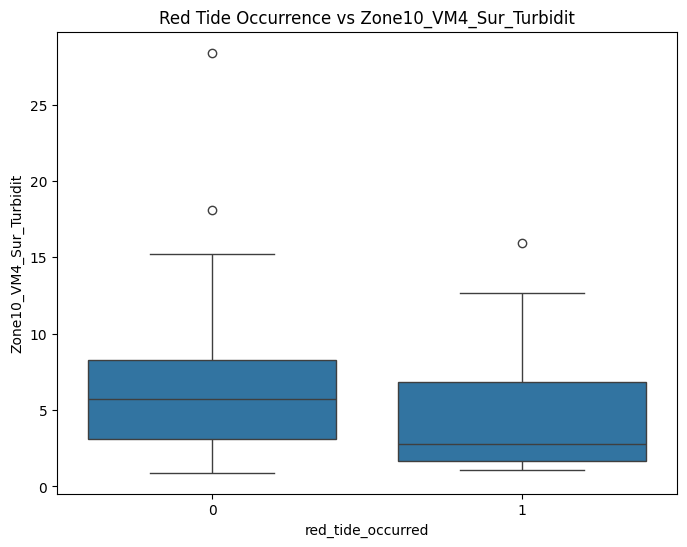

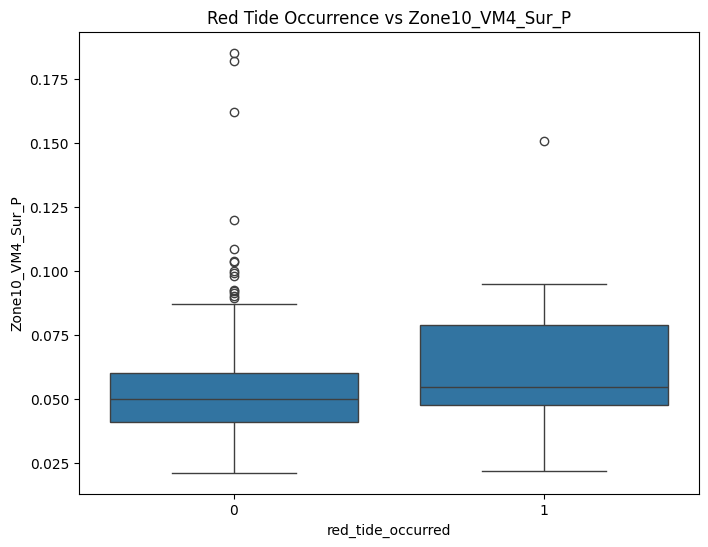

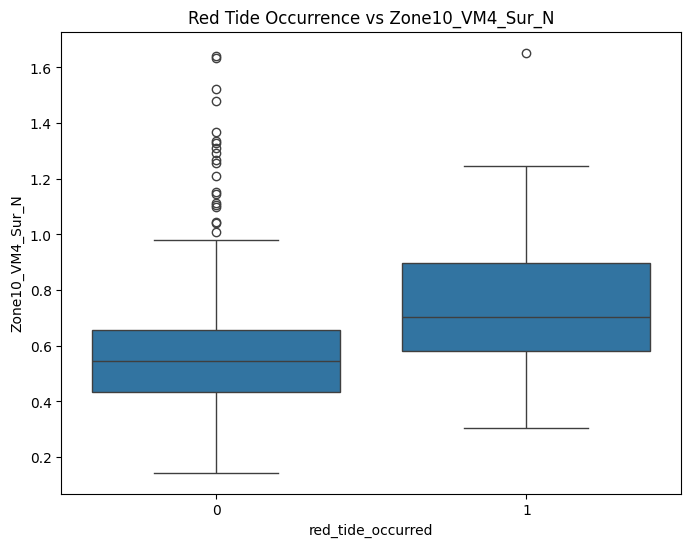

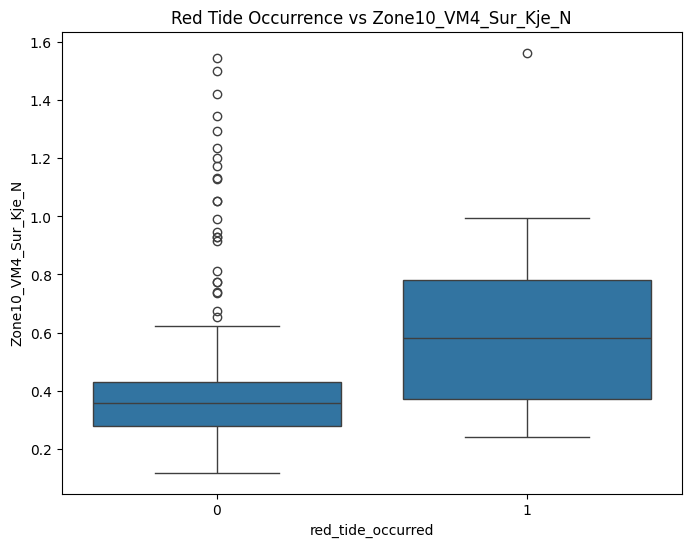

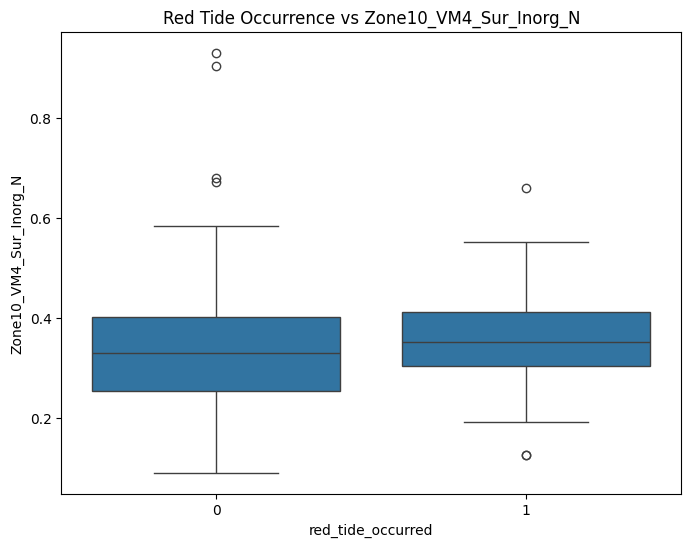

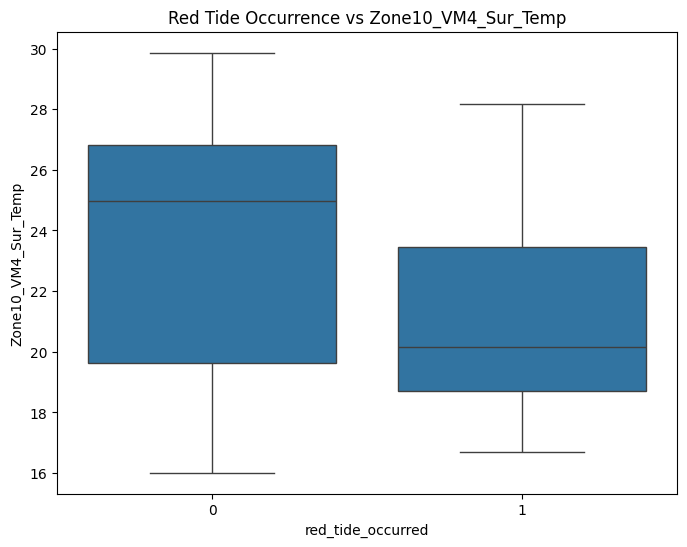

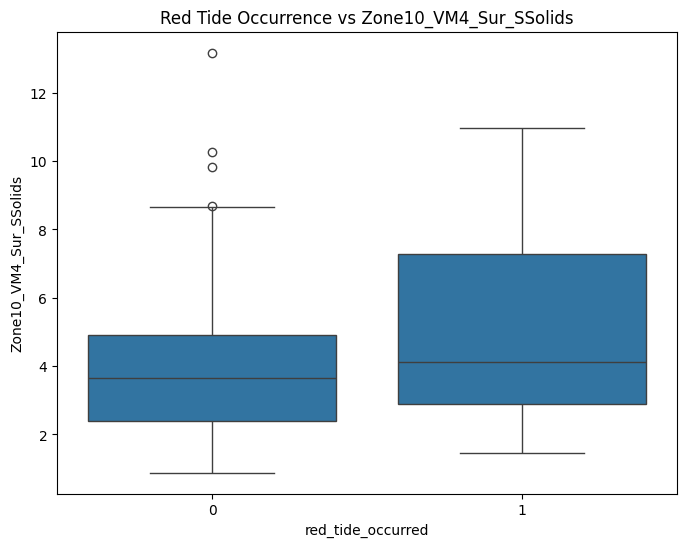

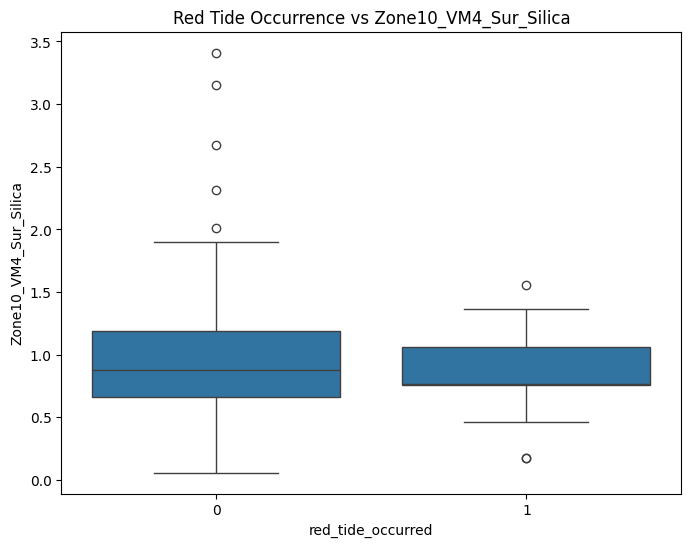

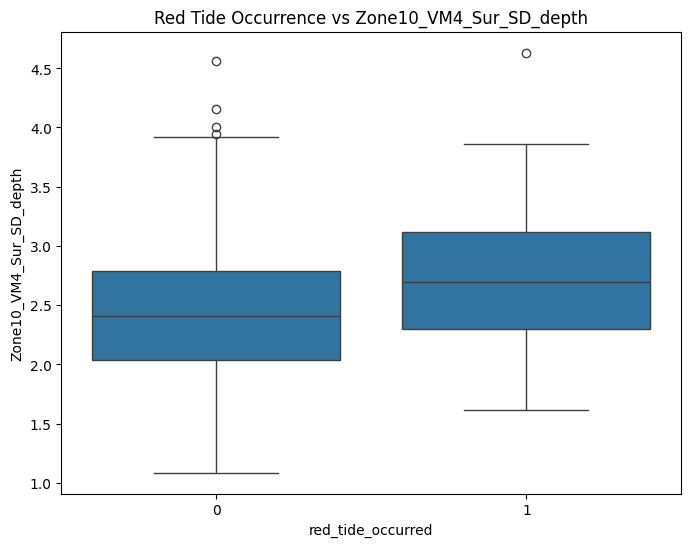

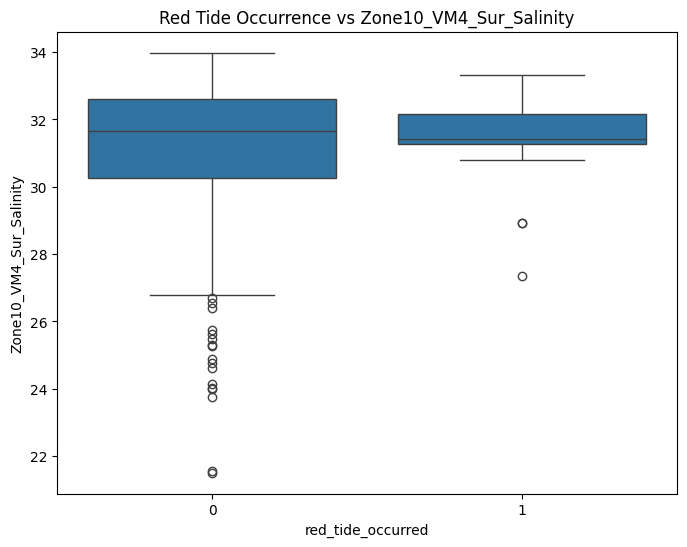

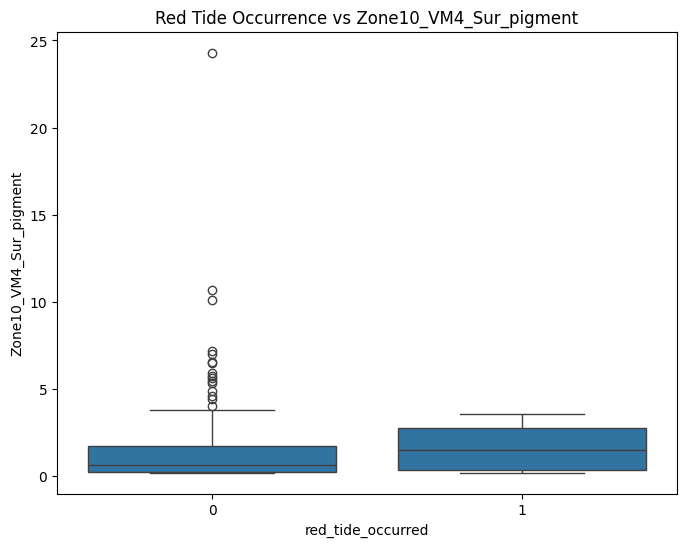

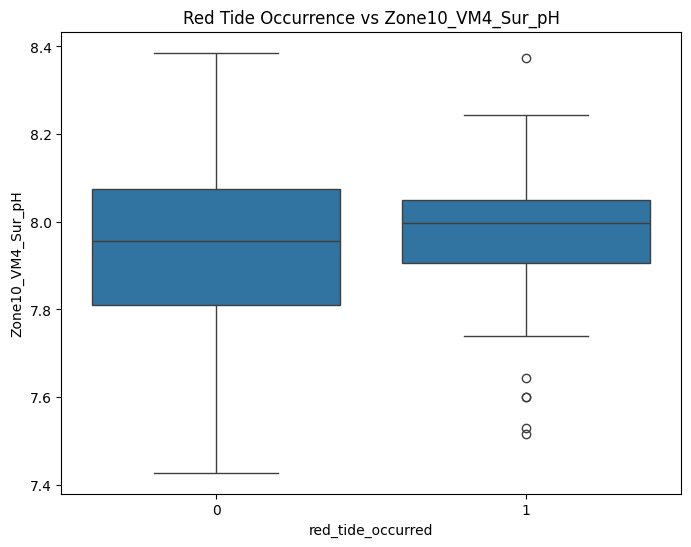

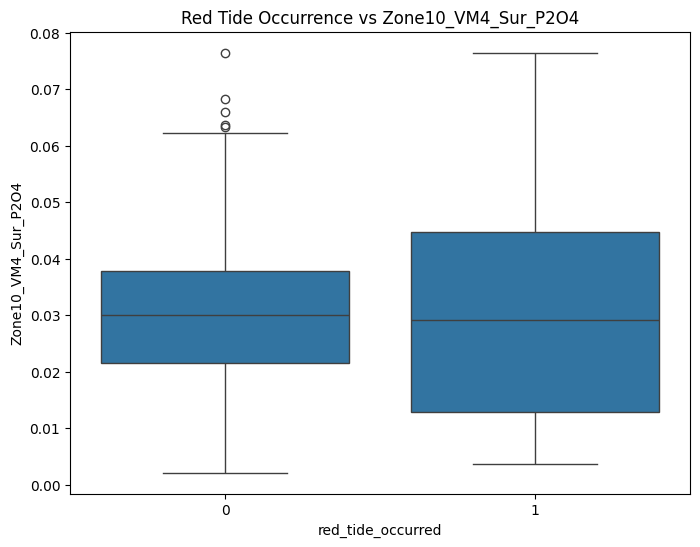

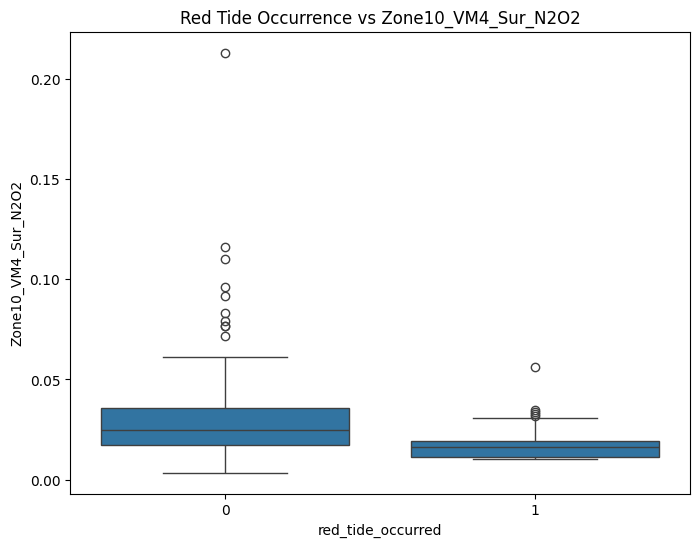

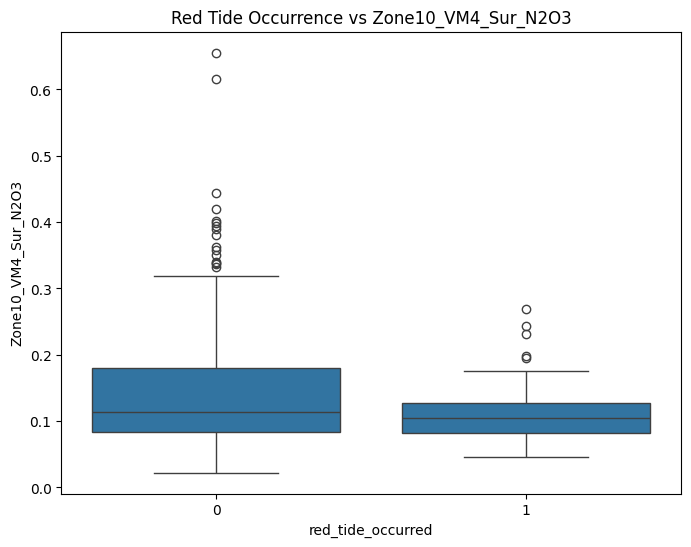

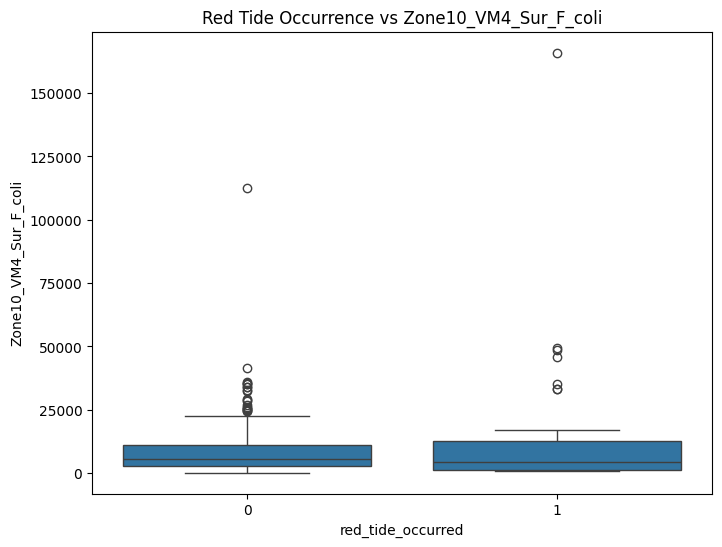

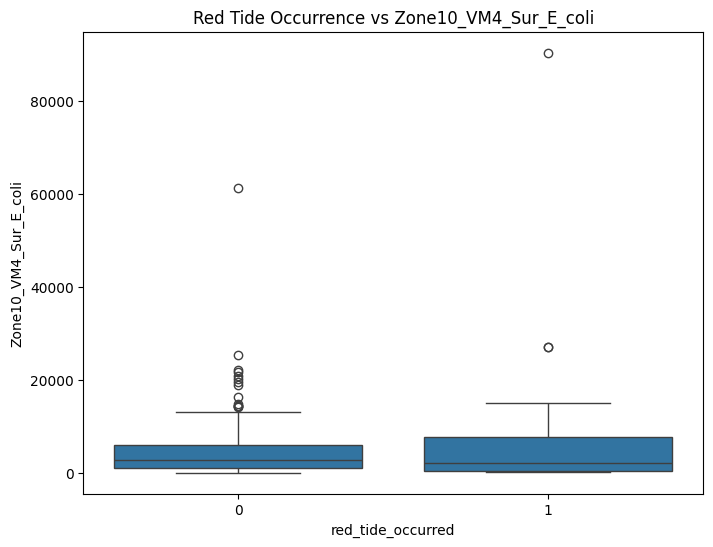

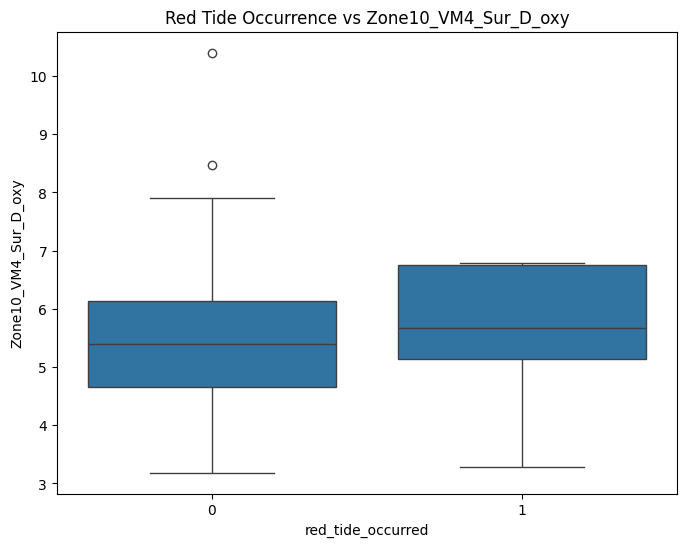

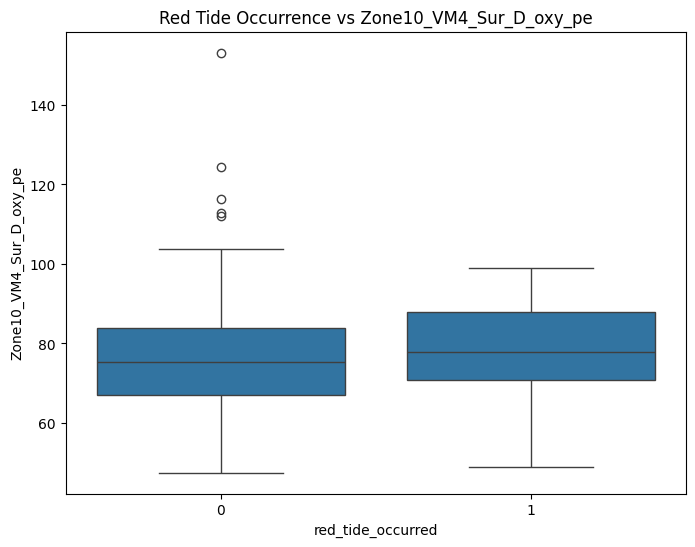

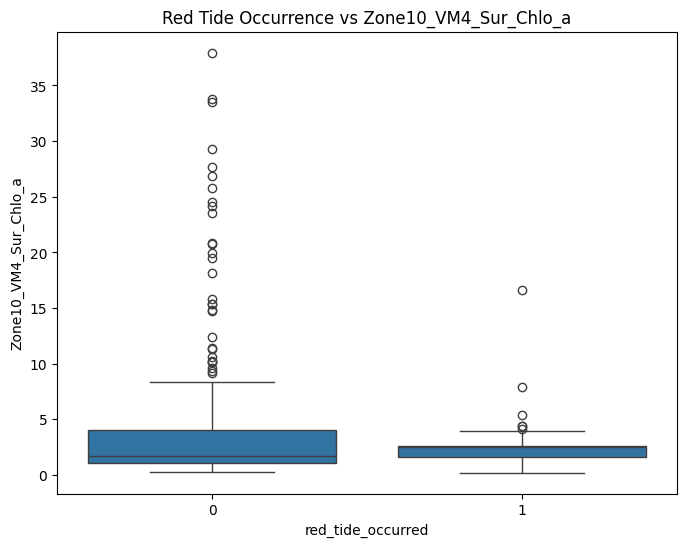

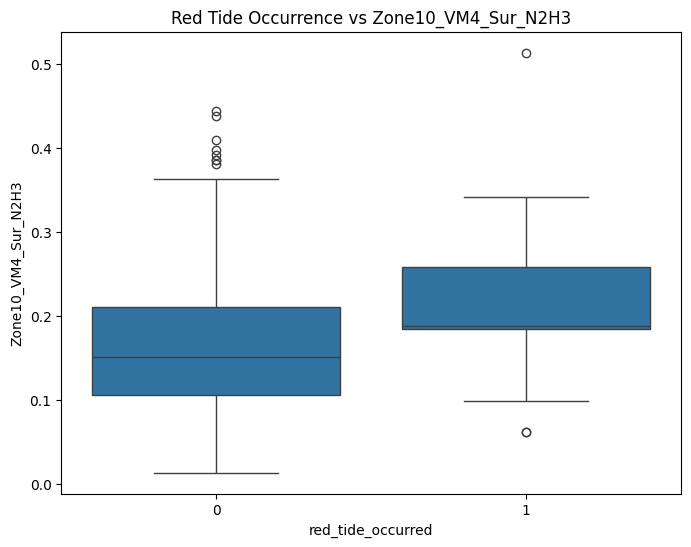

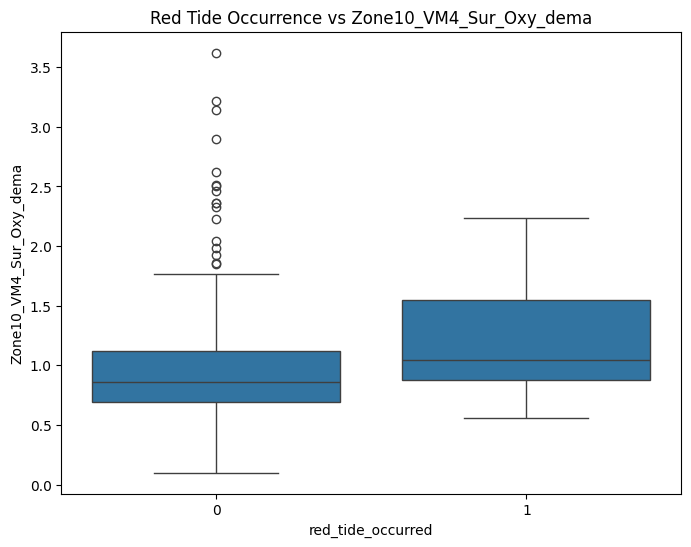

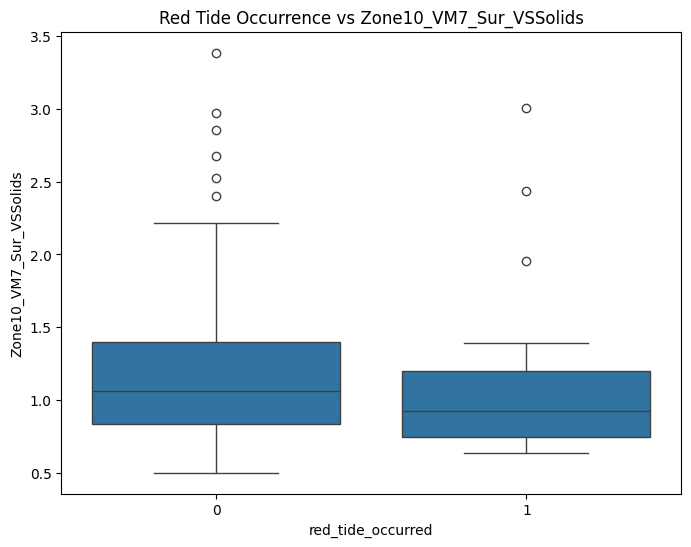

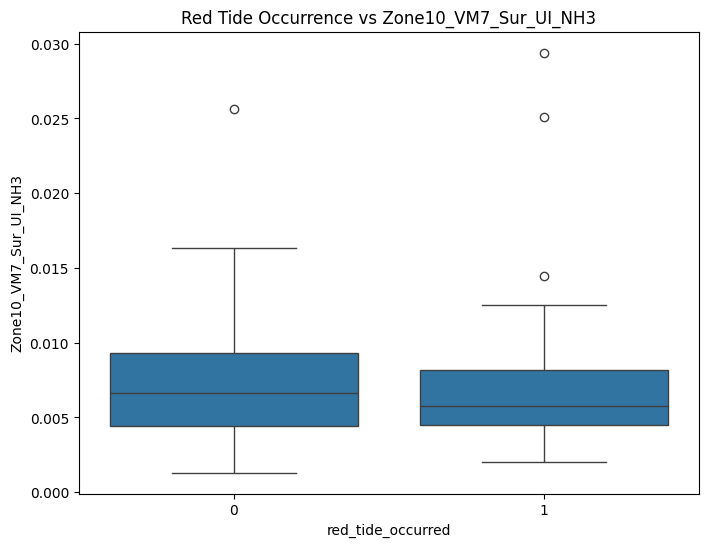

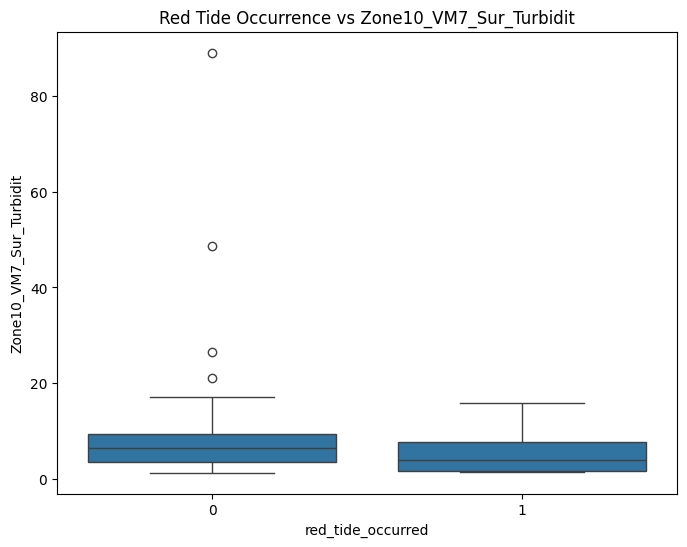

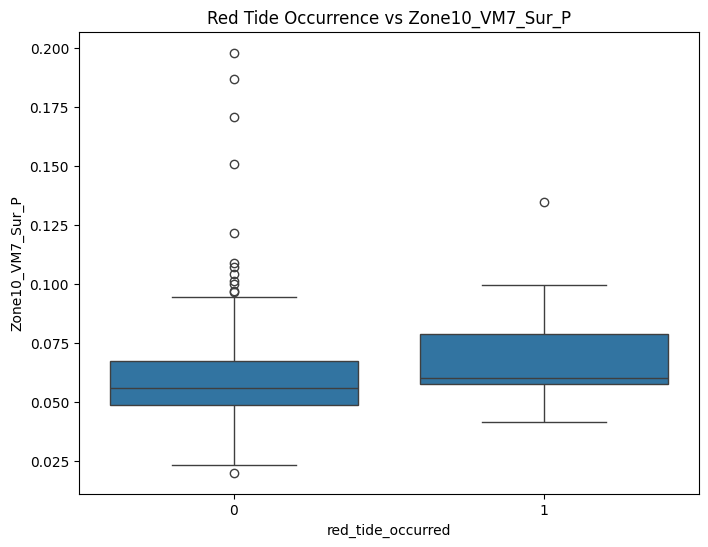

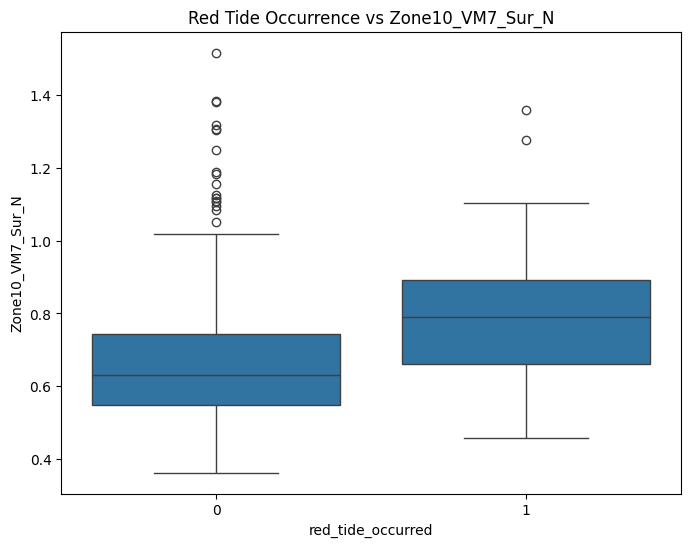

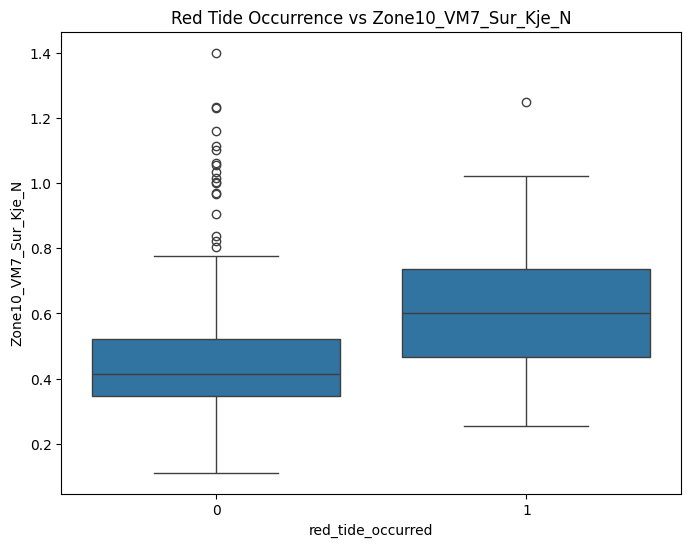

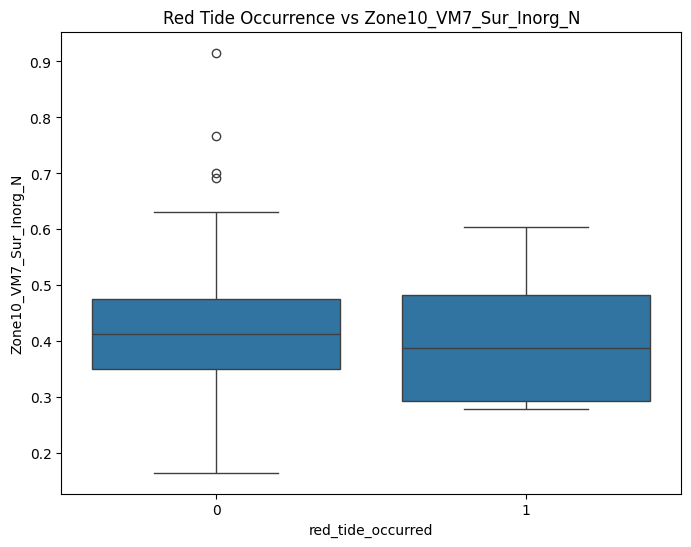

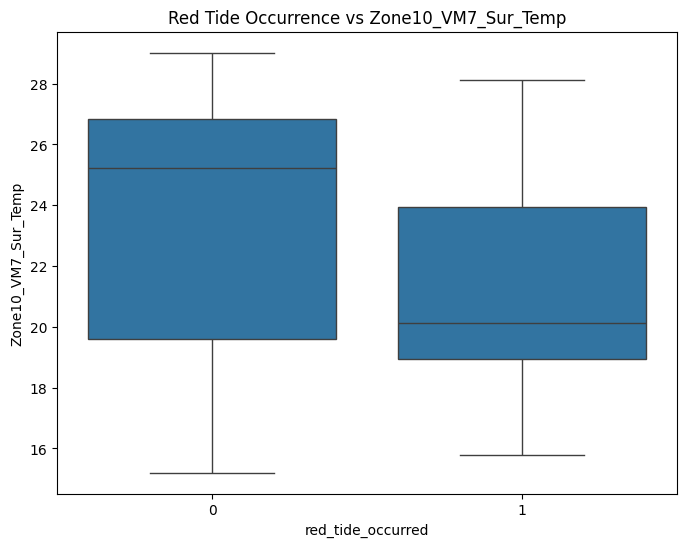

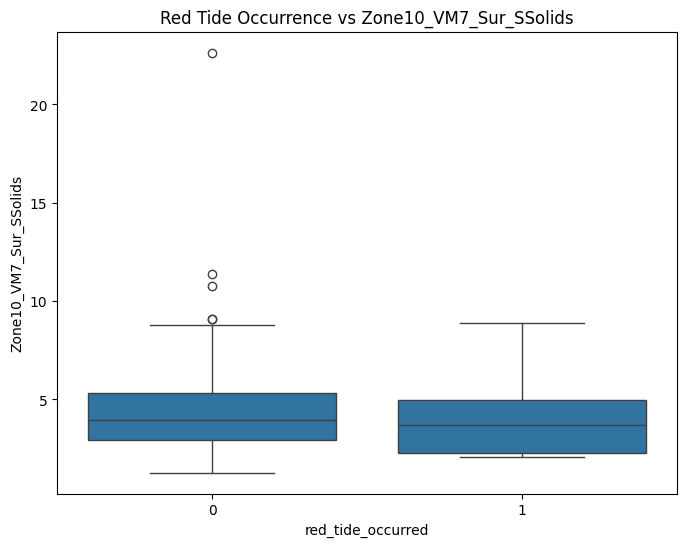

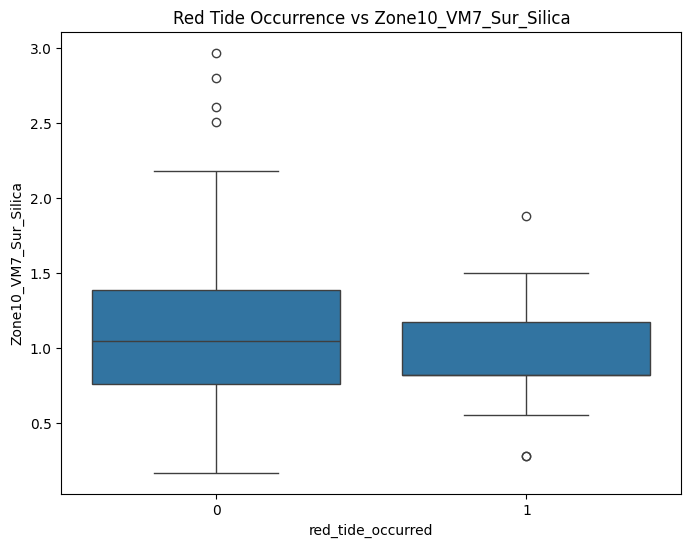

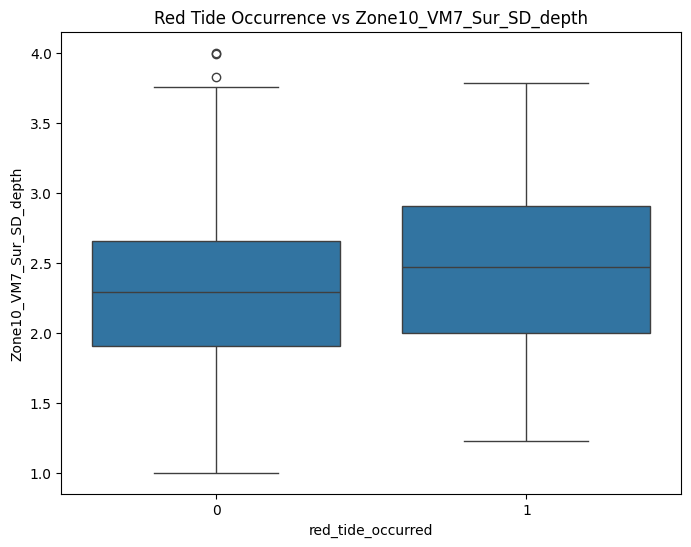

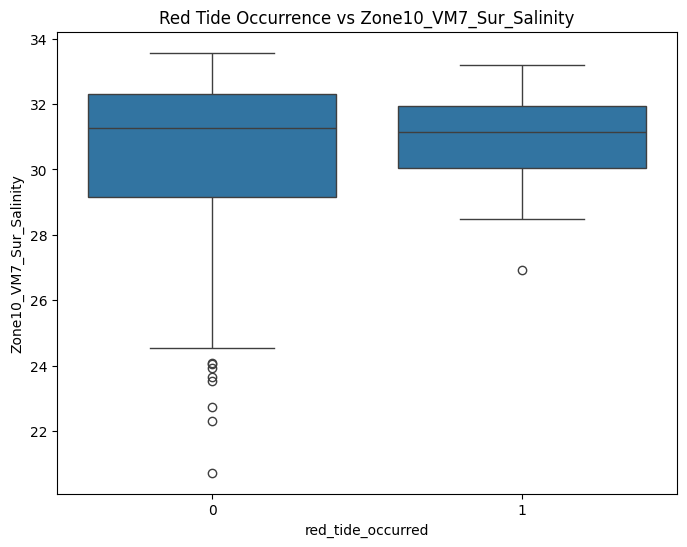

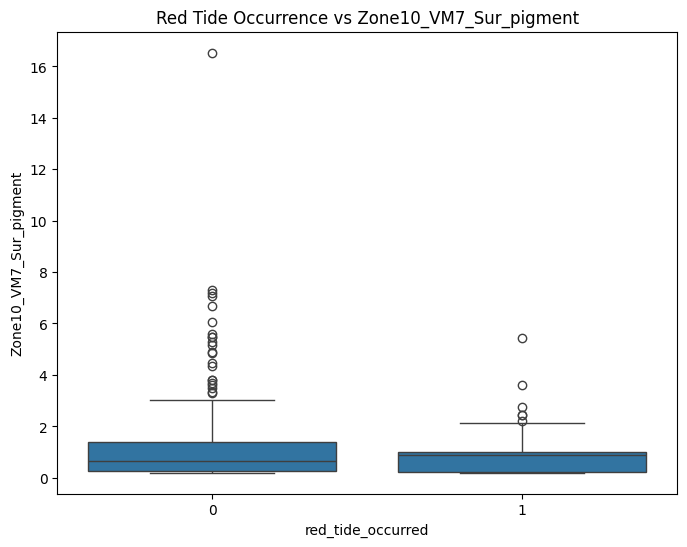

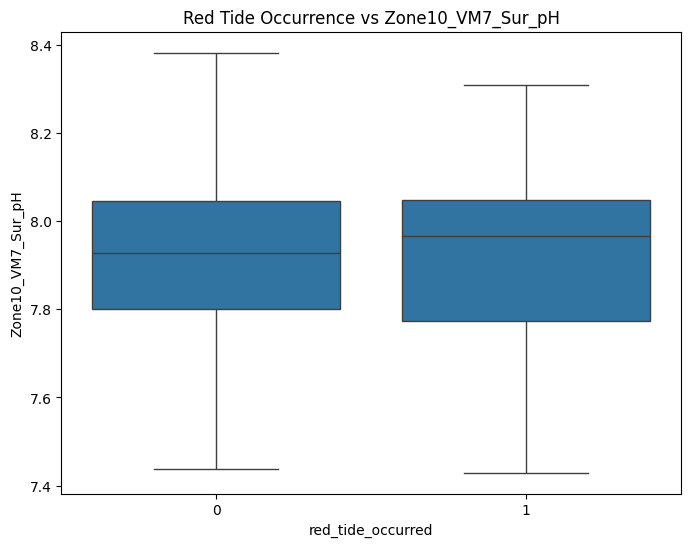

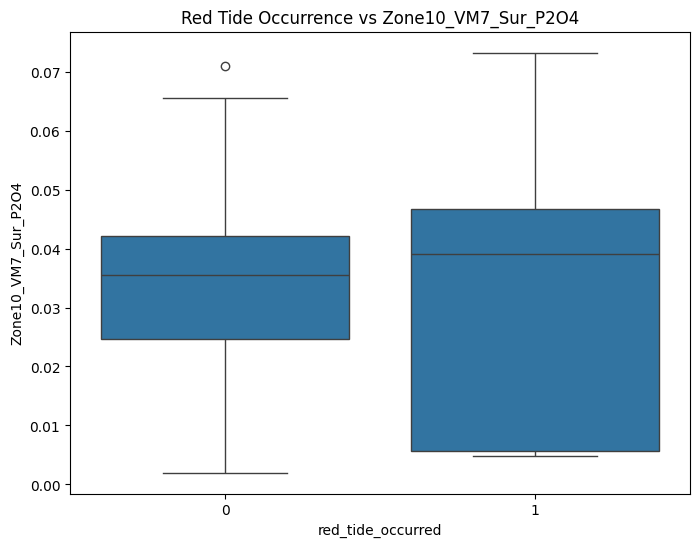

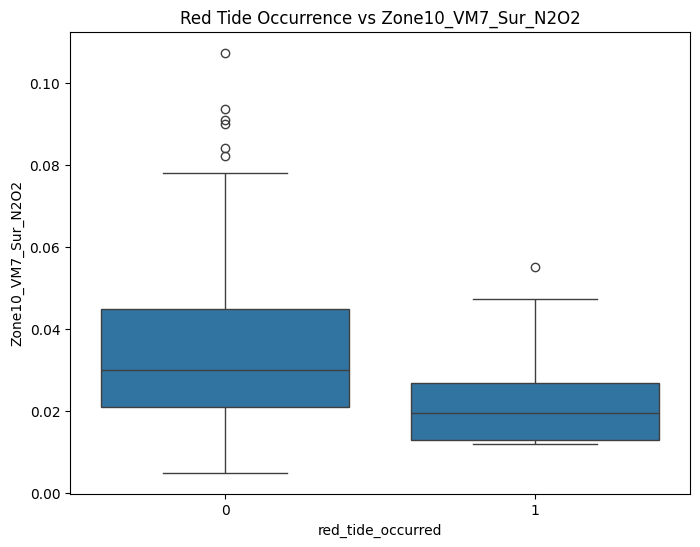

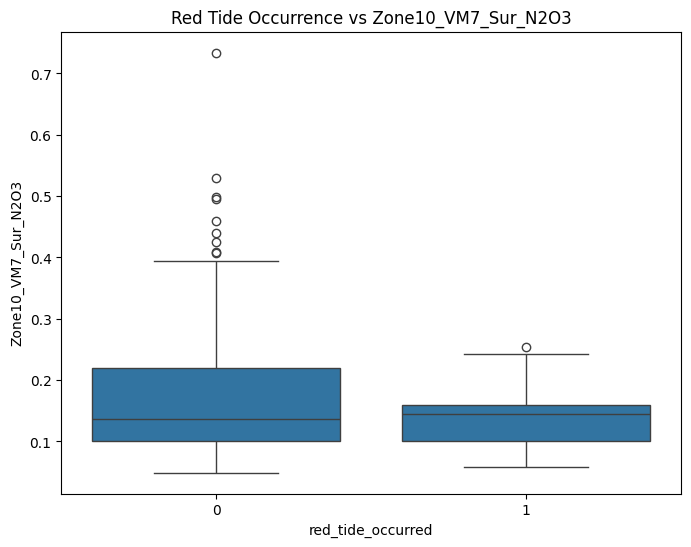

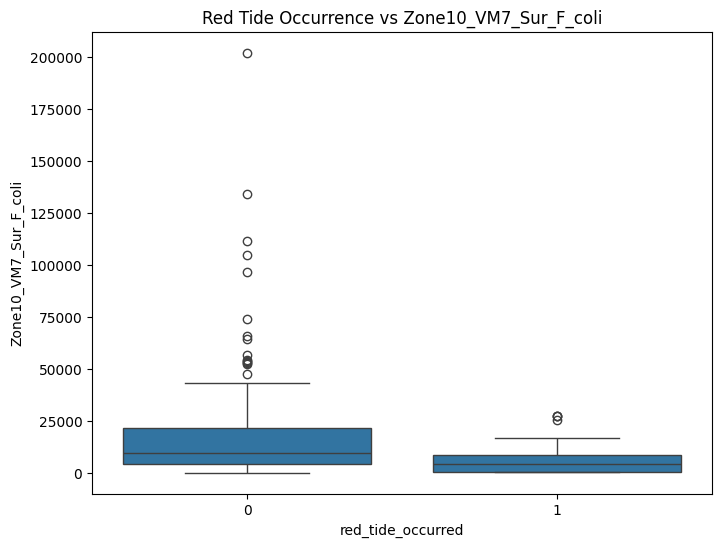

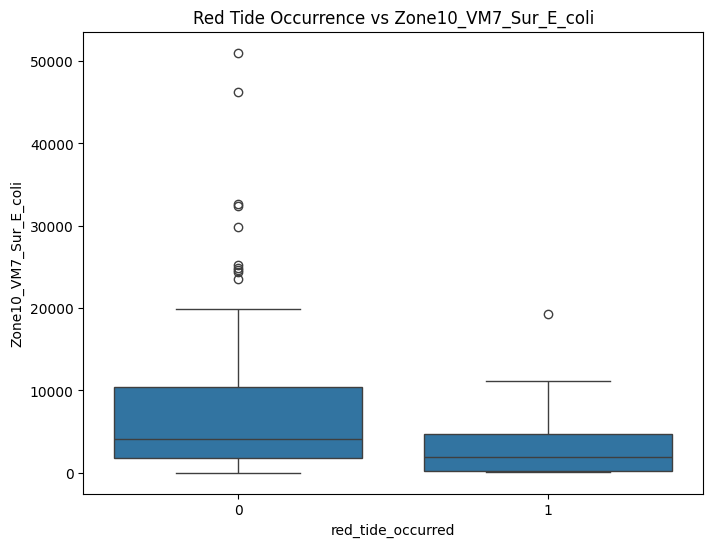

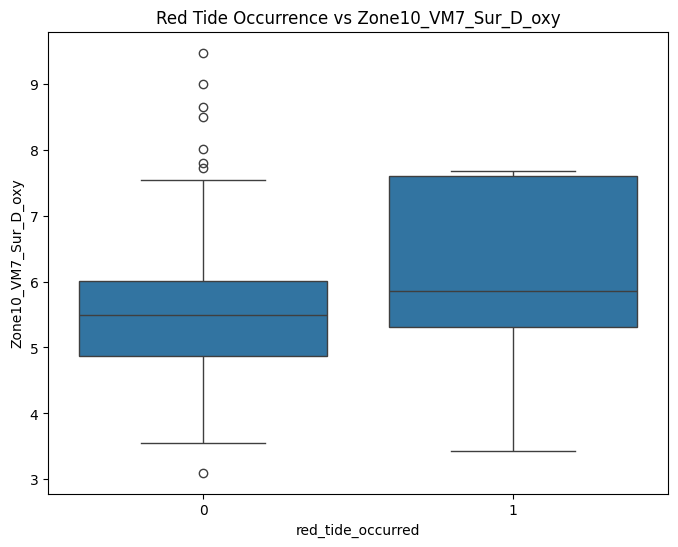

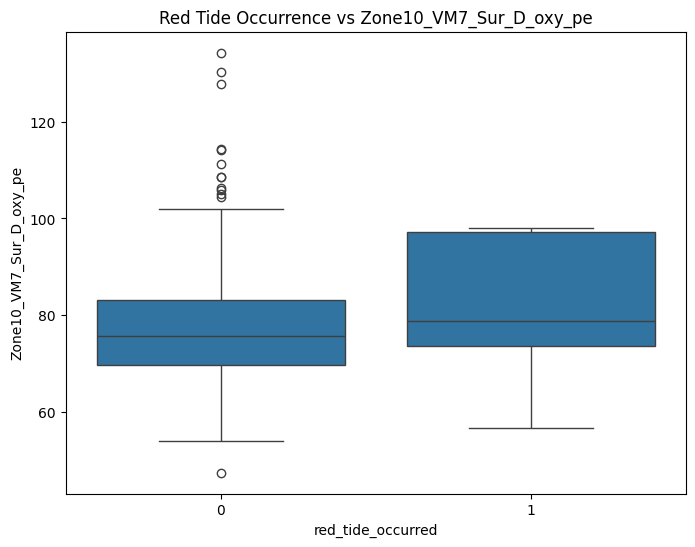

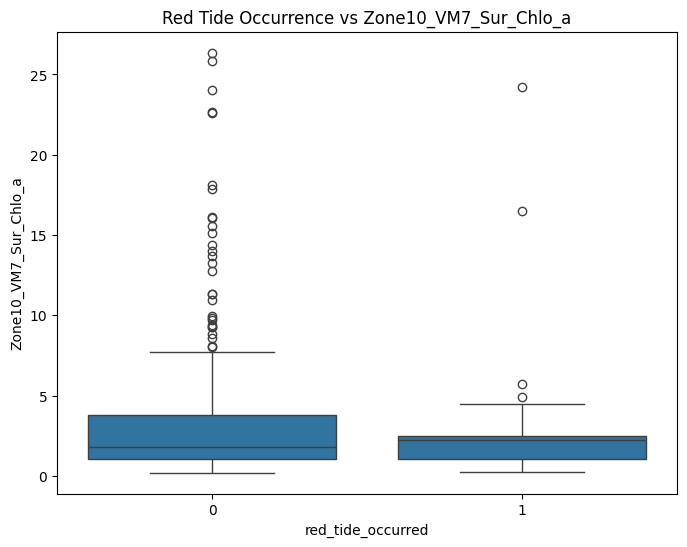

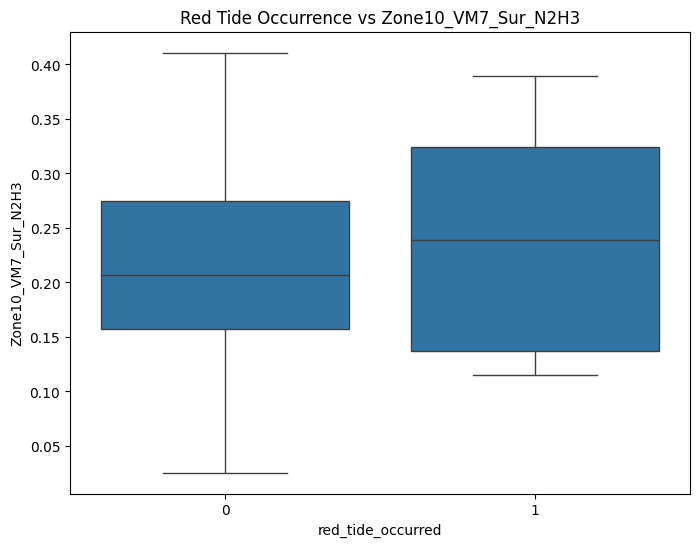

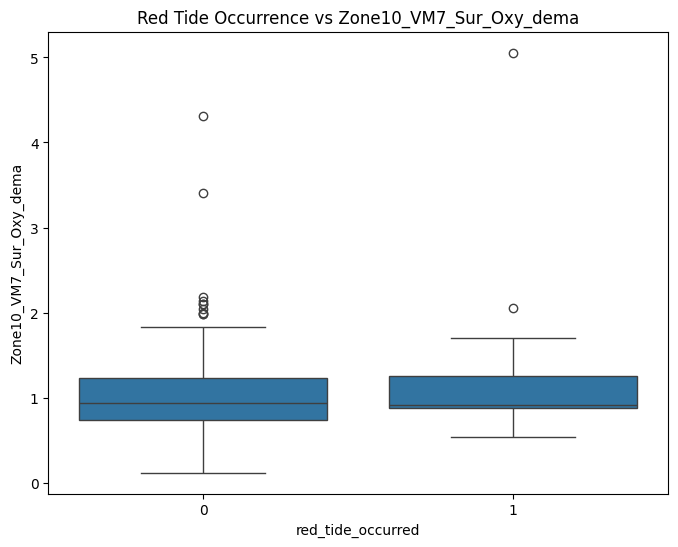

In [31]:
# Create boxplots for the water quality parameters against the red tide occurrence
for column in zone1_columns:
    plt.figure(figsize=(8, 6))
    sb.boxplot(x='red_tide_occurred', y=column, data=merged_data)
    plt.title(f'Red Tide Occurrence vs {column}')
    plt.show()

In [32]:
# Select only Zone1 water quality parameters and the red_tide_occurred column
zone1_data = merged_data[['red_tide_occurred'] + zone1_columns]

# Drop any rows with missing values
zone1_data = zone1_data.dropna()

# Separate features (water quality parameters) and the target (red tide occurrence)
X = zone1_data.drop(columns=['red_tide_occurred'])
y = zone1_data['red_tide_occurred']

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
# Apply KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the dataset
zone1_data['Cluster'] = clusters

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


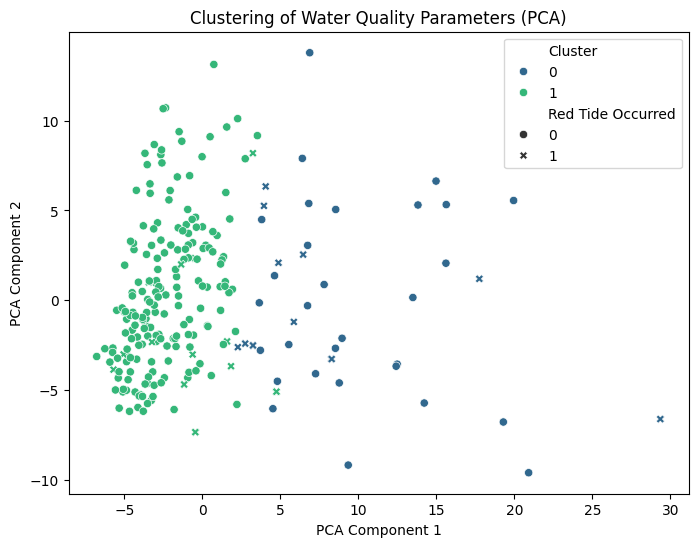

In [35]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Create a new DataFrame with the PCA components and the cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters
pca_df['Red Tide Occurred'] = y

# Plot the PCA results, color by the cluster label and red tide occurrence
plt.figure(figsize=(8, 6))
sb.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', style='Red Tide Occurred', markers=["o", "X"])
plt.title('Clustering of Water Quality Parameters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [36]:
# Group by Cluster and calculate the mean of red_tide_occurred for each cluster
cluster_summary = zone1_data.groupby('Cluster')['red_tide_occurred'].mean()

# Show the percentage of red tide occurrences in each cluster
print(cluster_summary)

Cluster
0    0.318182
1    0.114286
Name: red_tide_occurred, dtype: float64


In [37]:
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], dayfirst=True, errors='coerce')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], dayfirst=True, errors='coerce')

# Create a range of dates between report and dissipation for each red tide
red_tide_days = []
for _, row in rt_data.iterrows():
    days_range = pd.date_range(start=row['Date of Report'], end=row['Date of Dissipation'])
    red_tide_days.extend(days_range)

# Create a DataFrame with red tide days
red_tide_df = pd.DataFrame({'Date': red_tide_days, 'RedTide': 1})

# Merge climate data with red tide data
climate_data = climate_data.merge(red_tide_df, on='Date', how='left')
climate_data['RedTide'] = climate_data['RedTide'].fillna(0)  # Fill NaNs with 0 for no red tide

In [38]:
# Select relevant columns
features = ['MeanTemp', 'MeanAmountCloud', 'Rainfall', 'WindSpeed', 'BrightSunshine', 'GlobalSolarRadiation']
X = climate_data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
os.environ["MKL_THREADING_LAYER"] = "SEQUENTIAL"
from sklearn.cluster import KMeans  # Import after setting the environment variable

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


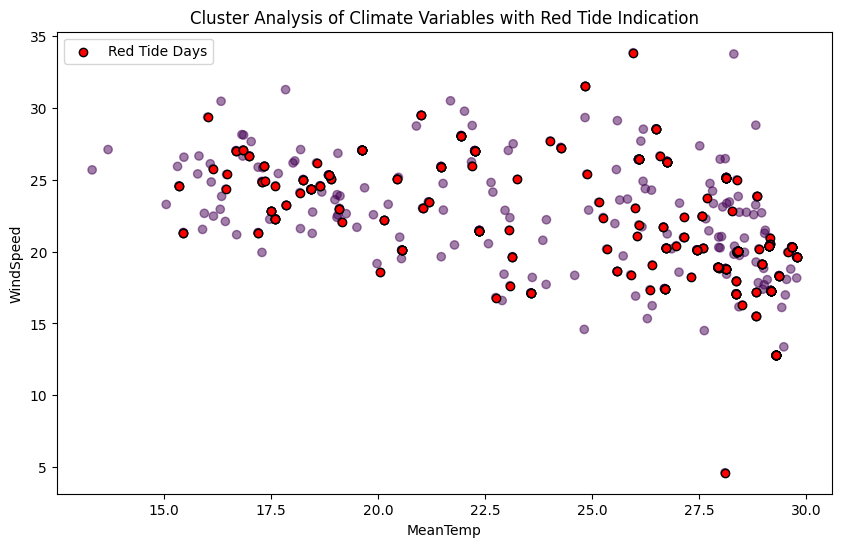

In [40]:
 #Apply K-Means clustering
kmeans = KMeans(n_clusters=1, random_state=0)  # Adjust n_clusters as needed
climate_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(climate_data['MeanTemp'], climate_data['WindSpeed'], 
            c=climate_data['Cluster'], cmap='viridis', alpha=0.5)
plt.scatter(climate_data[climate_data['RedTide'] == 1]['MeanTemp'], 
            climate_data[climate_data['RedTide'] == 1]['WindSpeed'], 
            color='red', label='Red Tide Days', edgecolor='k')
plt.xlabel('MeanTemp')
plt.ylabel('WindSpeed')
plt.legend()
plt.title('Cluster Analysis of Climate Variables with Red Tide Indication')
plt.show()

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


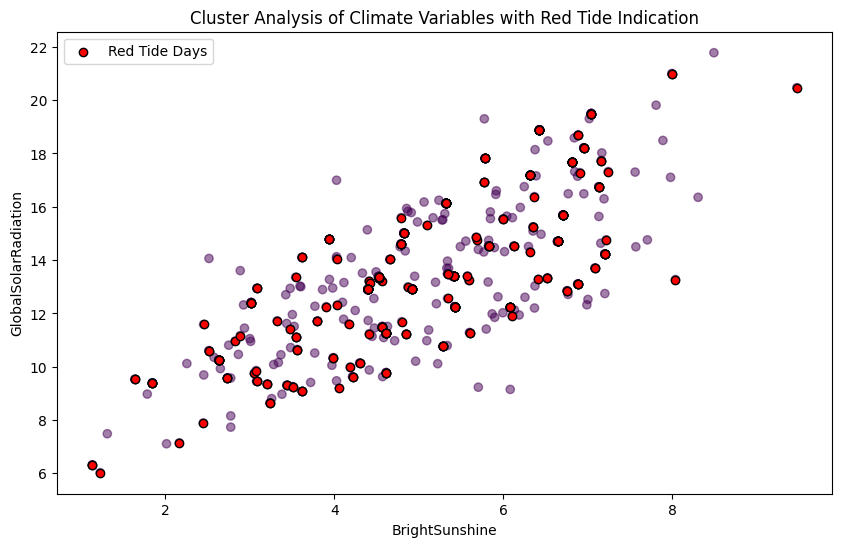

In [41]:
 #Apply K-Means clustering
kmeans = KMeans(n_clusters=1, random_state=0)  # Adjust n_clusters as needed
climate_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(climate_data['BrightSunshine'], climate_data['GlobalSolarRadiation'], 
            c=climate_data['Cluster'], cmap='viridis', alpha=0.5)
plt.scatter(climate_data[climate_data['RedTide'] == 1]['BrightSunshine'], 
            climate_data[climate_data['RedTide'] == 1]['GlobalSolarRadiation'], 
            color='red', label='Red Tide Days', edgecolor='k')
plt.xlabel('BrightSunshine')
plt.ylabel('GlobalSolarRadiation')
plt.legend()
plt.title('Cluster Analysis of Climate Variables with Red Tide Indication')
plt.show()

In [42]:
# Define the parameters to filter
parameters = ['Sur_N$', 'Sur_Chlo_a', 'Sur_P$', 'Sur_Temp', 'Sur_Salinity']

# Filter columns containing any of the specified parameters
filtered_columns = [col for col in rawstations_data.columns if any(param in col for param in parameters)]

# Further filter to include only Sur, Mid, and Bot layers for comparison
layers = ['Sur', 'Mid', 'Bot']
filtered_columns = [col for col in filtered_columns if any(layer in col for layer in layers)]

# Extract relevant data
filtered_data = rawstations_data[filtered_columns]

# Display the filtered column names and the first few rows for verification
filtered_data_head = filtered_data.head()
filtered_data_columns = filtered_data.columns.tolist()

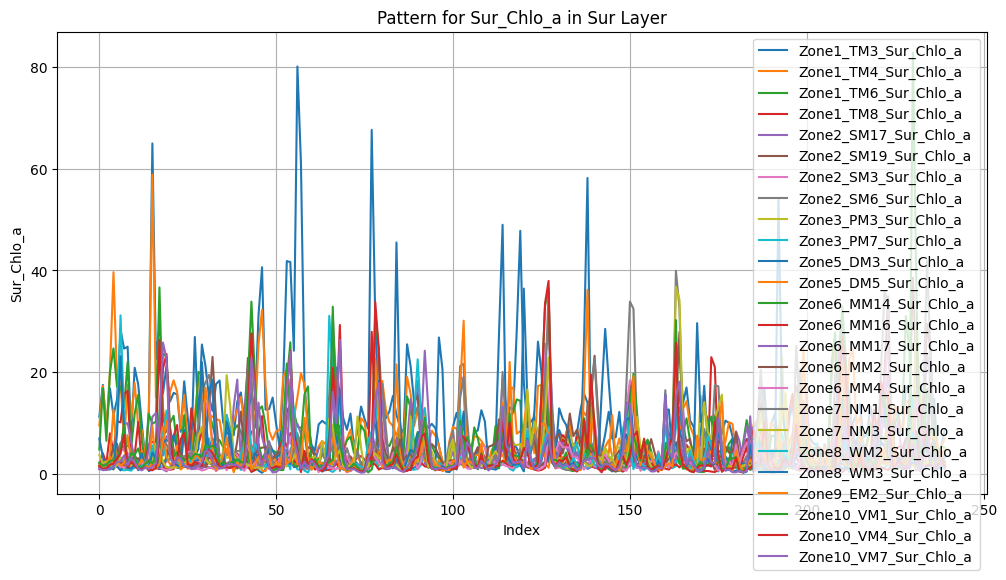

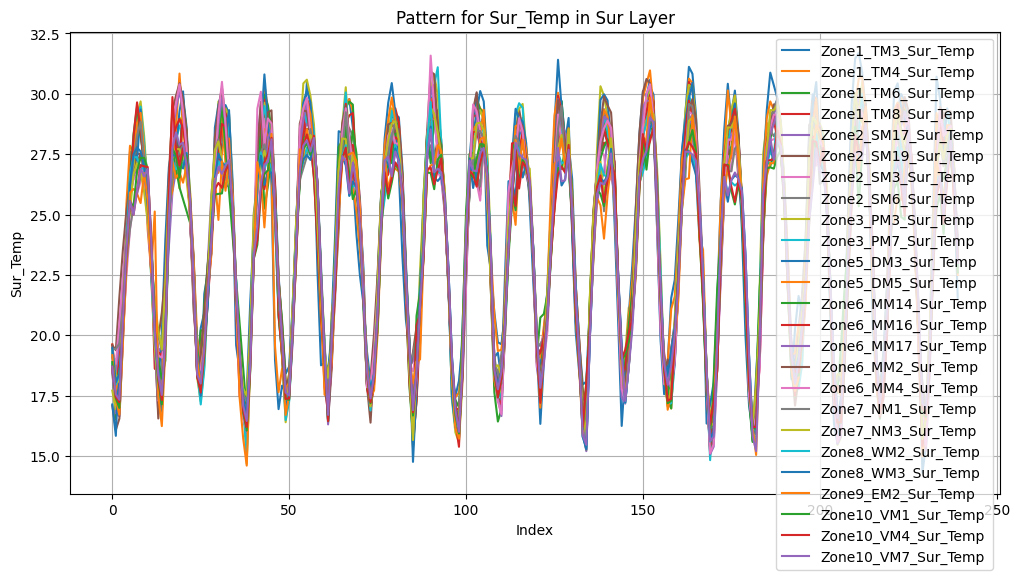

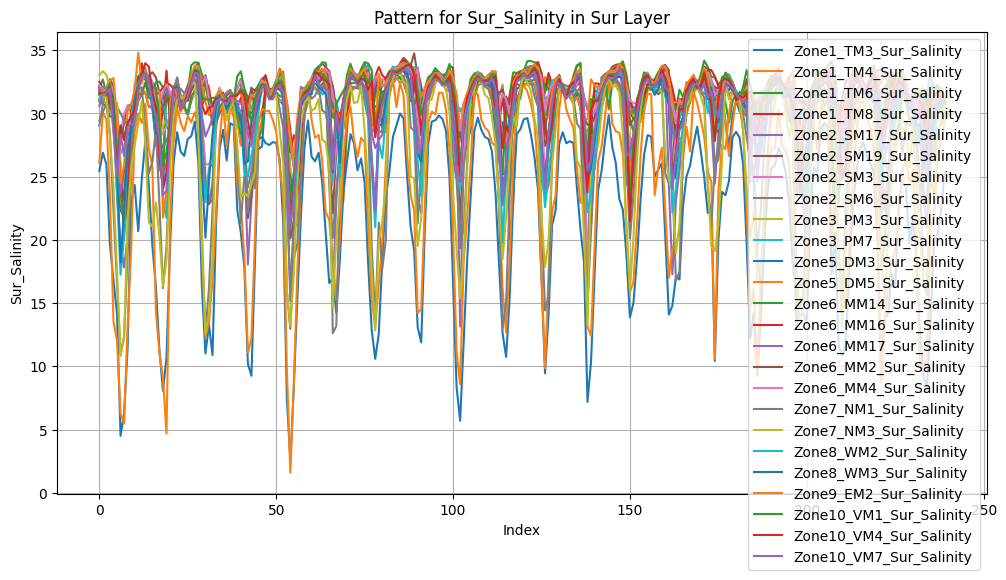

In [43]:
import matplotlib.pyplot as plt

# Group columns by layers and parameters
layer_groups = {layer: {param: [col for col in filtered_columns if param in col and layer in col] 
                        for param in parameters} 
                for layer in ['Sur', 'Mid', 'Bot']}

# Function to plot patterns for each parameter in a specific layer
def plot_layer_parameter_patterns(data, param, columns, layer):
    plt.figure(figsize=(12, 6))
    for col in columns:
        plt.plot(data.index, data[col], label=col)  # Use column name for legend
    plt.title(f'Pattern for {param} in {layer} Layer')
    plt.xlabel('Index')
    plt.ylabel(param)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot patterns separately for each layer and parameter
for layer, params in layer_groups.items():
    for param, cols in params.items():
        if cols:  # Ensure there are columns for the parameter in the layer
            plot_layer_parameter_patterns(filtered_data, param, cols, layer)


In [44]:
# Extract the parameter names by splitting on the last '_Sur_'
parameter_columns = stations_data.columns[1:]  # Exclude the 'Date' column
parameter_names = parameter_columns.str.extract(r'_Sur_(.+)$')[0]

# Map parameters to their corresponding columns
parameter_groups = {param: parameter_columns[parameter_names == param].tolist() for param in parameter_names.unique()}

# Create a new DataFrame with 'Date' and averaged parameters
result = pd.DataFrame()
result['Date'] = stations_data['Date']

# Calculate the mean for each parameter group
for param, cols in parameter_groups.items():
    result[param] = stations_data[cols].mean(axis=1)

# Display the first few rows of the resulting DataFrame
result.head()

Date  VSSolids    UI_NH3  Turbidit         P         N     Kje_N  \
0 1997-01-01  0.956778  0.004196  2.205910  0.133568  0.884558  0.757290   
1 1997-02-01  0.901753  0.006359  2.242144  0.117502  1.045707  0.943731   
2 1997-03-01  1.062452  0.004642  3.665182  0.107509  0.708205  0.618309   
3 1997-04-01  1.110717  0.003938  4.773335  0.097890  0.889645  0.751272   
4 1997-05-01  1.345823  0.002146  4.868442  0.066685  1.120384  0.920238   

    Inorg_N       Temp   SSolids  ...      N2O2      N2O3       F_coli  \
0  0.266350  18.850242  4.526654  ...  0.020406  0.106684  1571.489764   
1  0.293142  17.652005  4.187675  ...  0.019294  0.082109  1190.585564   
2  0.245008  18.489109  4.361202  ...  0.016292  0.072628   937.540900   
3  0.266408  20.928340  4.368501  ...  0.011871  0.125310  1220.755884   
4  0.296040  23.664814  4.273914  ...  0.010676  0.189019  1430.408757   

        E_coli     D_oxy    D_oxy_pe    Chlo_a      N2H3  Oxy_dema  NaN  
0  1000.532565  7.749422  100.018370  2.643600  0.138784  1.405534  NaN  
1   854.681327  7.785083   98.546342  3.458203  0.191139  1.038869  NaN  
2   668.929274  7.103065   91.527238  2.235338  0.155024  1.087353  NaN  
3   816.864359  6.391788   85.678719  4.122271  0.128041  1.120744  NaN  
4  1006.889679  6.711745   93.553553  5.512863  0.095435  1.630295  NaN  

[5 rows x 26 columns]

In [45]:
result['Date'] = pd.to_datetime(result['Date'], errors='coerce')
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], dayfirst=True, errors='coerce')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], dayfirst=True, errors='coerce')

# Create a range of dates between report and dissipation for each red tide
red_tide_days = []
for _, row in rt_data.iterrows():
    days_range = pd.date_range(start=row['Date of Report'], end=row['Date of Dissipation'])
    red_tide_days.extend(days_range)

# Create a DataFrame with red tide days
red_tide_df = pd.DataFrame({'Date': red_tide_days, 'RedTide': 1})

# Merge wq data with red tide data
result = result.merge(red_tide_df, on='Date', how='left')
result['RedTide'] = result['RedTide'].fillna(0)  # Fill NaNs with 0 for no red tide

result.head()

Date  VSSolids    UI_NH3  Turbidit         P         N     Kje_N  \
0 1997-01-01  0.956778  0.004196  2.205910  0.133568  0.884558  0.757290   
1 1997-01-01  0.956778  0.004196  2.205910  0.133568  0.884558  0.757290   
2 1997-02-01  0.901753  0.006359  2.242144  0.117502  1.045707  0.943731   
3 1997-03-01  1.062452  0.004642  3.665182  0.107509  0.708205  0.618309   
4 1997-04-01  1.110717  0.003938  4.773335  0.097890  0.889645  0.751272   

    Inorg_N       Temp   SSolids  ...      N2O3       F_coli       E_coli  \
0  0.266350  18.850242  4.526654  ...  0.106684  1571.489764  1000.532565   
1  0.266350  18.850242  4.526654  ...  0.106684  1571.489764  1000.532565   
2  0.293142  17.652005  4.187675  ...  0.082109  1190.585564   854.681327   
3  0.245008  18.489109  4.361202  ...  0.072628   937.540900   668.929274   
4  0.266408  20.928340  4.368501  ...  0.125310  1220.755884   816.864359   

      D_oxy    D_oxy_pe    Chlo_a      N2H3  Oxy_dema  NaN  RedTide  
0  7.749422  100.018370  2.643600  0.138784  1.405534  NaN      1.0  
1  7.749422  100.018370  2.643600  0.138784  1.405534  NaN      1.0  
2  7.785083   98.546342  3.458203  0.191139  1.038869  NaN      0.0  
3  7.103065   91.527238  2.235338  0.155024  1.087353  NaN      0.0  
4  6.391788   85.678719  4.122271  0.128041  1.120744  NaN      0.0  

[5 rows x 27 columns]

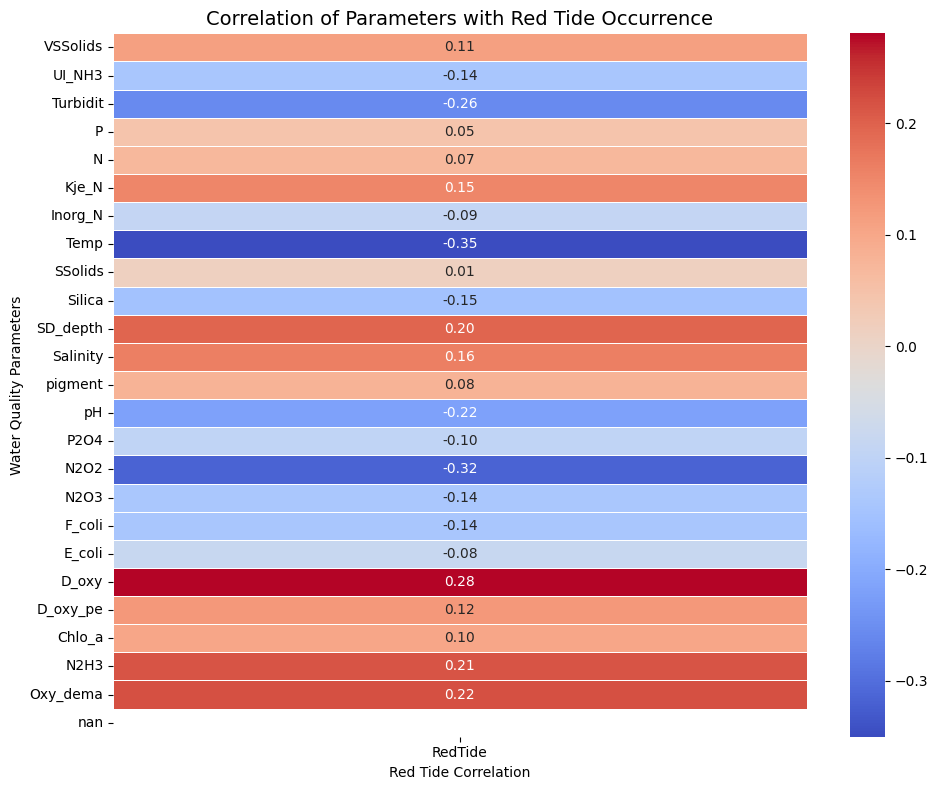

In [46]:
# Compute the correlation matrix including 'RedTide'
correlation_matrix = result.corr()

# Extract correlations with 'RedTide', excluding 'RedTide' and 'Date'
red_tide_corr = correlation_matrix['RedTide'].drop(['RedTide', 'Date'], errors='ignore')  # Exclude self-correlation and 'Date'


# Plot the correlations as a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(
    red_tide_corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    cbar=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Correlation of Parameters with Red Tide Occurrence", fontsize=14)
plt.ylabel("Water Quality Parameters")
plt.xlabel("Red Tide Correlation")
plt.tight_layout()
plt.show()

In [ ]:
climate_data['Date'] = pd.to_datetime(climate_data['Date'], errors='coerce')
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], dayfirst=True, errors='coerce')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], dayfirst=True, errors='coerce')

# Create a range of dates between report and dissipation for each red tide
red_tide_days = []
for _, row in rt_data.iterrows():
    days_range = pd.date_range(start=row['Date of Report'], end=row['Date of Dissipation'])
    red_tide_days.extend(days_range)

# Create a DataFrame with red tide days
red_tide_df = pd.DataFrame({'Date': red_tide_days, 'RedTide': 1})

# Merge climate data with red tide data
climate_data = climate_data.merge(red_tide_df, on='Date', how='left')
climate_data['RedTide'] = climate_data['RedTide'].fillna(0)  # Fill NaNs with 0 for no red tide

In [ ]:
# Compute the correlation matrix including 'RedTide'
correlation_matrix = climate_data.corr()

# Extract correlations with 'RedTide', excluding 'RedTide' and 'Date'
red_tide_corr = correlation_matrix['RedTide'].drop(['RedTide', 'Date'], errors='ignore')  # Exclude self-correlation and 'Date'


# Plot the correlations as a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(
    red_tide_corr.to_frame(),
    annot=True,
    cmap="coolwarm",
    cbar=True,
    fmt=".2f",
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Correlation of Parameters with Red Tide Occurrence", fontsize=14)
plt.ylabel("Climate Parameters")
plt.xlabel("Red Tide Correlation")
plt.tight_layout()
plt.show()

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Read datasets with explicit date parsing for 'DD/MM/YYYY' format
rt_data = pd.read_csv(
    'rt_clean.csv',
    parse_dates=['Date of Report', 'Date of Dissipation'],
    dayfirst=True
)

climate_data = pd.read_csv(
    'climate.csv',
    parse_dates=['Date'],
    dayfirst=True
)

# Generate all dates for red tide occurrences
rt_data['Red Tide Dates'] = rt_data.apply(
    lambda row: pd.date_range(row['Date of Report'], row['Date of Dissipation']), axis=1
)
rt_dates = rt_data.explode('Red Tide Dates')['Red Tide Dates'].reset_index(drop=True)

# Create a DataFrame of red tide occurrences
red_tide_occurrences = pd.DataFrame({'Date': rt_dates, 'Red Tide Occurrence': 1})

# Merge with climate data
climate_data = climate_data.merge(red_tide_occurrences, on='Date', how='left')
climate_data['Red Tide Occurrence'] = climate_data['Red Tide Occurrence'].fillna(0)

# Create lagged features (e.g., 1 day, 7 days, 14 days)
for col in climate_data.columns[1:-1]:  # Exclude 'Date' and 'Red Tide Occurrence'
    climate_data[f'{col}_lag1'] = climate_data[col].shift(1)
    climate_data[f'{col}_lag7'] = climate_data[col].shift(7)
    climate_data[f'{col}_lag14'] = climate_data[col].shift(14)

# Drop rows with missing lagged values
climate_data.dropna(inplace=True)

# Define features (X) and target (y)
X = climate_data.drop(columns=['Date', 'Red Tide Occurrence'])
y = climate_data['Red Tide Occurrence']

# Time-based split (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(climate_data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.01,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio
)
xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances
importances = xgb_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

# Optional: Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)
    cv_accuracies.append(accuracy_score(y_test_cv, y_pred_cv))

print("\nCross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_accuracies), np.std(cv_accuracies)))


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Calculate imbalance ratio for class weights (if not already calculated)
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting rounds
    'max_depth': [3, 5, 7],                  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],      # Step size shrinking to prevent overfitting
    'subsample': [0.8, 1.0],                 # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],          # Fraction of features used for each tree
    'scale_pos_weight': [1, imbalance_ratio] # Handle class imbalance
}

# Initialize GridSearchCV with XGBoost model
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # F1 weighted scoring to handle imbalance
    verbose=1,               # Output the progress of the grid search
    n_jobs=-1                # Use all available CPU cores for computation
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Print best parameters
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print classification report for the best model
from sklearn.metrics import classification_report
print("\nClassification Report of Best Model:")
print(classification_report(y_test, y_pred))

# Optional: Plot feature importances of the best model
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Read datasets with explicit date parsing for 'DD/MM/YYYY' format
rt_data = pd.read_csv(
    'rt_clean.csv',
    parse_dates=['Date of Report', 'Date of Dissipation'],
    dayfirst=True
)

climate_data = pd.read_csv(
    'climate.csv',
    parse_dates=['Date'],
    dayfirst=True
)

# Generate all dates for red tide occurrences
rt_data['Red Tide Dates'] = rt_data.apply(
    lambda row: pd.date_range(row['Date of Report'], row['Date of Dissipation']), axis=1
)
rt_dates = rt_data.explode('Red Tide Dates')['Red Tide Dates'].reset_index(drop=True)

# Create a DataFrame of red tide occurrences
red_tide_occurrences = pd.DataFrame({'Date': rt_dates, 'Red Tide Occurrence': 1})

# Merge with climate data
climate_data = climate_data.merge(red_tide_occurrences, on='Date', how='left')
climate_data['Red Tide Occurrence'] = climate_data['Red Tide Occurrence'].fillna(0)

# Create lagged features (e.g., 1 day, 7 days, 14 days)
for col in climate_data.columns[1:-1]:  # Exclude 'Date' and 'Red Tide Occurrence'
    climate_data[f'{col}_lag1'] = climate_data[col].shift(1)
    climate_data[f'{col}_lag7'] = climate_data[col].shift(7)
    climate_data[f'{col}_lag14'] = climate_data[col].shift(14)

# Drop rows with missing lagged values
climate_data.dropna(inplace=True)

# Define features (X) and target (y)
X = climate_data.drop(columns=['Date', 'Red Tide Occurrence'])
y = climate_data['Red Tide Occurrence']

# Time-based split (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(climate_data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model with best parameters from GridSearchCV
imbalance_ratio = len(y_train[y_train == 0.0]) / len(y_train[y_train == 1.0])

xgb_model = XGBClassifier(
    n_estimators=100,          # From GridSearchCV
    max_depth=5,               # From GridSearchCV
    learning_rate=0.01,        # From GridSearchCV
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio,  # Handling class imbalance
    subsample=0.8,             # From GridSearchCV
    colsample_bytree=1.0,      # From GridSearchCV
)

xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = xgb_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importances
importances = xgb_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

# Optional: Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
cv_accuracies = []

for train_idx, test_idx in tscv.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = xgb_model.predict(X_test_cv)
    cv_accuracies.append(accuracy_score(y_test_cv, y_pred_cv))

print("\nCross-Validation Accuracy: {:.4f} ± {:.4f}".format(np.mean(cv_accuracies), np.std(cv_accuracies)))


In [22]:
import pandas as pd

# Load red tide data
rt_data = pd.read_csv('rt_clean.csv')

# Convert date columns to datetime
rt_data['Date of Report'] = pd.to_datetime(rt_data['Date of Report'], dayfirst=True, errors='coerce')
rt_data['Date of Dissipation'] = pd.to_datetime(rt_data['Date of Dissipation'], dayfirst=True, errors='coerce')

# Create a daily date range from 01/01/1997 to the last dissipation date
start_date = pd.Timestamp("1997-01-01")
end_date = rt_data['Date of Dissipation'].max()
all_dates = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})

# Initialize with no red tide occurrence (0)
all_dates['Red Tide'] = 0

# Mark days with red tide occurrence
for _, row in rt_data.iterrows():
    mask = (all_dates['Date'] >= row['Date of Report']) & (all_dates['Date'] <= row['Date of Dissipation'])
    all_dates.loc[mask, 'Red Tide'] = 1

# Convert Date back to DD/MM/YYYY format
all_dates['Date'] = all_dates['Date'].dt.strftime('%d/%m/%Y')

# Save to CSV
all_dates.to_csv('red_tide_occurrences.csv', index=False)

print("File 'red_tide_occurrences.csv' has been created successfully.")


File 'red_tide_occurrences.csv' has been created successfully.


## Val dataset

In [23]:
import pandas as pd

# Load red tide data
rt_newdata = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/rt_data (2020-2023).csv')

# Convert date columns to datetime
rt_newdata['Date of Report'] = pd.to_datetime(rt_newdata['Date of Report'], dayfirst=True, errors='coerce')
rt_newdata['Date of Dissipation'] = pd.to_datetime(rt_newdata['Date of Dissipation'], dayfirst=True, errors='coerce')

# Create a daily date range from 01/01/1997 to the last dissipation date
start_date = pd.Timestamp("2020-01-01")
end_date = rt_newdata['Date of Dissipation'].max()
all_dates = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})

# Initialize with no red tide occurrence (0)
all_dates['Red Tide'] = 0

# Mark days with red tide occurrence
for _, row in rt_newdata.iterrows():
    mask = (all_dates['Date'] >= row['Date of Report']) & (all_dates['Date'] <= row['Date of Dissipation'])
    all_dates.loc[mask, 'Red Tide'] = 1

# Convert Date back to DD/MM/YYYY format
all_dates['Date'] = all_dates['Date'].dt.strftime('%d/%m/%Y')

# Save to CSV
all_dates.to_csv('C:/Users/User/FYP(DESKTOP)/val set/red_tide_val.csv', index=False)

print("File 'red_tide_val.csv' has been created successfully.")

File 'red_tide_val.csv' has been created successfully.


In [20]:
zone1_newdata = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/zone1_raw.csv')
print(zone1_newdata.columns.tolist())

['Water Control Zone', 'Station', 'Dates', 'Sample No', 'Depth', '5-day Biochemical Oxygen Demand (mg/L)', 'Ammonia Nitrogen (mg/L)', 'Phaeo-pigments (μg/L)', 'pH', 'Orthophosphate Phosphorus (mg/L)', 'Nitrite Nitrogen (mg/L)', 'Nitrate Nitrogen (mg/L)', 'Faecal Coliforms (cfu/100mL)', 'E. coli (cfu/100mL)', 'Dissolved Oxygen (mg/L)', 'Dissolved Oxygen (%saturation)', 'Chlorophyll-a (μg/L)', 'Volatile Suspended Solids (mg/L)', 'Unionised Ammonia (mg/L)', 'Turbidity (NTU)', 'Total Phosphorus (mg/L)', 'Total Nitrogen (mg/L)', 'Total Kjeldahl Nitrogen (mg/L)', 'Total Inorganic Nitrogen (mg/L)', 'Temperature (°C)', 'Suspended Solids (mg/L)', 'Silica (mg/L)', 'Secchi Disc Depth (M)', 'Salinity (psu)']


In [21]:
columns_to_clean = ['Total Kjeldahl Nitrogen (mg/L)', 'Total Nitrogen (mg/L)', 'Total Phosphorus (mg/L)']

# Data Cleaning: Convert to numeric, handling errors
for col in columns_to_clean:
    zone1_newdata[col] = pd.to_numeric(zone1_newdata[col], errors='coerce')

# Fill NaN values with the mean of each column
for col in columns_to_clean:
    mean_val = zone1_newdata[col].mean() # Calculate mean only once per column for efficiency
    zone1_newdata[col] = zone1_newdata[col].fillna(mean_val)

In [22]:
# Filter for Surface Water data
sur = zone1_newdata[zone1_newdata["Depth"] == "Surface Water"]

# Save the filtered data if needed
sur.to_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv', index=False)

In [23]:
zone1_newdata = zone1_newdata.drop(columns=['Water Control Zone', 'Sample No', 'Depth'])
zone1_newdata.to_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv', index=False)

In [24]:
import pandas as pd
import re

# Load dataset
zone1_newdata = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv')

# Define a function to remove the '<' sign
def remove_less_than(value):
    if isinstance(value, str) and value.startswith('<'):
        return float(value[1:])  # Remove '<' and convert to float
    return value  # Return the value as is if it doesn't start with '<'

# Apply the function to all columns except 'Station' and 'Date'
for col in zone1_newdata.columns:
    if col not in ['Station', 'Date']:
        zone1_newdata[col] = zone1_newdata[col].apply(remove_less_than)

# Save the updated dataset
zone1_newdata.to_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv', index=False)

In [25]:
zone1_newdata = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv')
# Define the reverse renaming dictionary
rename_dict = {
    "Dates": "Date",
    "Volatile Suspended Solids (mg/L)": "VSSolids",
    "Unionised Ammonia (mg/L)": "UI_NH3",
    "Turbidity (NTU)": "Turbidit",
    "Total Phosphorus (mg/L)": "P",
    "Total Nitrogen (mg/L)": "N",
    "Total Kjeldahl Nitrogen (mg/L)": "Kje_N",
    "Total Inorganic Nitrogen (mg/L)": "Inorg_N",
    "Temperature (°C)": "Temp",
    "Suspended Solids (mg/L)": "SSolids",
    "Silica (mg/L)": "Silica",
    "Secchi Disc Depth (M)": "SD_depth",
    "Salinity (psu)": "Salinity",
    "Phaeo-pigments (μg/L)": "pigment",
    "pH": "pH",
    "Orthophosphate Phosphorus (mg/L)": "P2O4",
    "Nitrite Nitrogen (mg/L)": "N2O2",
    "Nitrate Nitrogen (mg/L)": "N2O3",
    "Faecal Coliforms (cfu/100mL)": "F_coli",
    "E. coli (cfu/100mL)": "E_coli",
    "Dissolved Oxygen (mg/L)": "D_oxy",
    "Dissolved Oxygen (%saturation)": "D_oxy_pe",
    "Chlorophyll-a (μg/L)": "Chlo_a",
    "Ammonia Nitrogen (mg/L)": "N2H3",
    "5-day Biochemical Oxygen Demand (mg/L)": "Oxy_dema"
}

# Rename the columns by reversing names and removing prefix
zone1_newdata = zone1_newdata.rename(columns=rename_dict)
zone1_newdata.to_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv', index=False)
print(zone1_newdata.columns.tolist())

['Station', 'Date', 'Oxy_dema', 'N2H3', 'pigment', 'pH', 'P2O4', 'N2O2', 'N2O3', 'F_coli', 'E_coli', 'D_oxy', 'D_oxy_pe', 'Chlo_a', 'VSSolids', 'UI_NH3', 'Turbidit', 'P', 'N', 'Kje_N', 'Inorg_N', 'Temp', 'SSolids', 'Silica', 'SD_depth', 'Salinity']


In [31]:
import pandas as pd

# Load the dataset
zone1_newdata = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/filtered_sur.csv')

# Ensure 'Date' is correctly named (if it's named 'Dates' then rename it)
if 'Dates' in zone1_newdata.columns:
    zone1_newdata.rename(columns={'Dates': 'Date'}, inplace=True)

# Convert 'Date' to datetime format (assuming dayfirst=True)
zone1_newdata['Date'] = pd.to_datetime(zone1_newdata['Date'])

# Get the list of water parameters (excluding 'Station' and 'Date')
water_parameters = [col for col in zone1_newdata.columns if col not in ['Station', 'Date']]

# Handle duplicate entries by aggregating (e.g., mean)
zone1_grouped = zone1_newdata.groupby(['Date', 'Station'])[water_parameters].mean().reset_index()

# Pivot the table: each station gets its own set of water parameters
zone1_final = zone1_grouped.pivot(index='Date', columns='Station', values=water_parameters)

# Flatten the columns, and rename them to the format "Zone1_StationID_Sur_(Parameter)"
zone1_final.columns = [
    f"Zone1_{col[1]}_Sur_{col[0].replace('Sur_', '')}" for col in zone1_final.columns
]

# Fill missing values with the mean of the closest non-missing values (linear interpolation)
zone1_final = zone1_final.interpolate(method='linear', axis=0)

# Reset index to bring 'Date' back as a column
zone1_final.reset_index(inplace=True)

# Save the reshaped and interpolated dataset
zone1_final.to_csv('C:/Users/User/FYP(DESKTOP)/val set/zone1_final.csv', index=False)
zone1_final.head()

Date  Zone1_TM3_Sur_Oxy_dema  Zone1_TM4_Sur_Oxy_dema  \
0 2020-01-16                1.300000                1.166667   
1 2020-02-26                1.266667                0.950000   
2 2020-03-05                1.600000                0.733333   
3 2020-04-29                1.300000                0.900000   
4 2020-05-06                1.166667                1.066667   

   Zone1_TM6_Sur_Oxy_dema  Zone1_TM8_Sur_Oxy_dema  Zone1_TM3_Sur_N2H3  \
0                0.866667                0.566667            0.052000   
1                0.633333                0.433333            0.040000   
2                0.400000                0.300000            0.036667   
3                0.616667                0.450000            0.033333   
4                0.833333                0.600000            0.044333   

   Zone1_TM4_Sur_N2H3  Zone1_TM6_Sur_N2H3  Zone1_TM8_Sur_N2H3  \
0            0.049000            0.047000            0.041667   
1            0.041333            0.040500            0.030833   
2            0.033667            0.034000            0.020000   
3            0.032167            0.033833            0.024500   
4            0.030667            0.033667            0.029000   

   Zone1_TM3_Sur_pigment  ...  Zone1_TM6_Sur_Silica  Zone1_TM8_Sur_Silica  \
0               1.433333  ...              0.930000              0.236667   
1               1.466667  ...              0.756667              0.398333   
2               1.533333  ...              0.583333              0.560000   
3               2.300000  ...              0.470000              0.618333   
4               1.433333  ...              0.356667              0.676667   

   Zone1_TM3_Sur_SD_depth  Zone1_TM4_Sur_SD_depth  Zone1_TM6_Sur_SD_depth  \
0                     2.1                    2.60                     2.5   
1                     2.0                    3.00                     3.4   
2                     2.7                    3.40                     4.3   
3                     3.2                    3.45                     3.6   
4                     2.8                    3.50                     2.9   

   Zone1_TM8_Sur_SD_depth  Zone1_TM3_Sur_Salinity  Zone1_TM4_Sur_Salinity  \
0                     3.6               32.400000               32.400000   
1                     3.9               31.866667               32.133333   
2                     4.2               31.433333               31.866667   
3                     4.0               32.100000               32.500000   
4                     3.8               32.966667               33.133333   

   Zone1_TM6_Sur_Salinity  Zone1_TM8_Sur_Salinity  
0                   32.70               32.766667  
1                   32.45               32.666667  
2                   32.20               32.566667  
3                   32.65               32.950000  
4                   33.10               33.333333  

[5 rows x 97 columns]

In [55]:
# Convert 'Date' to datetime format with the exact expected format
zone1_newdata['Date'] = pd.to_datetime(zone1_newdata['Date'], format='%d/%m/%Y')

# If you need to display or export dates in DD/MM/YYYY format, you can use:
zone1_newdata['Date'] = zone1_newdata['Date'].dt.strftime('%d/%m/%Y')

# Check the result
print(zone1_newdata['Date'].head())

0    16/01/2020
1    16/01/2020
2    16/01/2020
3    26/02/2020
4    26/02/2020
Name: Date, dtype: object


In [3]:
import pandas as pd

# Read the CSV file
stations_data = pd.read_csv('25stations_data_sur.csv')

# Convert 'Date' column to datetime
stations_data['Date'] = pd.to_datetime(stations_data['Date'])

# Set 'Date' as the index
stations_data.set_index('Date', inplace=True)

# Resample the data to a daily frequency and forward fill the values
stations_data_daily = stations_data.resample('D').ffill()

# Reset index if needed
stations_data_daily.reset_index(inplace=True)
stations_data_daily.to_csv('C:/Users/User/FYP(DESKTOP)/dailystation.csv', index=False)

## 25/2/2025

In [6]:
import pandas as pd
# Read the CSV file
stations_data = pd.read_csv('25stations_data_sur.csv')
# Convert 'Date' to datetime format
stations_data['Date'] = pd.to_datetime(stations_data['Date'])

# Set 'Date' as the index
stations_data.set_index('Date', inplace=True)

# Resample to daily frequency and interpolate missing values
stations_data_daily = stations_data.resample('D').interpolate(method='linear')
# Reset index if needed
stations_data_daily.reset_index(inplace=True)
# Save the processed data
stations_data_daily.to_csv('C:/Users/User/FYP(DESKTOP)/c.csv', index=False)
stations_data_daily.head()

Date  Zone1_TM3_Sur_VSSolids  Zone1_TM3_Sur_UI_NH3  \
0 1997-01-01                2.314286              0.012857   
1 1997-01-02                2.289401              0.013235   
2 1997-01-03                2.264516              0.013613   
3 1997-01-04                2.239631              0.013991   
4 1997-01-05                2.214747              0.014369   

   Zone1_TM3_Sur_Turbidit  Zone1_TM3_Sur_P  Zone1_TM3_Sur_N  \
0                2.333333         0.199524         0.969524   
1                2.313364         0.198111         0.999816   
2                2.293395         0.196697         1.030108   
3                2.273425         0.195284         1.060399   
4                2.253456         0.193871         1.090691   

   Zone1_TM3_Sur_Kje_N  Zone1_TM3_Sur_Inorg_N  Zone1_TM3_Sur_Temp  \
0             0.928571               0.222381           19.085714   
1             0.956682               0.227696           19.041014   
2             0.984793               0.233011           18.996313   
3             1.012903               0.238326           18.951613   
4             1.041014               0.243641           18.906912   

   Zone1_TM3_Sur_SSolids  ...  Zone10_VM7_Sur_P2O4  Zone10_VM7_Sur_N2O2  \
0               3.523810  ...             0.065000             0.025067   
1               3.495392  ...             0.064709             0.025097   
2               3.466974  ...             0.064418             0.025127   
3               3.438556  ...             0.064127             0.025157   
4               3.410138  ...             0.063836             0.025187   

   Zone10_VM7_Sur_N2O3  Zone10_VM7_Sur_F_coli  Zone10_VM7_Sur_E_coli  \
0             0.112267            5973.333333            2480.000000   
1             0.111641            5951.228878            2501.766513   
2             0.111014            5929.124424            2523.533026   
3             0.110388            5907.019969            2545.299539   
4             0.109762            5884.915514            2567.066052   

   Zone10_VM7_Sur_D_oxy  Zone10_VM7_Sur_D_oxy_pe  Zone10_VM7_Sur_Chlo_a  \
0              6.080000                78.666667               1.026667   
1              6.067051                78.450845               1.016129   
2              6.054101                78.235023               1.005591   
3              6.041152                78.019201               0.995054   
4              6.028203                77.803379               0.984516   

   Zone10_VM7_Sur_N2H3  Zone10_VM7_Sur_Oxy_dema  
0             0.324667                 0.693333  
1             0.323994                 0.694240  
2             0.323321                 0.695146  
3             0.322648                 0.696052  
4             0.321975                 0.696959  

[5 rows x 601 columns]

In [4]:
import pandas as pd
# Read the CSV file
stations_data = pd.read_csv('C:/Users/User/FYP(DESKTOP)/val set/zone1_final.csv')
# Convert 'Date' to datetime format
stations_data['Date'] = pd.to_datetime(stations_data['Date'])

# Set 'Date' as the index
stations_data.set_index('Date', inplace=True)

# Resample to daily frequency and interpolate missing values
stations_data_daily = stations_data.resample('D').interpolate(method='linear')
# Reset index if needed
stations_data_daily.reset_index(inplace=True)
# Save the processed data
stations_data_daily.to_csv('C:/Users/User/FYP(DESKTOP)/val set/zone1_daily.csv', index=False)
stations_data_daily.head(-1)

Date  Zone1_TM3_Sur_Oxy_dema  Zone1_TM4_Sur_Oxy_dema  \
0    2020-01-16                1.300000                1.166667   
1    2020-01-17                1.299187                1.161382   
2    2020-01-18                1.298374                1.156098   
3    2020-01-19                1.297561                1.150813   
4    2020-01-20                1.296748                1.145528   
...         ...                     ...                     ...   
1424 2023-12-10                2.298485                1.986364   
1425 2023-12-11                2.312121                1.975758   
1426 2023-12-12                2.325758                1.965152   
1427 2023-12-13                2.339394                1.954545   
1428 2023-12-14                2.353030                1.943939   

      Zone1_TM6_Sur_Oxy_dema  Zone1_TM8_Sur_Oxy_dema  Zone1_TM3_Sur_N2H3  \
0                   0.866667                0.566667            0.052000   
1                   0.860976                0.563415            0.051707   
2                   0.855285                0.560163            0.051415   
3                   0.849593                0.556911            0.051122   
4                   0.843902                0.553659            0.050829   
...                      ...                     ...                 ...   
1424                1.487879                1.056061            0.009970   
1425                1.463636                1.051515            0.009242   
1426                1.439394                1.046970            0.008515   
1427                1.415152                1.042424            0.007788   
1428                1.390909                1.037879            0.007061   

      Zone1_TM4_Sur_N2H3  Zone1_TM6_Sur_N2H3  Zone1_TM8_Sur_N2H3  \
0               0.049000            0.047000            0.041667   
1               0.048813            0.046841            0.041402   
2               0.048626            0.046683            0.041138   
3               0.048439            0.046524            0.040874   
4               0.048252            0.046366            0.040610   
...                  ...                 ...                 ...   
1424            0.011727            0.006439            0.007045   
1425            0.011182            0.006152            0.006636   
1426            0.010636            0.005864            0.006227   
1427            0.010091            0.005576            0.005818   
1428            0.009545            0.005288            0.005409   

      Zone1_TM3_Sur_pigment  ...  Zone1_TM6_Sur_Silica  Zone1_TM8_Sur_Silica  \
0                  1.433333  ...              0.930000              0.236667   
1                  1.434146  ...              0.925772              0.240610   
2                  1.434959  ...              0.921545              0.244553   
3                  1.435772  ...              0.917317              0.248496   
4                  1.436585  ...              0.913089              0.252439   
...                     ...  ...                   ...                   ...   
1424               1.230303  ...              0.645152              0.591212   
1425               1.224242  ...              0.655455              0.596970   
1426               1.218182  ...              0.665758              0.602727   
1427               1.212121  ...              0.676061              0.608485   
1428               1.206061  ...              0.686364              0.614242   

      Zone1_TM3_Sur_SD_depth  Zone1_TM4_Sur_SD_depth  Zone1_TM6_Sur_SD_depth  \
0                   2.100000                2.600000                2.500000   
1                   2.097561                2.609756                2.521951   
2                   2.095122                2.619512                2.543902   
3                   2.092683                2.629268                2.565854   
4                   2.090244                2.639024                2.587805   
...                      ...       

In [24]:
import pandas as pd
import re

# Load datasets
rt = pd.read_csv('red_tide_occurrences.csv')
dailydata = pd.read_csv('c.csv')

# Convert 'Date' columns to datetime format
dailydata['Date'] = pd.to_datetime(dailydata['Date'], errors='coerce')
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Select only the relevant columns for Zone1 and include the new columns
zone_params = ['Date'] + [
    col for col in dailydata.columns
    if re.search(r'(UI_NH3|F_coli|E_coli|D_oxy_pe|D_oxy|Chlo_a|Kje_N|Inorg_N|SD_depth|VSSolids|UI|Turbidit|P|N|Kje|Inorg|Temp|SSolids|Silica|SD|Salinity|pigment|pH|P2O4|N2O2|N2O3|F|E|Chlo|N2H3|Oxy)', col)
    
]

zone_data = dailydata[zone_params].copy()  # Ensure we work with a copy

def rename_column(col):
    if col == 'Date':
        return 'Date'
    parts = col.split('_')
    # Check for Zone1_stationID_Sur_D_oxy and rename accordingly
    if 'Sur_D_oxy' in col and '_pe' not in col:
        return f"{parts[1]} D_oxy"
    if 'Sur_D_oxy_pe' in col:
        return f"{parts[1]} D_oxy_pe"
    if 'UI_NH3' in col:
        return f"{parts[1]} UI_NH3"
    if 'F_coli' in col:
        return f"{parts[1]} F_coli"
    if 'E_coli' in col:
        return f"{parts[1]} E_coli"
    if 'Chlo_a' in col:
        return f"{parts[1]} Chlo_a"
    if 'Kje_N' in col:
        return f"{parts[1]} Kje_N"
    if 'Inorg_N' in col:
        return f"{parts[1]} Inorg_N"
    if 'SD_depth' in col:
        return f"{parts[1]} SD_depth"
    return f"{parts[1]} {parts[3]}" if len(parts) > 3 else col

zone_data.columns = [rename_column(col) for col in zone_data.columns]

# Ensure unique dates in 'rt' before merging (in case of duplicate reports)
rt = rt.groupby('Date', as_index=False).max()

# Merge red tide data
zone_data = zone_data.merge(rt[['Date', 'Red Tide']], on='Date', how='left')
zone_data['Red Tide'] = zone_data['Red Tide'].fillna(0).astype(int)



In [25]:
print(zone_data.columns)

Index(['Date', 'TM3 VSSolids', 'TM3 UI_NH3', 'TM3 Turbidit', 'TM3 P', 'TM3 N',
       'TM3 Kje_N', 'TM3 Inorg_N', 'TM3 Temp', 'TM3 SSolids',
       ...
       'VM7 N2O2', 'VM7 N2O3', 'VM7 F_coli', 'VM7 E_coli', 'VM7 D_oxy',
       'VM7 D_oxy_pe', 'VM7 Chlo_a', 'VM7 N2H3', 'VM7 Oxy', 'Red Tide'],
      dtype='object', length=602)


In [26]:
import numpy as np

# Group the columns by the parameter and calculate the mean for each group
# Create a dictionary to group columns based on the parameter
parameter_columns = {}
for col in zone_data.columns:
    # Match the parameter part of the column names
    match = re.search(r'(UI_NH3|F_coli|E_coli|D_oxy_pe|D_oxy|Chlo_a|Kje_N|Inorg_N|SD_depth|VSSolids|UI|Turbidit|P|N|Kje|Inorg|Temp|SSolids|Silica|SD|Salinity|pigment|pH|P2O4|N2O2|N2O3|F|E|Chlo|N2H3|Oxy)', col)
    if match:
        param = match.group(0)
        if param not in parameter_columns:
            parameter_columns[param] = []
        parameter_columns[param].append(col)

# For each parameter, fill missing values with the mean of the columns
for param, cols in parameter_columns.items():
    zone_data[param] = zone_data[cols].mean(axis=1)  # Fill missing with mean of columns in the group

# Now drop the individual station columns for the parameter, leaving only the grouped column
zone_data.drop(columns=[col for cols in parameter_columns.values() for col in cols], inplace=True)

# Calculate correlation of each parameter with the 'Red Tide' column
correlation_matrix = zone_data.corr()

# Extract correlation with 'Red Tide'
red_tide_correlation = correlation_matrix['Red Tide'].sort_values(ascending=False)

# Display the correlation results
print(red_tide_correlation)



Red Tide    1.000000
Salinity    0.129014
D_oxy       0.103581
Oxy         0.100129
SD_depth    0.080265
Kje_N       0.051852
N           0.049210
P           0.048718
Date        0.038537
D_oxy_pe    0.020035
UI_NH3      0.000327
VSSolids   -0.015754
SSolids    -0.016076
Chlo_a     -0.020315
E          -0.024515
pigment    -0.027942
E_coli     -0.029253
Inorg_N    -0.060725
pH         -0.062857
Turbidit   -0.072981
F_coli     -0.092041
Silica     -0.137543
Temp       -0.198411
Name: Red Tide, dtype: float64


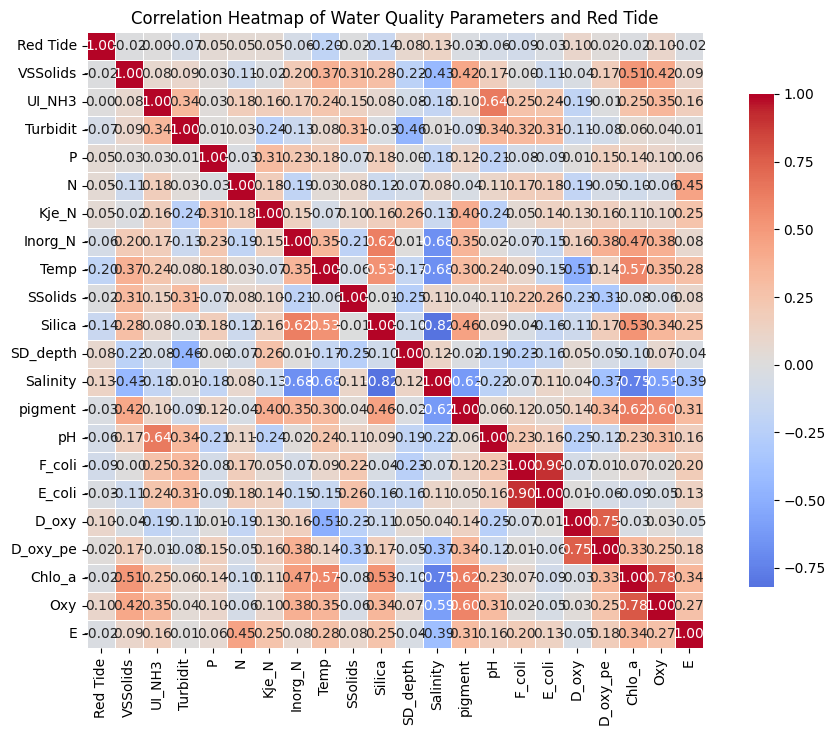

In [27]:
# Drop the 'Date' column from the zone_data DataFrame
zone_data = zone_data.drop(columns=['Date'])

# Calculate the correlation matrix
correlation_matrix = zone_data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))  # Adjust the size of the figure as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})

# Display the heatmap
plt.title('Correlation Heatmap of Water Quality Parameters and Red Tide')
plt.show()

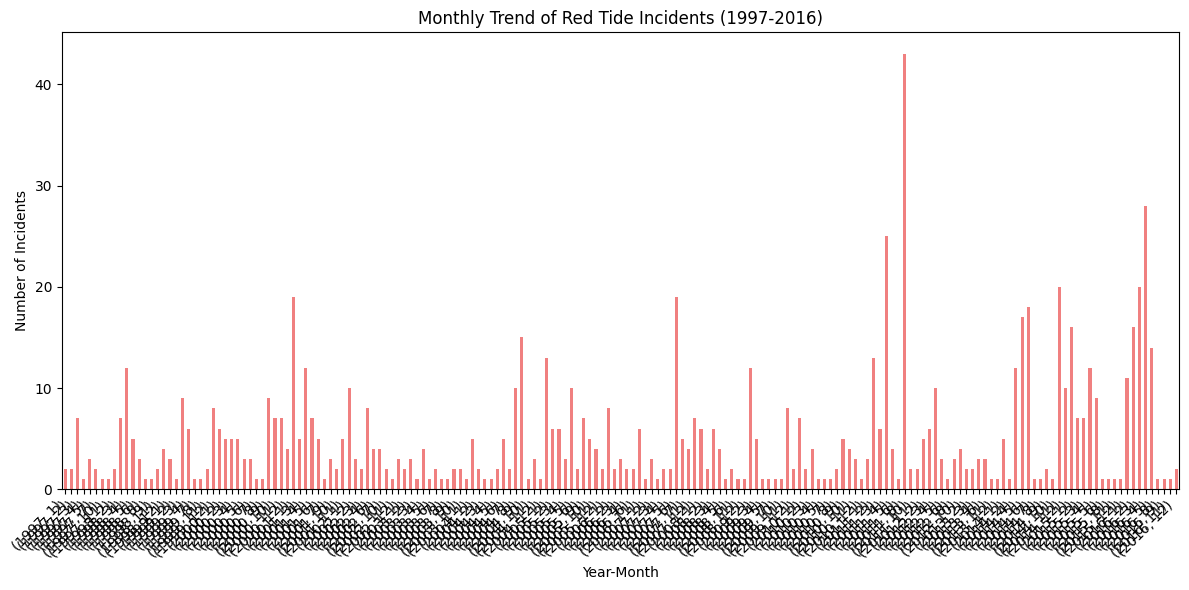

In [7]:
data_filtered = rt_data[['Date of Report', 'Date of Dissipation', 'Location', 'Group ', 'Species', 'Estimated area(sq.m)']].copy()
# Parsing dates with dayfirst=True to ensure correct format
data_filtered['Date of Report'] = pd.to_datetime(data_filtered['Date of Report'], dayfirst=True, errors='coerce')
data_filtered['Date of Dissipation'] = pd.to_datetime(data_filtered['Date of Dissipation'], dayfirst=True, errors='coerce')
# Extracting the month and year for grouping
data_filtered['Month'] = data_filtered['Date of Report'].dt.month
data_filtered['Year'] = data_filtered['Date of Report'].dt.year

# Filter the data for the period of 1997 to 2016
data_filtered = data_filtered[(data_filtered['Year'] >= 1997) & (data_filtered['Year'] <= 2016)]

# Grouping by Year and Month and counting incidents
monthly_incidents = data_filtered.groupby(['Year', 'Month']).size()

# Plotting the monthly trend of red tide incidents
plt.figure(figsize=(12, 6))
monthly_incidents.plot(kind='bar', color='lightcoral')
plt.title("Monthly Trend of Red Tide Incidents (1997-2016)")
plt.xlabel("Year-Month")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [10]:
rt = pd.read_csv('red_tide_occurrences.csv')
rt.head()

Date  Red Tide
0  01/01/1997         1
1  02/01/1997         1
2  03/01/1997         1
3  04/01/1997         1
4  05/01/1997         1

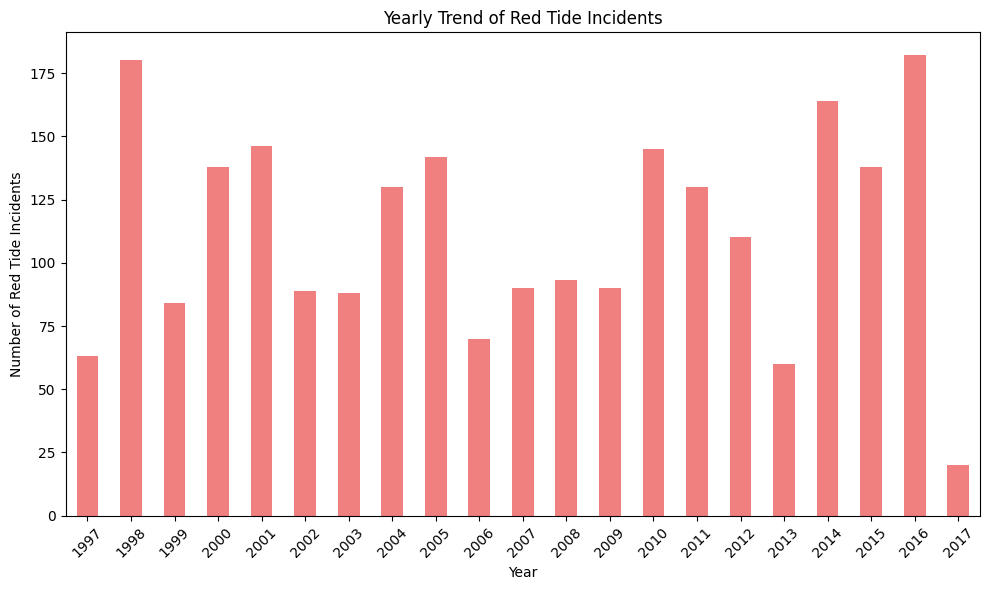

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data
rt = pd.read_csv('red_tide_occurrences.csv')

# Convert 'Date' column to datetime format
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True)

# Extract year from the 'Date' column
rt['Year'] = rt['Date'].dt.year

# Count the number of red tide occurrences for each year
yearly_red_tides = rt.groupby('Year')['Red Tide'].sum()

# Plotting the trend of red tides for each year
plt.figure(figsize=(10, 6))
yearly_red_tides.plot(kind='bar', color='lightcoral')
plt.title("Yearly Trend of Red Tide Incidents")
plt.xlabel("Year")
plt.ylabel("Number of Red Tide Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


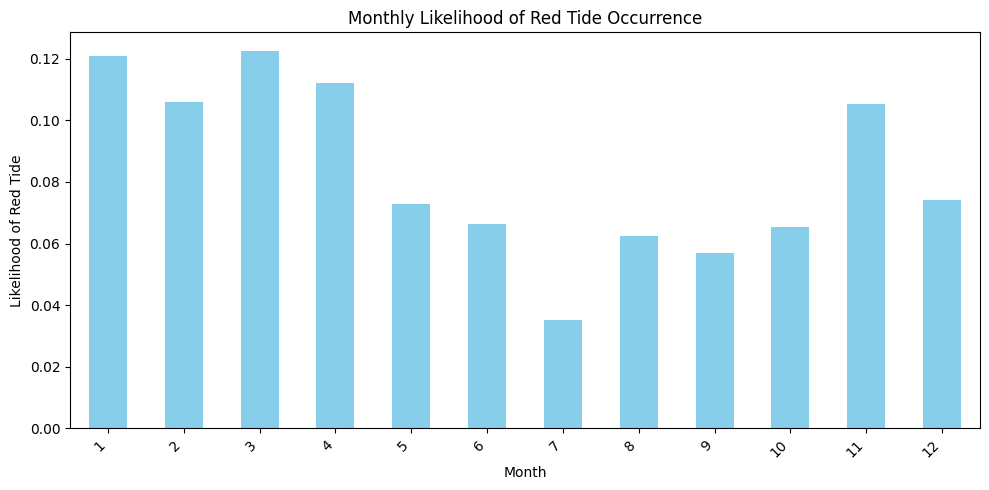

The month with the highest likelihood of red tide occurrence is month 3 with a likelihood of 0.12.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
rt = pd.read_csv('red_tide_occurrences.csv')

# Convert 'Date' column to datetime format
rt['Date'] = pd.to_datetime(rt['Date'], dayfirst=True, errors='coerce')

# Extract year and month from the 'Date' column
rt['Year'] = rt['Date'].dt.year
rt['Month'] = rt['Date'].dt.month

# Group by month and count the occurrences of red tides
monthly_red_tides = rt.groupby('Month')['Red Tide'].sum()

# Calculate the total number of red tide occurrences
total_red_tides = rt['Red Tide'].sum()

# Calculate the likelihood of red tide occurrence for each month
monthly_likelihood = monthly_red_tides / total_red_tides

# Plotting the likelihood of red tides for each month
plt.figure(figsize=(10, 5))
monthly_likelihood.plot(kind='bar', color='skyblue')
plt.title("Monthly Likelihood of Red Tide Occurrence")
plt.xlabel("Month")
plt.ylabel("Likelihood of Red Tide")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Output which month has the highest likelihood
most_likely_month = monthly_likelihood.idxmax()
highest_likelihood = monthly_likelihood.max()
print(f"The month with the highest likelihood of red tide occurrence is month {most_likely_month} with a likelihood of {highest_likelihood:.2f}.")
